In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from typing import List, Tuple, Dict

In [2]:
companies_df = pd.read_csv('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_companies.csv')
index_df = pd.read_csv('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_index.csv')

In [3]:
industrials_df = companies_df[companies_df['Sector'] == 'Industrials']
industrials_df.isna().sum()

Exchange               0
Symbol                 0
Shortname              0
Longname               0
Sector                 0
Industry               0
Currentprice           0
Marketcap              0
Ebitda                 0
Revenuegrowth          0
City                   0
State                  5
Country                0
Fulltimeemployees      0
Longbusinesssummary    0
Weight                 0
dtype: int64

In [4]:
def load_and_clean_stocks_data(filepath: str, verbose: bool = True) -> pd.DataFrame:

    # Load the DataFrame
    stocks_df = pd.read_csv(filepath)

    # Function to check percentage of NA values
    def check_na_percent(data):
        return data.isna().sum() / len(data)

    # Verbose output of NaN information
    if verbose:
        # Check NaN percentages
        na_percentages = check_na_percent(stocks_df)
        print('NaN Percentage per Column:')
        print(na_percentages)
        print(f'\nTotal items: {len(stocks_df)}')
        print(f'Total NaN values: {stocks_df.isna().sum().sum()}')

        # Identify rows with NaNs
        rows_with_nans = stocks_df[stocks_df.isna().any(axis=1)]
        if not rows_with_nans.empty:
            print('\nRows with NaN values:')
            print(rows_with_nans)

    # Convert Date column to datetime
    stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], errors='coerce')

    # Drop NaN values
    stocks_df = stocks_df.dropna()

    # Sanity check
    assert stocks_df.isna().sum().max() == 0, "NaN values remain after cleaning"

    if verbose:
        print('\nDataFrame cleaned successfully.')
        print(f'Remaining rows: {len(stocks_df)}')

    return stocks_df

stocks_df = load_and_clean_stocks_data('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_stocks.csv')

NaN Percentage per Column:
Date         0.000000
Symbol       0.000000
Adj Close    0.054341
Close        0.054341
High         0.054341
Low          0.054341
Open         0.054341
Volume       0.054341
dtype: float64

Total items: 1870154
Total NaN values: 609756

Rows with NaN values:
               Date Symbol  Adj Close  Close  High  Low  Open  Volume
11154    2010-01-04   ABBV        NaN    NaN   NaN  NaN   NaN     NaN
11155    2010-01-05   ABBV        NaN    NaN   NaN  NaN   NaN     NaN
11156    2010-01-06   ABBV        NaN    NaN   NaN  NaN   NaN     NaN
11157    2010-01-07   ABBV        NaN    NaN   NaN  NaN   NaN     NaN
11158    2010-01-08   ABBV        NaN    NaN   NaN  NaN   NaN     NaN
...             ...    ...        ...    ...   ...  ...   ...     ...
1867206  2013-01-25    ZTS        NaN    NaN   NaN  NaN   NaN     NaN
1867207  2013-01-28    ZTS        NaN    NaN   NaN  NaN   NaN     NaN
1867208  2013-01-29    ZTS        NaN    NaN   NaN  NaN   NaN     NaN
1867209  201

In [5]:
print(f"Minimum date: {stocks_df['Date'].min()}")
print(f"Maximum date: {stocks_df['Date'].max()}")

Minimum date: 2010-01-04 00:00:00
Maximum date: 2024-10-10 00:00:00


# Linear Regression Functions

In [6]:
def create_symbol_mask(data, symbol):
    """Create filtered dataframe with percent changes"""
    symbol_df = data[data['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    # Calculate percentage changes for all relevant columns
    for col in ['Close', 'High', 'Low', 'Open']:
        symbol_df[f'{col}_Pct_Change'] = symbol_df[col].pct_change() * 100

    # Initial visualization with transparent background
    fig = plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    ax.plot(symbol_df['Close_Pct_Change'])
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.title(f'{symbol} Daily Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.grid(True)
    plt.show()

    return symbol_df

def plot_initial_prices(df, symbol):
    """Plot initial price visualization"""
    fig = plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    ax.plot(df['Close'])
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.title(f'{symbol} Stock Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.show()

def split_time_series_data(df, feature_columns, target_column='Close',
                          train_size=0.7, val_size=0.15, test_size=0.15):
    """Split data into train, validation, and test sets with custom features"""
    assert np.isclose(train_size + val_size + test_size, 1.0)

    df = df.sort_index()
    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def train_and_evaluate_model(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train model and evaluate performance"""
    # Train model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Make predictions
    validation_preds = lr.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Close'] = y_val
    validation_df['Close Preds'] = validation_preds

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'Validation MSE: {metrics["MSE"]:.2f}')
    print(f'Validation R²: {metrics["R2"]:.2f}')
    print(f'Validation MAE: {metrics["MAE"]:.2f}\n')

    return lr, validation_df, metrics

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, lr, symbol):
    """Create all validation analysis plots"""
    # Scatter plot
    fig = plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    plt.scatter(y_val, validation_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()],
             [y_val.min(), y_val.max()],
             color='red', label='Perfect Predictions')
    plt.xlabel('Actual Close Price')
    plt.ylabel('Predicted Close Price')
    plt.title(f'{symbol} Actual vs Predicted Close Prices (Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Feature importance
    fig = plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    plt.bar(feature_names, lr.coef_)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{symbol} Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Time series plots
    plot_validation_predictions(validation_df, symbol)

def plot_validation_predictions(val_df, symbol, actual_col='Close', pred_col='Close Preds',
                              periods=['full', '2weeks', '1week']):
    """Plot time series predictions"""
    for period in periods:
        last_date = val_df.index.max()
        if period == '2weeks':
            start_date = last_date - pd.Timedelta(days=14)
            title_suffix = '(Last 2 Weeks)'
            data = val_df.loc[start_date:last_date]
        elif period == '1week':
            start_date = last_date - pd.Timedelta(days=7)
            title_suffix = '(Last Week)'
            data = val_df.loc[start_date:last_date]
        else:
            data = val_df
            title_suffix = ''

        fig = plt.figure(figsize=(10, 6), facecolor='none')
        ax = plt.gca()
        ax.set_facecolor('none')

        ax.plot(data[actual_col], label='Actual Close')
        ax.plot(data[pred_col], label='Predicted Close', linestyle='--', alpha=0.8)

        if period in ['1week', '2weeks']:
            ax.xaxis.set_major_locator(mdates.DayLocator())
        else:
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        fig.autofmt_xdate()
        plt.title(f'{symbol} Stock Close Prices: Actual vs Predicted {title_suffix}')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.grid(True)
        plt.legend()
        plt.show()

def analyze_stock_model(data, symbol, feature_sets):
    """
    Analyze stock with multiple feature sets

    Parameters:
    data (DataFrame): Full stock data
    symbol (str): Stock symbol to analyze
    feature_sets (dict): Dictionary of feature set names and their corresponding columns

    Returns:
    dict: Results for each feature set including model, validation data, and metrics
    """
    results = {}

    # Create filtered dataframe
    symbol_df = create_symbol_mask(data, symbol)

    # Plot initial price data
    plot_initial_prices(symbol_df, symbol)

    # Analyze each feature set
    for name, features in feature_sets.items():
        print(f"\nAnalyzing model with {name}:")
        print(f"Features: {features}")

        # Split data
        X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
            symbol_df, features
        )

        # Train and evaluate
        lr, validation_df, metrics = train_and_evaluate_model(
            X_train, y_train, X_val, y_val, features, symbol
        )

        # Create plots
        plot_validation_analysis(
            validation_df, y_val, validation_df['Close Preds'],
            features, lr, symbol
        )

        # Store results
        results[name] = {
            'model': lr,
            'validation_data': validation_df,
            'metrics': metrics,
            'features': features
        }

    return results

def analyze_predictions(validation_df):
    """Analyze the model's prediction accuracy"""
    # Determine actual and predicted directions
    validation_df['Actual_Direction'] = validation_df['Actual_Pct_Change'].apply(lambda x: 'Up' if x > 0 else 'Down')
    validation_df['Predicted_Direction'] = validation_df['Predicted_Pct_Change'].apply(lambda x: 'Up' if x > 0 else 'Down')

    # Calculate directional accuracy
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    # Print analysis
    print("\nDirectional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    # Show example of the first few days
    print("\nFirst few days of predictions:")
    print(validation_df[['Actual_Pct_Change', 'Predicted_Pct_Change', 'Direction_Match']].head())

    return validation_df

# **Linear Regression Model 1**

Realized that Version 1 was using the incorrect dataframe when plotting and making my errors. Version 1 is then simply wrong and doesn't work properly when you try to fix it. Really Version 2 is the first working model.

This time around we see that the model is a little bit worse compared to splitting the data randomly using sklearn train_test_split.

The feature importance stays relatively similar. We see that `Open`, `High` and `Low` are the strong predictors, but now we see that `Adj Close` has some small relevance.

For the next version we will remove the `Volume` columns as a feature as it does nothing for the model.

NUMBERS:

* Training set: 2602 samples (2010-01-04 00:00:00 to 2020-05-05 00:00:00)

* Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)

* Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)

* Validation MSE: 0.69

* Validation R²: 1.00

* Validation MAE: 0.66

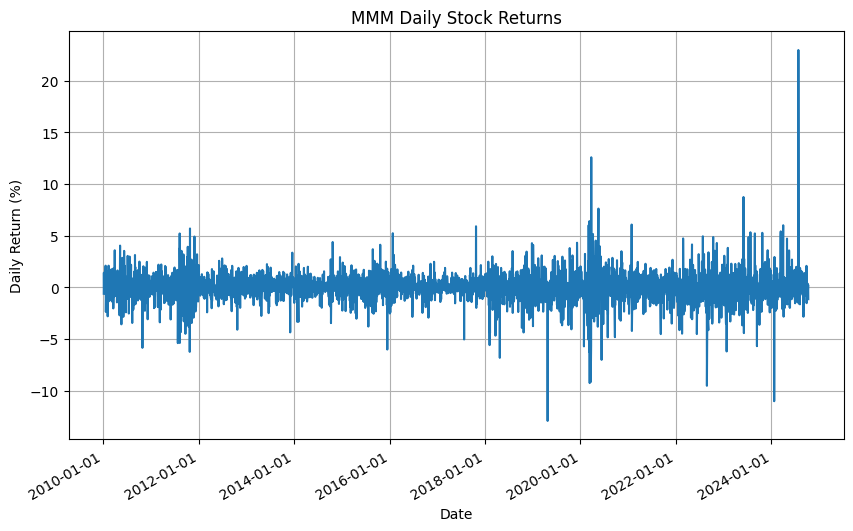

Training set: 2602 samples (2010-01-04 00:00:00 to 2020-05-05 00:00:00)
Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)
Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)
Validation MSE: 0.69
Validation R²: 1.00
Validation MAE: 0.66



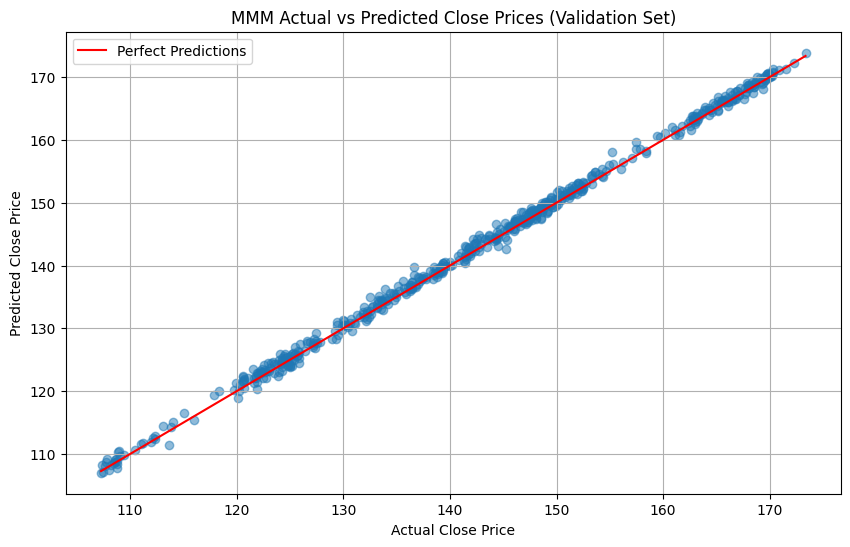

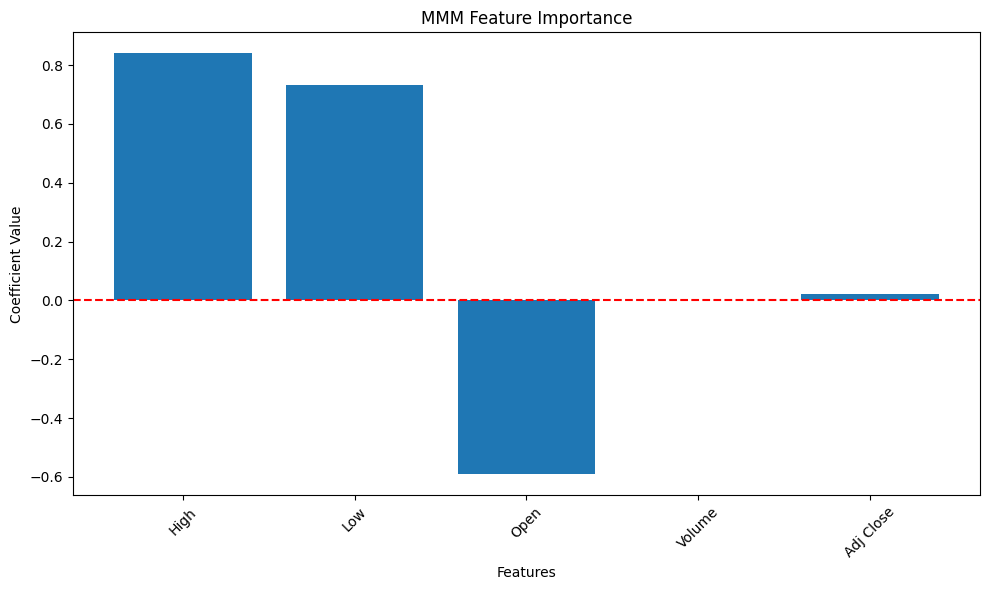

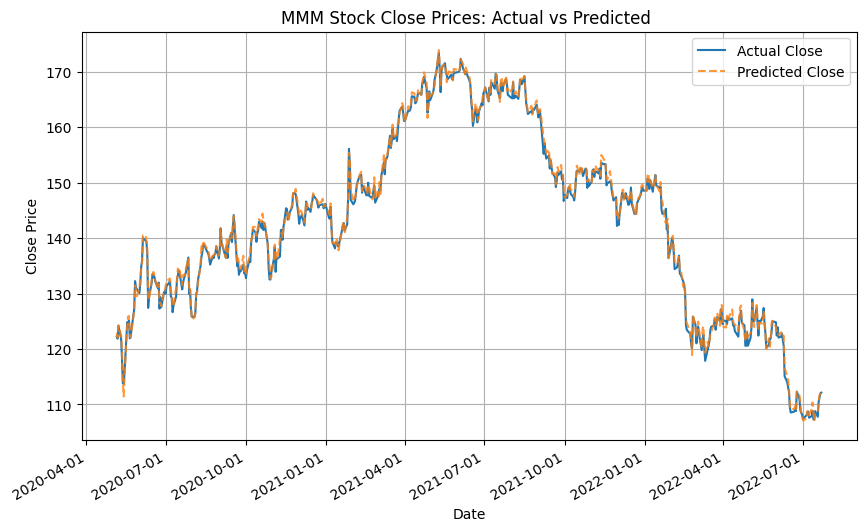

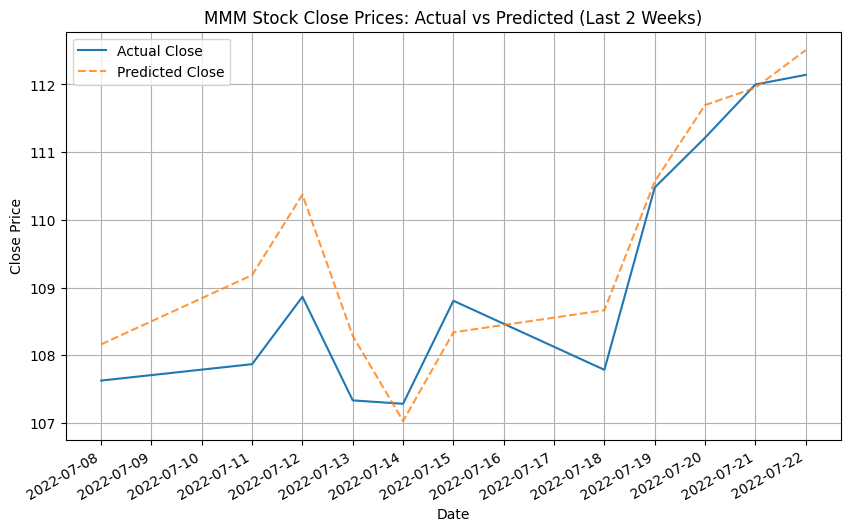

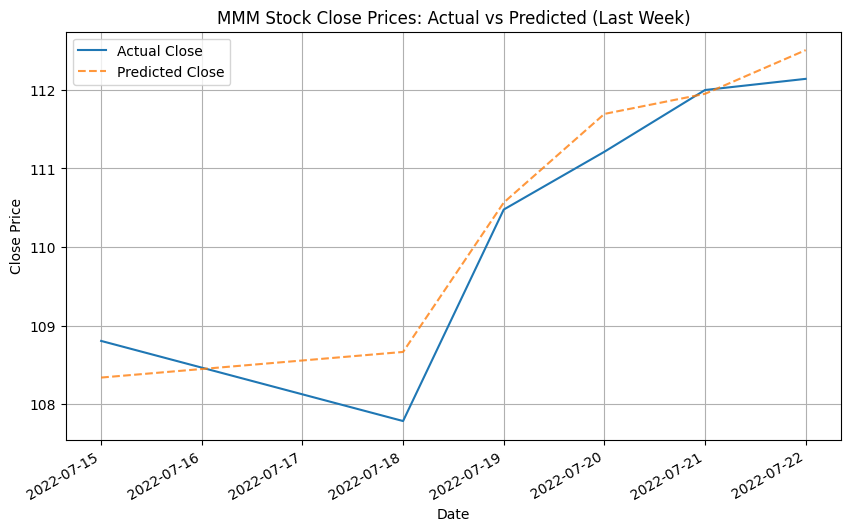

In [7]:
 # Get filtered data for MMM
mmm_df = create_symbol_mask(stocks_df, 'MMM')

# Define feature set
features = ['High', 'Low', 'Open', 'Volume', 'Adj Close']

# Split the data
X_train, y_train, X_validation, y_validation, X_test, y_test = split_time_series_data(
    mmm_df,
    feature_columns=features
)

# Train model and get validation results
lr, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_validation,
    y_validation,
    features,
    'MMM'
)

# Create all validation plots
plot_validation_analysis(
    validation_df,
    y_validation,
    validation_df['Close Preds'],
    features,
    lr,
    'MMM'
)

# **Version 2**

This version is a little bit better than the previous one. The MSE is simply 0.01 lower.

We still see that Adj Close does not make a huge difference in the model compared to the other features, so for next version we will remove that feature.

* Training set: 2602 samples (2010-01-04 00:00:00 to 2020-05-05 00:00:00)
* Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)
* Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)
* Validation MSE: 0.68
* Validation R²: 1.00
* Validation MAE: 0.66[link text](https://)

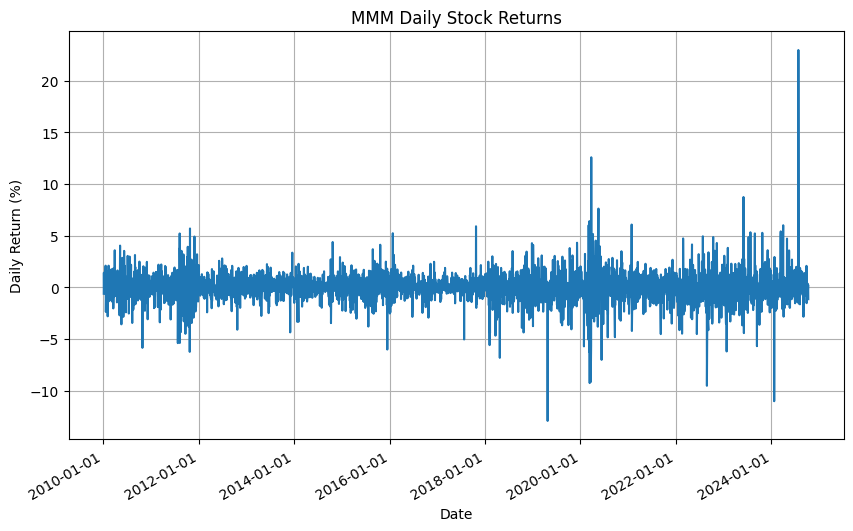

Training set: 2602 samples (2010-01-04 00:00:00 to 2020-05-05 00:00:00)
Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)
Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)
Validation MSE: 0.68
Validation R²: 1.00
Validation MAE: 0.66



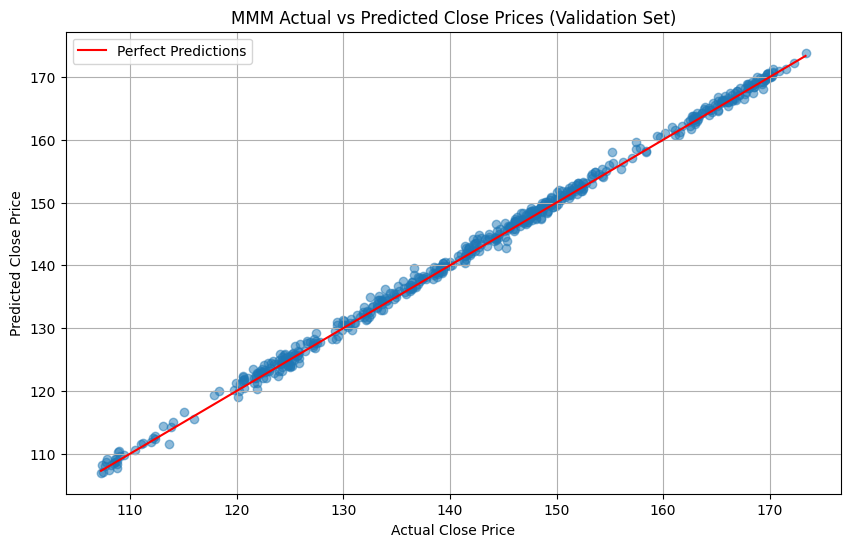

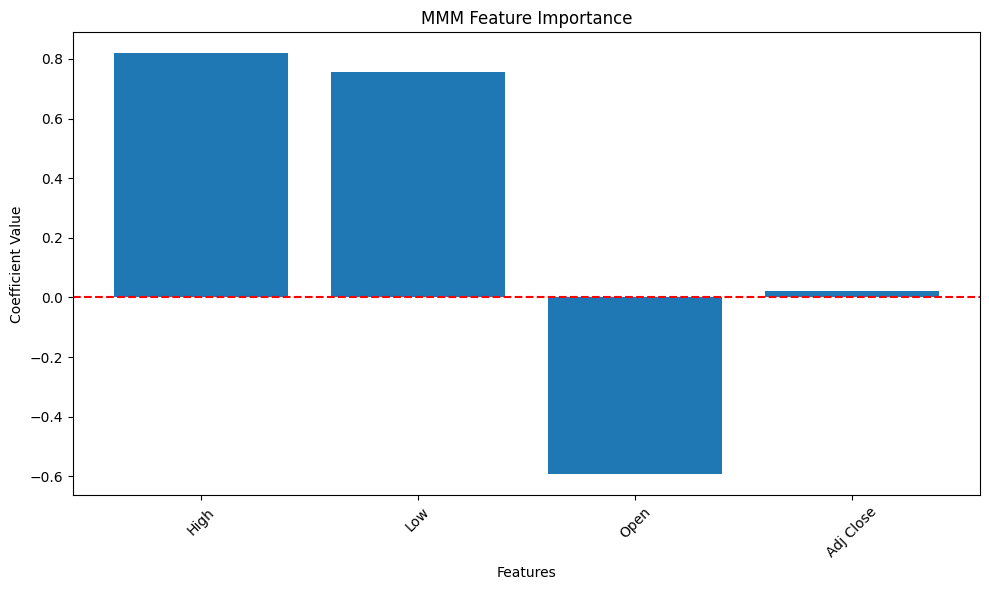

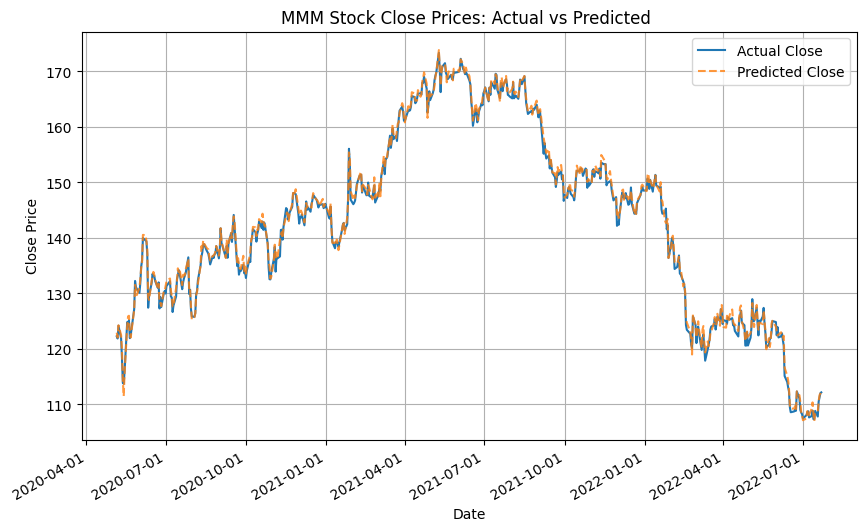

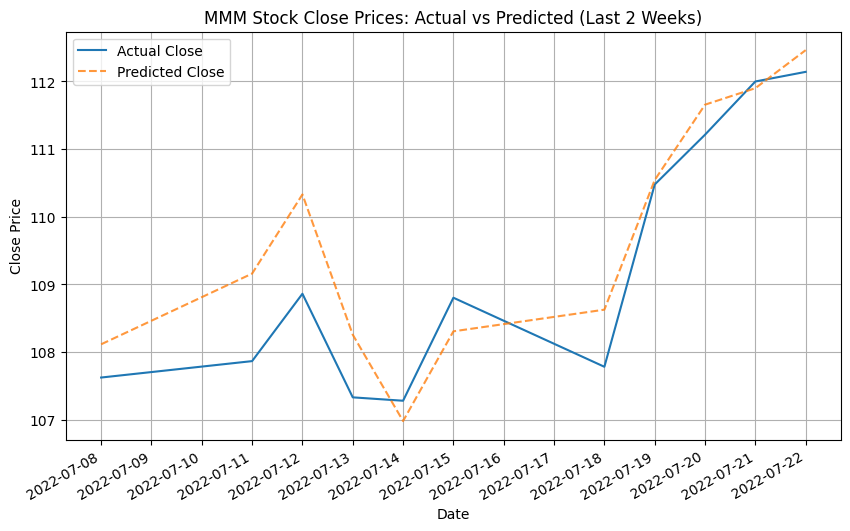

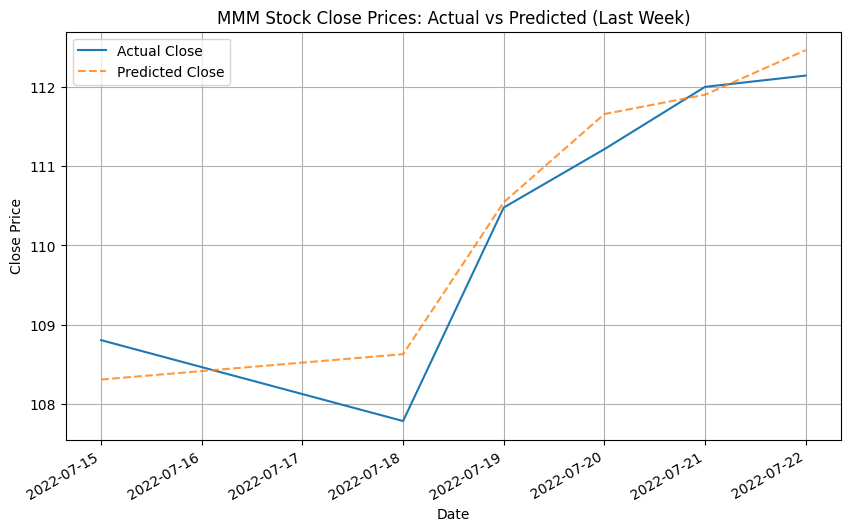

In [8]:
 # Get filtered data for MMM
mmm_df = create_symbol_mask(stocks_df, 'MMM')

# Define feature set
features = ['High', 'Low', 'Open', 'Adj Close']

# Split the data
X_train, y_train, X_validation, y_validation, X_test, y_test = split_time_series_data(
    mmm_df,
    feature_columns=features
)

# Train model and get validation results
lr, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_validation,
    y_validation,
    features,
    'MMM'
)

# Create all validation plots
plot_validation_analysis(
    validation_df,
    y_validation,
    validation_df['Close Preds'],
    features,
    lr,
    'MMM'
)

# **Version 3**

This model gets our first big jump in accuracy compared to our previous models.

Our MSE went from 0.68 to 0.56, and MAE went from 0.66 to 0.59.

* Training set: 2602 samples (2010-01-04 00:00:00 to 2020-05-05 00:00:00)
* Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)
* Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)
* Validation MSE: 0.56
* Validation R²: 1.00
* Validation MAE: 0.59

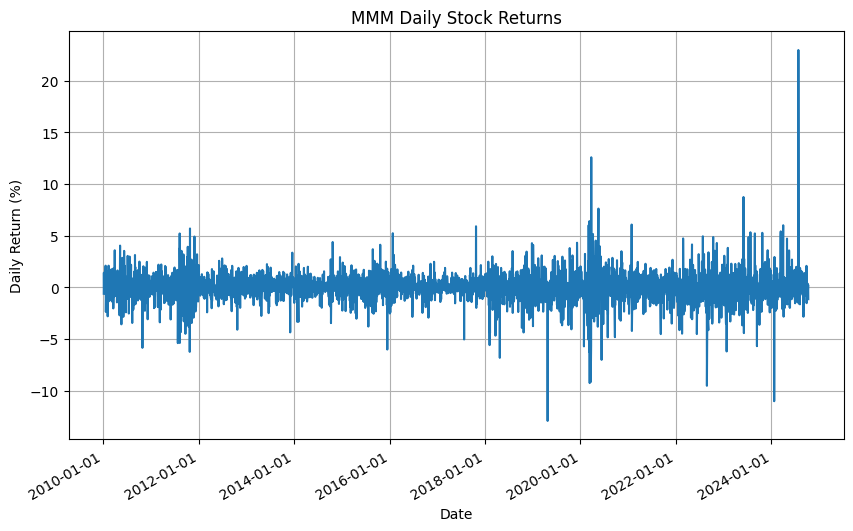

Training set: 2602 samples (2010-01-04 00:00:00 to 2020-05-05 00:00:00)
Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)
Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)
Validation MSE: 0.56
Validation R²: 1.00
Validation MAE: 0.59



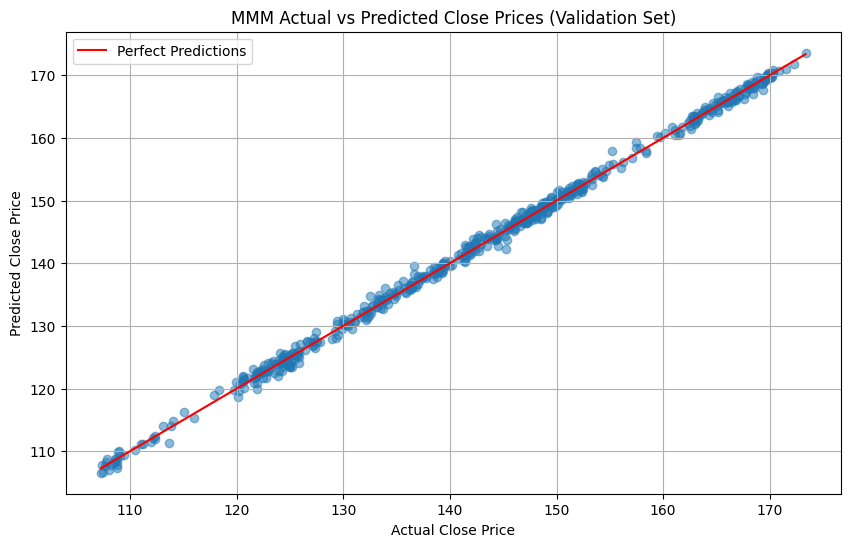

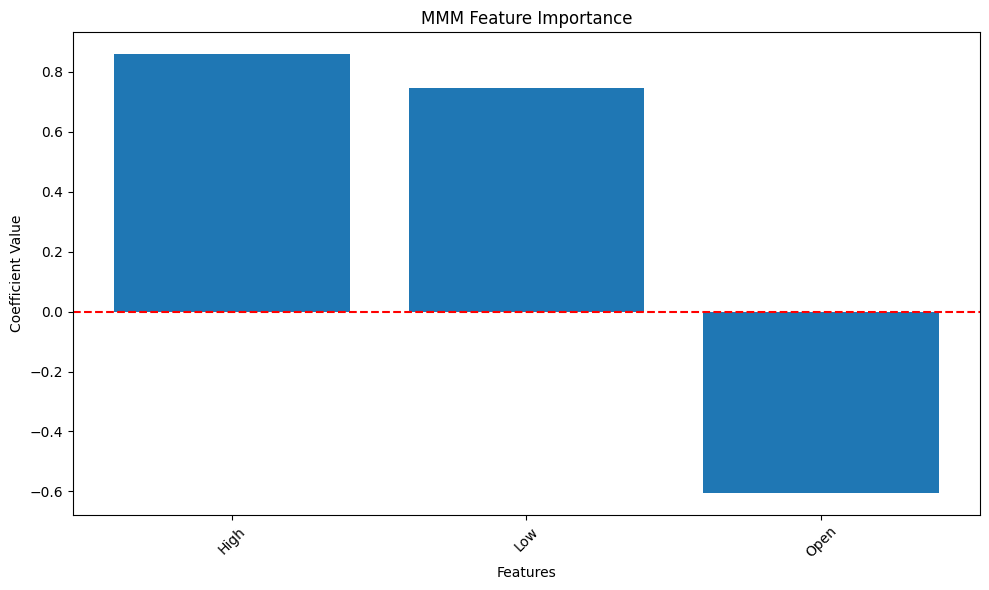

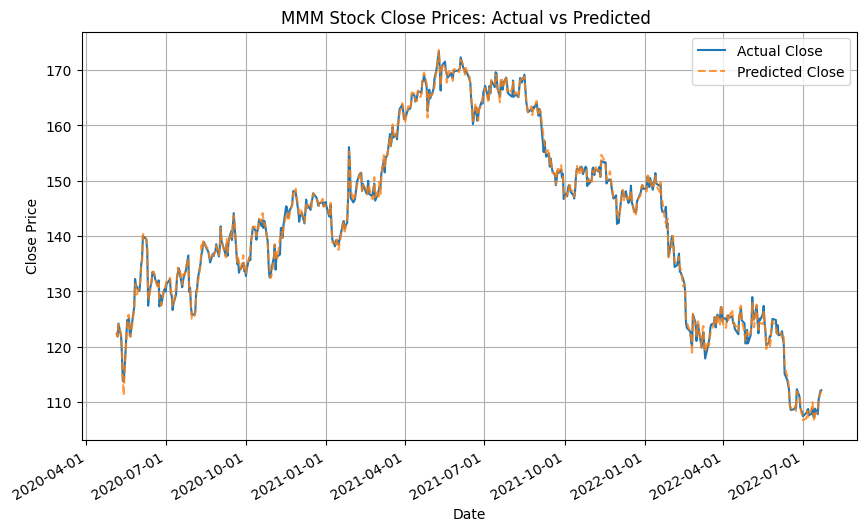

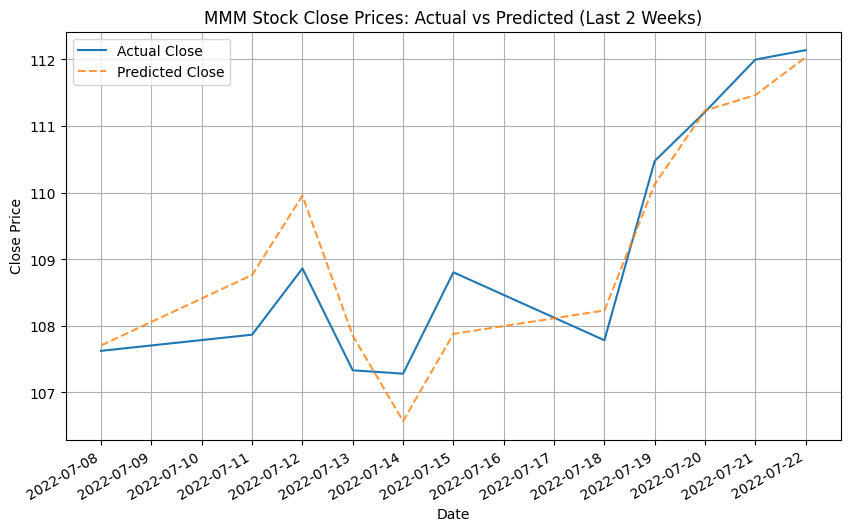

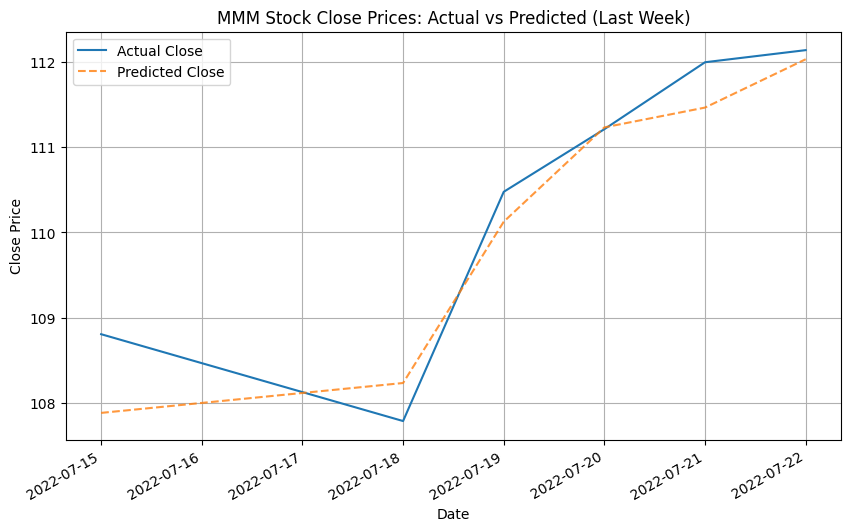

In [9]:
 # Get filtered data for MMM
mmm_df = create_symbol_mask(stocks_df, 'MMM')

# Define feature set
features = ['High', 'Low', 'Open']

# Split the data
X_train, y_train, X_validation, y_validation, X_test, y_test = split_time_series_data(
    mmm_df,
    feature_columns=features
)

# Train model and get validation results
lr, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_validation,
    y_validation,
    features,
    'MMM'
)

# Create all validation plots
plot_validation_analysis(
    validation_df,
    y_validation,
    validation_df['Close Preds'],
    features,
    lr,
    'MMM'
)

# **Version 4**

**After Savala Tips**

* Make a new column whats the percent change of closing price, whats the percent change rather than the actual price.

* What percentage did the model correctly predict the direction (trend), did the stock go up or down.

* If the prediction is off by a dollar we are happy, unless we are dealing with penny stocks, so that is why we instead look at the percentage change rather than real value.

* Another thing we would be happy with is if the model correctly predicts if the trend is bear or bull for the day. In simpler terms, how good is the model at predicting if the price is going up or down, no matter by how much.

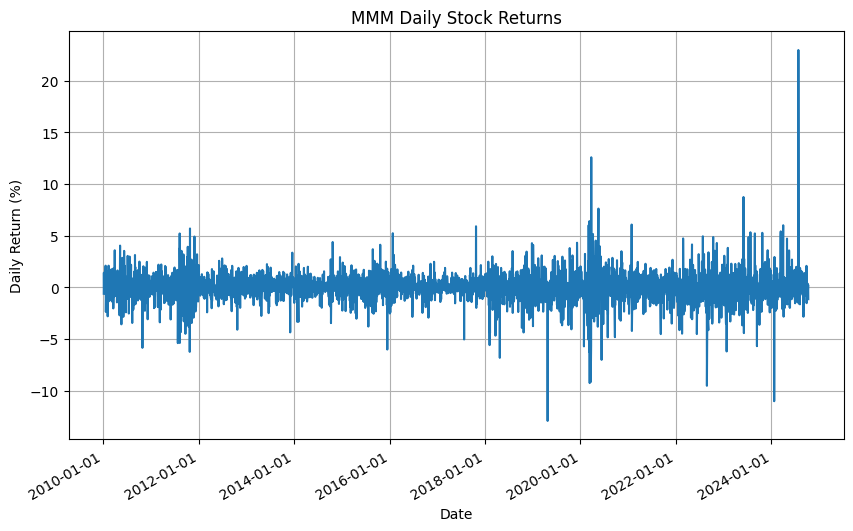

Training set: 2601 samples (2010-01-05 00:00:00 to 2020-05-05 00:00:00)
Validation set: 558 samples (2020-05-06 00:00:00 to 2022-07-22 00:00:00)
Test set: 558 samples (2022-07-25 00:00:00 to 2024-10-10 00:00:00)

Directional Prediction Analysis:
Directional Accuracy: 81.18%

First few days of predictions:
            Actual_Pct_Change  Predicted_Pct_Change  Direction_Match
Date                                                                
2020-05-06          -0.834293             -0.691528             True
2020-05-07          -0.314642             -0.570052             True
2020-05-08           1.900646              1.645337             True
2020-05-11          -1.871930             -1.341327             True
2020-05-12          -2.888903             -1.518368             True

Validation Metrics (for percent changes):
MSE: 0.5435 (mean squared error in percentage points)
R²: 0.7381
MAE: 0.5681 (mean absolute error in percentage points)


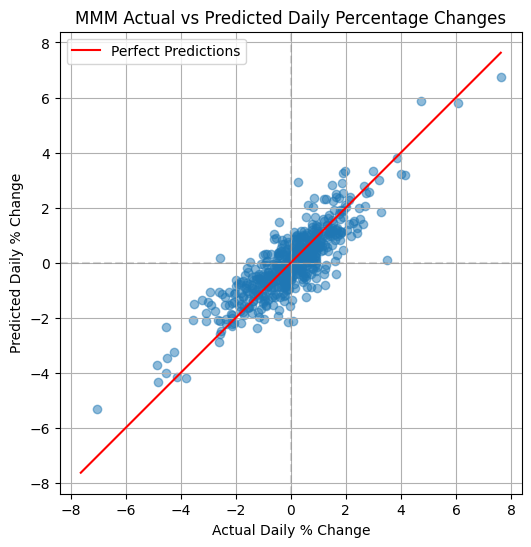

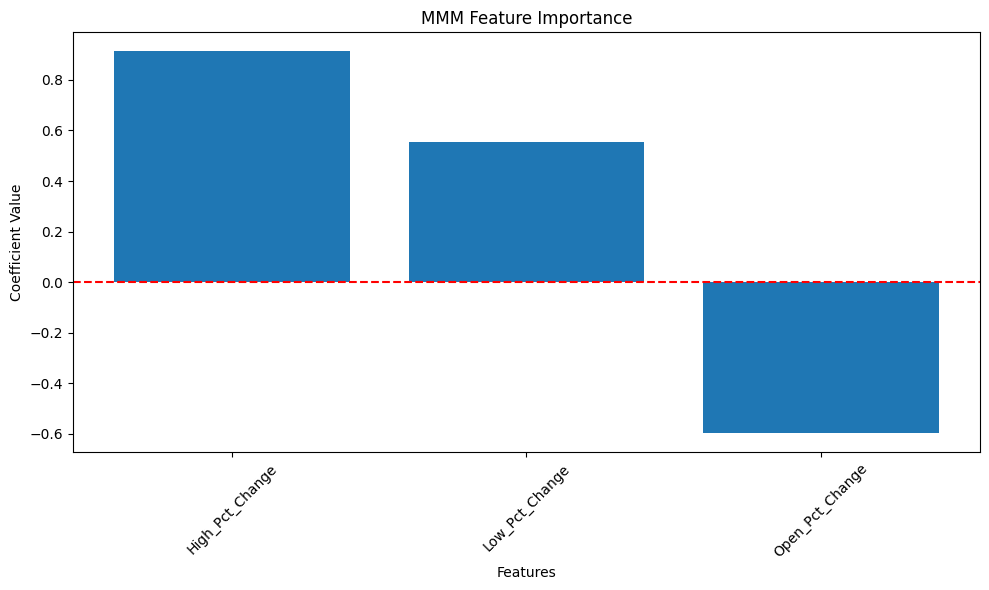

In [10]:
def create_symbol_mask(data, symbol):
    """Create filtered dataframe with percent changes"""
    symbol_df = data[data['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    # Calculate percentage changes for all relevant columns
    for col in ['Close', 'High', 'Low', 'Open']:
        symbol_df[f'{col}_Pct_Change'] = symbol_df[col].pct_change() * 100

    # Initial visualization with transparent background
    fig = plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    ax.plot(symbol_df['Close_Pct_Change'])
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.title(f'{symbol} Daily Stock Returns')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.grid(True)
    plt.show()

    return symbol_df

def split_time_series_data(df, feature_columns, target_column='Close_Pct_Change',
                          train_size=0.7, val_size=0.15, test_size=0.15):
    """Split data into train, validation, and test sets"""
    assert np.isclose(train_size + val_size + test_size, 1.0)

    # Remove first row since it has NaN from pct_change
    df = df.iloc[1:]
    df = df.sort_index()

    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def train_and_evaluate_model(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train model and evaluate performance"""
    # Train model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Make predictions
    validation_preds = lr.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df = analyze_predictions(validation_df)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    return lr, validation_df, metrics

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, lr, symbol):
    """Create validation analysis plots"""
    # Percent change scatter plot
    plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    plt.scatter(validation_df['Actual_Pct_Change'],
                validation_df['Predicted_Pct_Change'],
                alpha=0.5)

    # Find the maximum absolute value for creating symmetric axes
    max_val = max(
        abs(validation_df['Actual_Pct_Change'].max()),
        abs(validation_df['Actual_Pct_Change'].min()),
        abs(validation_df['Predicted_Pct_Change'].max()),
        abs(validation_df['Predicted_Pct_Change'].min())
    )

    # Plot perfect prediction line
    plt.plot([-max_val, max_val], [-max_val, max_val],
             color='red', label='Perfect Predictions')

    # Add quadrant lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    plt.xlabel('Actual Daily % Change')
    plt.ylabel('Predicted Daily % Change')
    plt.title(f'{symbol} Actual vs Predicted Daily Percentage Changes')
    plt.legend()
    plt.grid(True)
    plt.axis('square')
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(10, 6), facecolor='none')
    ax = plt.gca()
    ax.set_facecolor('none')
    plt.bar(feature_names, lr.coef_)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{symbol} Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usage example:
mmm_df = create_symbol_mask(stocks_df, 'MMM')

# Define feature set (now using percentage changes)
features = ['High_Pct_Change', 'Low_Pct_Change', 'Open_Pct_Change']

# Split the data
X_train, y_train, X_validation, y_validation, X_test, y_test = split_time_series_data(
    mmm_df,
    feature_columns=features
)

# Train model and get validation results
lr, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_validation,
    y_validation,
    features,
    'MMM'
)

# Create validation plots
plot_validation_analysis(
    validation_df,
    y_validation,
    validation_df['Predicted_Pct_Change'],
    features,
    lr,
    'MMM'
)

In [11]:
mmm_df.head()

Symbol  Adj Close      Close       High        Low       Open  \
Date                                                                       
2010-01-04    MMM  44.016735  69.414719  69.774246  69.122070  69.473244   
2010-01-05    MMM  43.741009  68.979935  69.590302  68.311035  69.230766   
2010-01-06    MMM  44.361355  69.958191  70.735786  69.824417  70.133781   
2010-01-07    MMM  44.393166  70.008362  70.033447  68.662209  69.665550   
2010-01-08    MMM  44.705990  70.501671  70.501671  69.648827  69.974915   

               Volume  Close_Pct_Change  High_Pct_Change  Low_Pct_Change  \
Date                                                                       
2010-01-04  3640265.0               NaN              NaN             NaN   
2010-01-05  3405012.0         -0.626357        -0.263628       -1.173337   
2010-01-06  6301126.0          1.418175         1.646041        2.215428   
2010-01-07  5346240.0          0.071716        -0.992905       -1.664473   
2010-01-08  4073337.0          0.704643         0.668571        1.436916   

            Open_Pct_Change  
Date                         
2010-01-04              NaN  
2010-01-05        -0.349023  
2010-01-06         1.304355  
2010-01-07        -0.667626  
2010-01-08         0.444071

right now it works by feeding it the day's data and trying to predict the closing price, so it should feed it the previous' days data.

Go crazy and add a feature that updates itself per new day.

So day 7 of the stock would have 6 days prior of data, while day 170 would have 169.

Add more columns / features

Last 7 days avg feature (needs to be row per row)

Should work like this:

I want to predict Day 8 with the information from the last 7 days avg price

Also add data from other stocks that are correlated into the features




In Version 5, we made a fundamental shift from predicting raw closing prices to predicting percentage changes in prices, addressing the issue from Version 4 where the model was using same-day data to predict closing prices. We introduced technical indicators commonly used in stock analysis: Relative Strength Index (RSI) with a 14-day window, Moving Average Convergence Divergence (MACD), and Bollinger Bands. We also added 5-day rolling statistics (mean, standard deviation, minimum, maximum, and median) for all OHLCV (Open, High, Low, Volume, Close) data. The evaluation metrics were updated to focus on the model's ability to predict price movement directions (up/down) rather than just the magnitude of price changes. This version also improved the data pipeline by properly handling the first 14 days of data that couldn't be used due to the RSI calculation window. The visualization was enhanced to include a confusion matrix for directional predictions and a more detailed feature importance plot. This version marked a transition from a simple price prediction model to one that incorporates technical analysis indicators and focuses on predicting price movements.

# VERSION 5

In [12]:
def split_time_series_data(
    df: pd.DataFrame,
    feature_columns: List[str],
    target_column: str = 'Next_Close_Pct_Change',
    train_size: float = 0.7,
    val_size: float = 0.15
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """Split data into train, validation, and test sets chronologically"""
    # Ensure the target column exists
    if target_column not in df.columns:
        print(f"Warning: Target column '{target_column}' not found. Available columns: {df.columns.tolist()}")
        target_column = 'Next_Close_Pct_Change'  # Default fallback

    # Remove first row since it may have NaN from percentage change calculation
    df = df.iloc[1:]
    df = df.sort_index()

    n = len(df)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def calculate_rsi(data: pd.Series, periods: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI)"""
    # Calculate price changes
    delta = data.diff()

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))

    # Calculate average gain and loss over the specified period
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()

    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_macd(data: pd.Series, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9) -> pd.DataFrame:
    """Calculate Moving Average Convergence Divergence (MACD)"""
    # Calculate EMAs
    ema_fast = data.ewm(span=fast_period, adjust=False).mean()
    ema_slow = data.ewm(span=slow_period, adjust=False).mean()

    # Calculate MACD line and signal line
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD histogram
    macd_hist = macd_line - signal_line

    return pd.DataFrame({
        'MACD': macd_line,
        'Signal': signal_line,
        'Histogram': macd_hist
    })

def calculate_bollinger_bands(data: pd.Series, window: int = 20, num_std: float = 2) -> pd.DataFrame:
    """Calculate Bollinger Bands"""
    # Calculate middle band (simple moving average)
    middle_band = data.rolling(window=window).mean()

    # Calculate standard deviation
    std = data.rolling(window=window).std()

    # Calculate upper and lower bands
    upper_band = middle_band + (std * num_std)
    lower_band = middle_band - (std * num_std)

    return pd.DataFrame({
        'Middle': middle_band,
        'Upper': upper_band,
        'Lower': lower_band
    })

def calculate_rolling_stats(data: pd.Series, window: int = 5) -> pd.DataFrame:
    """Calculate various rolling statistics"""
    return pd.DataFrame({
        f'Rolling_Mean_{window}': data.rolling(window=window).mean(),
        f'Rolling_Std_{window}': data.rolling(window=window).std(),
        f'Rolling_Min_{window}': data.rolling(window=window).min(),
        f'Rolling_Max_{window}': data.rolling(window=window).max(),
        f'Rolling_Median_{window}': data.rolling(window=window).median()
    })

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create all technical features for the stock data"""
    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for price columns
    for column in ['Close', 'Open', 'High', 'Low']:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Calculate technical indicators for Close price
    result['RSI'] = calculate_rsi(df['Close'])

    macd_features = calculate_macd(df['Close'])
    result['MACD'] = macd_features['MACD']
    result['MACD_Signal'] = macd_features['Signal']
    result['MACD_Hist'] = macd_features['Histogram']

    bb_features = calculate_bollinger_bands(df['Close'])
    result['BB_Middle'] = bb_features['Middle']
    result['BB_Upper'] = bb_features['Upper']
    result['BB_Lower'] = bb_features['Lower']

    # Calculate 5-day rolling stats for OHLCV
    for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
        rolling_stats = calculate_rolling_stats(df[column])
        for stat_col in rolling_stats.columns:
            result[f'{column}_{stat_col}'] = rolling_stats[stat_col]

    # Calculate target (next day's closing price percentage change)
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)

    # Drop rows with NaN values (should be just the first few rows due to calculations)
    result = result.dropna()

    # Verify no NaN values remain
    assert result.isna().sum().sum() == 0, "NaN values found after feature engineering"

    return result

def prepare_model_data(df: pd.DataFrame) -> tuple:
    """Prepare feature matrix X and target vector y for modeling"""
    # Define features to use (exclude target and any irrelevant columns)
    feature_columns = [col for col in df.columns if col not in [
        'Next_Close_Pct_Change', 'Symbol', 'Close', 'Date'
    ]]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']

    # Final check for NaN values
    assert X.isna().sum().sum() == 0, "NaN values found in feature matrix X"
    assert y.isna().sum().sum() == 0, "NaN values found in target vector y"

    return X, y

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, lr, symbol):
    """Create validation analysis plots with improved feature importance visualization"""
    # Create figure with larger size
    plt.figure(figsize=(15, 12))

    # Scatter plot
    plt.subplot(2, 1, 1)
    plt.scatter(validation_df['Actual_Pct_Change'],
                validation_df['Predicted_Pct_Change'],
                alpha=0.5)

    max_val = max(
        abs(validation_df['Actual_Pct_Change'].max()),
        abs(validation_df['Actual_Pct_Change'].min()),
        abs(validation_df['Predicted_Pct_Change'].max()),
        abs(validation_df['Predicted_Pct_Change'].min())
    )

    plt.plot([-max_val, max_val], [-max_val, max_val],
             color='red', label='Perfect Predictions')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.xlabel('Actual Daily % Change')
    plt.ylabel('Predicted Daily % Change')
    plt.title(f'{symbol} Actual vs Predicted Daily Percentage Changes')
    plt.legend()
    plt.grid(True)

    # Feature importance plot with improved spacing
    plt.subplot(2, 1, 2)

    # Create DataFrame of feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': abs(lr.coef_)
    }).sort_values('Importance', ascending=True)

    # Create bar plot with more space between bars
    y_pos = np.arange(len(importance_df)) * 1.5  # Increased spacing between bars
    plt.barh(y_pos, importance_df['Importance'], height=0.8)  # Reduced bar height

    # Add feature names with improved spacing
    plt.yticks(y_pos, importance_df['Feature'], fontsize=10)

    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance (Absolute Coefficient Values)')

    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    plt.show()

    # Print feature importance values
    print("\nFeature Importance Values (sorted):")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.6f}")

Training set: 2588 samples (2010-02-01 00:00:00 to 2020-05-12 00:00:00)
Validation set: 555 samples (2020-05-13 00:00:00 to 2022-07-26 00:00:00)
Test set: 555 samples (2022-07-27 00:00:00 to 2024-10-09 00:00:00)

Directional Prediction Analysis:
Directional Accuracy: 50.27%

Directional Prediction Confusion Matrix:
Predicted_Direction  Down   Up  All
Actual_Direction                   
Down                  201   64  265
Up                    212   78  290
All                   413  142  555

Validation Metrics (for percent changes):
MSE: 0.0002 (mean squared error in percentage points)
R²: -0.0419
MAE: 0.0107 (mean absolute error in percentage points)


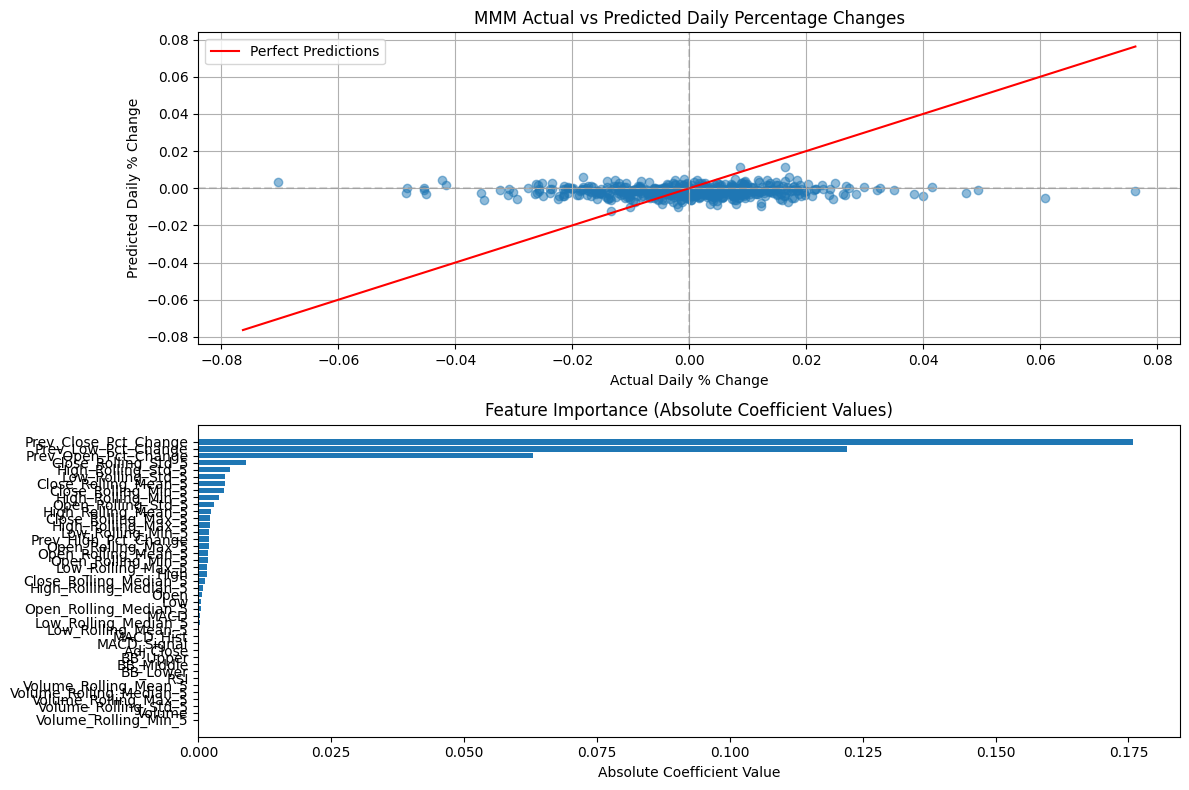

In [13]:
def split_time_series_data(df, feature_columns, target_column='Next_Close_Pct_Change',
                          train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets chronologically"""
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # Prepare X and y for each set
    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def analyze_predictions(validation_df):
    """Analyze the model's prediction accuracy"""
    # Determine actual and predicted directions
    validation_df['Actual_Direction'] = np.where(validation_df['Actual_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Predicted_Direction'] = np.where(validation_df['Predicted_Pct_Change'] > 0, 'Up', 'Down')

    # Calculate directional accuracy
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    print("\nDirectional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    # Show confusion matrix for directional predictions
    confusion = pd.crosstab(validation_df['Actual_Direction'],
                           validation_df['Predicted_Direction'],
                           margins=True)
    print("\nDirectional Prediction Confusion Matrix:")
    print(confusion)

    return validation_df

def train_and_evaluate_model(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train model and evaluate performance"""
    # Train model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Make predictions
    validation_preds = lr.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df = analyze_predictions(validation_df)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    return lr, validation_df, metrics

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, lr, symbol):
    """Create validation analysis plots"""
    # Percent change scatter plot
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.scatter(validation_df['Actual_Pct_Change'],
                validation_df['Predicted_Pct_Change'],
                alpha=0.5)

    max_val = max(
        abs(validation_df['Actual_Pct_Change'].max()),
        abs(validation_df['Actual_Pct_Change'].min()),
        abs(validation_df['Predicted_Pct_Change'].max()),
        abs(validation_df['Predicted_Pct_Change'].min())
    )

    plt.plot([-max_val, max_val], [-max_val, max_val],
             color='red', label='Perfect Predictions')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.xlabel('Actual Daily % Change')
    plt.ylabel('Predicted Daily % Change')
    plt.title(f'{symbol} Actual vs Predicted Daily Percentage Changes')
    plt.legend()
    plt.grid(True)

    # Feature importance plot
    plt.subplot(2, 1, 2)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': abs(lr.coef_)
    }).sort_values('Importance', ascending=True)

    plt.barh(range(len(importance_df)), importance_df['Importance'])
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importance (Absolute Coefficient Values)')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Get stock data and create features
    symbol = 'MMM'
    symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    # Engineer features
    feature_df = engineer_features(symbol_df)

    # Get feature matrix and target
    X, y = prepare_model_data(feature_df)

    # Split data
    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
        feature_df,
        X.columns
    )

    # Train and evaluate model
    lr, validation_df, metrics = train_and_evaluate_model(
        X_train,
        y_train,
        X_val,
        y_val,
        X.columns,
        symbol
    )

    # Plot analysis
    plot_validation_analysis(
        validation_df,
        y_val,
        validation_df['Predicted_Pct_Change'],
        X.columns,
        lr,
        symbol
    )

In Version 6, we made significant changes to our feature engineering approach while keeping the core model architecture the same. The main modification was removing all Volume-related features after observing their minimal impact in Version 5's feature importance analysis. Additionally, we expanded our rolling statistics calculation to include multiple timeframes (1, 3, 5, 7, and 14 days) instead of just the 5-day window used in Version 5. We introduced new momentum indicators that track price movements and trends over these same periods, including percentage changes and rate of change calculations. This change allows the model to capture both short-term (1-3 days) and medium-term (7-14 days) price movements. We maintained the technical indicators that showed moderate importance in Version 5 (RSI, MACD, and Bollinger Bands) but enhanced their potential impact by complementing them with the new momentum features. The calculation of rolling statistics (mean, standard deviation, minimum, maximum, and median) was also expanded to cover all these new time periods for Open, High, Low, and Close prices, providing a more comprehensive view of price behavior across different timeframes. This version represents a more focused approach by removing less impactful features (Volume) while adding more granular price movement indicators.

# Version 6

In [14]:
import pandas as pd
import numpy as np
from typing import List

def calculate_rsi(data: pd.Series, periods: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data: pd.Series) -> dict:
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = data.ewm(span=12, adjust=False).mean()
    ema_slow = data.ewm(span=26, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return {
        'MACD': macd_line,
        'MACD_Signal': signal_line,
        'MACD_Hist': macd_hist
    }

def calculate_bollinger_bands(data: pd.Series) -> dict:
    """Calculate Bollinger Bands"""
    middle_band = data.rolling(window=20).mean()
    std = data.rolling(window=20).std()
    upper_band = middle_band + (std * 2)
    lower_band = middle_band - (std * 2)
    return {
        'BB_Middle': middle_band,
        'BB_Upper': upper_band,
        'BB_Lower': lower_band
    }

def calculate_momentum(data: pd.Series, periods: List[int]) -> dict:
    """Calculate momentum indicators for multiple periods"""
    features = {}
    for period in periods:
        features[f'Momentum_{period}d'] = data.pct_change(periods=period)
        features[f'ROC_{period}d'] = (data - data.shift(period)) / data.shift(period) * 100
    return features

def calculate_rolling_stats(data: pd.Series, periods: List[int], name: str) -> dict:
    """Calculate rolling statistics for multiple periods"""
    features = {}
    for period in periods:
        if period > 1:  # Only calculate std for periods > 1
            features[f'{name}_Rolling_Mean_{period}d'] = data.rolling(window=period).mean()
            features[f'{name}_Rolling_Std_{period}d'] = data.rolling(window=period).std()
            features[f'{name}_Rolling_Min_{period}d'] = data.rolling(window=period).min()
            features[f'{name}_Rolling_Max_{period}d'] = data.rolling(window=period).max()
            features[f'{name}_Rolling_Median_{period}d'] = data.rolling(window=period).median()
    return features

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create all technical features for the stock data"""
    print(f"Initial DataFrame shape: {df.shape}")

    # Create a copy to avoid modifying original data
    result = df.copy()

    # Define periods for momentum and rolling stats
    periods = [1, 3, 5, 7, 14]

    # Calculate previous day's percentage changes for price columns
    for column in ['Close', 'Open', 'High', 'Low']:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Technical indicators for Close price
    result['RSI'] = calculate_rsi(df['Close'])

    macd_features = calculate_macd(df['Close'])
    result['MACD'] = macd_features['MACD']
    result['MACD_Signal'] = macd_features['MACD_Signal']
    result['MACD_Hist'] = macd_features['MACD_Hist']

    bb_features = calculate_bollinger_bands(df['Close'])
    result['BB_Middle'] = bb_features['BB_Middle']
    result['BB_Upper'] = bb_features['BB_Upper']
    result['BB_Lower'] = bb_features['BB_Lower']

    # Calculate momentum indicators
    momentum_features = calculate_momentum(df['Close'], periods)
    for key, value in momentum_features.items():
        result[key] = value

    # Calculate rolling stats for OHLC
    for column in ['Open', 'High', 'Low', 'Close']:
        stats = calculate_rolling_stats(df[column], periods, column)
        for stat_key, stat_value in stats.items():
            result[stat_key] = stat_value

    # Calculate target (next day's closing price percentage change)
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)

    # Drop rows with NaN values
    result_cleaned = result.dropna()
    print(f"\nFinal DataFrame shape after dropping NaNs: {result_cleaned.shape}")

    if len(result_cleaned) == 0:
        raise ValueError("All rows were dropped due to NaN values. Check the debugging output above.")

    return result_cleaned

def prepare_model_data(df: pd.DataFrame) -> tuple:
    """Prepare feature matrix X and target vector y for modeling"""
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Symbol',
        'Close',
        'Date',
        'Volume',
        'Open',
        'High',
        'Low'
    ]

    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']

    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")

    return X, y

Initial DataFrame shape: (3718, 7)


<ipython-input-14-8c4a555dbc57>:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result[stat_key] = stat_value
<ipython-input-14-8c4a555dbc57>:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result[stat_key] = stat_value
<ipython-input-14-8c4a555dbc57>:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(


Final DataFrame shape after dropping NaNs: (3698, 109)

Feature matrix shape: (3698, 102)
Target vector shape: (3698,)
Training set: 2588 samples (2010-02-01 00:00:00 to 2020-05-12 00:00:00)
Validation set: 555 samples (2020-05-13 00:00:00 to 2022-07-26 00:00:00)
Test set: 555 samples (2022-07-27 00:00:00 to 2024-10-09 00:00:00)

Directional Prediction Analysis:
Directional Accuracy: 49.91%

Directional Prediction Confusion Matrix:
Predicted_Direction  Down   Up  All
Actual_Direction                   
Down                  184   81  265
Up                    197   93  290
All                   381  174  555

Validation Metrics (for percent changes):
MSE: 0.0002 (mean squared error in percentage points)
R²: -0.1231
MAE: 0.0113 (mean absolute error in percentage points)


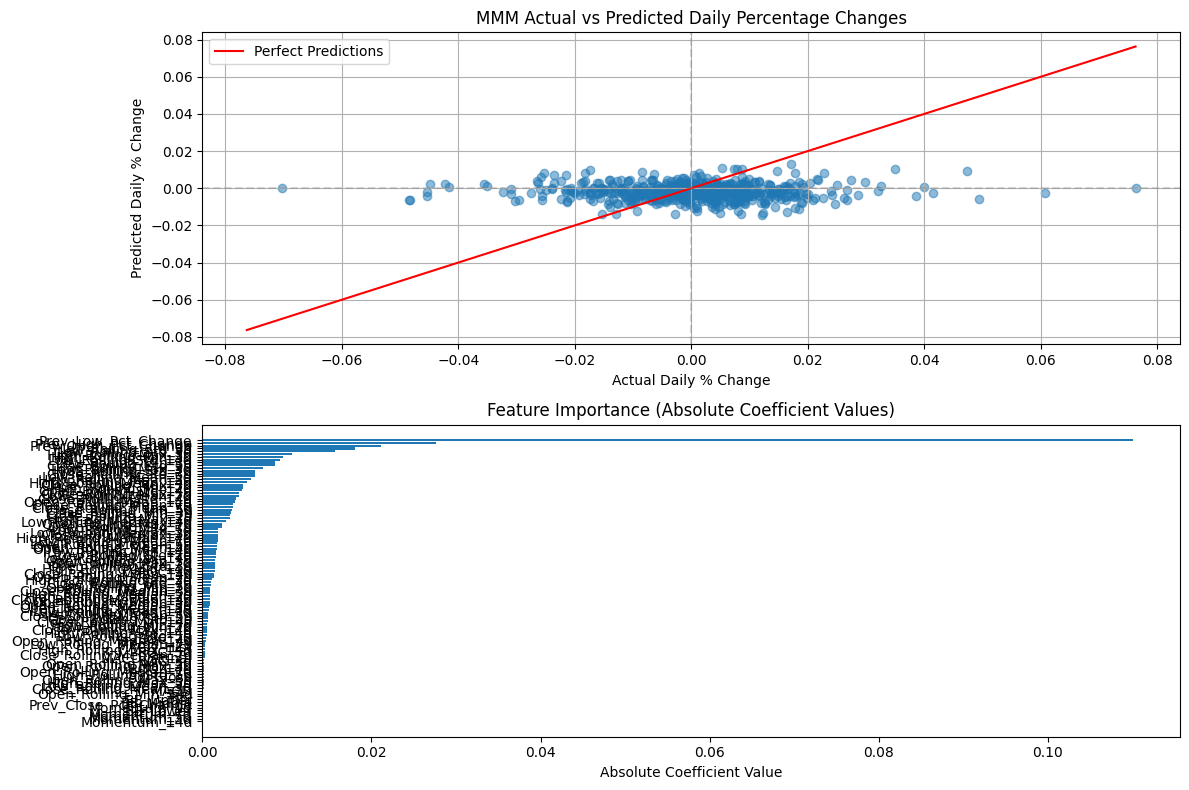

In [15]:
def debug_check_nans(df, stage_name):
    """Helper function to debug NaN values"""
    nan_cols = df.columns[df.isna().any()].tolist()
    if nan_cols:
        print(f"\nNaN values found at {stage_name} in columns:")
        for col in nan_cols:
            nan_count = df[col].isna().sum()
            print(f"- {col}: {nan_count} NaN values")
        print(f"Total rows: {len(df)}")
    return len(nan_cols) > 0

# Example usage:
if __name__ == "__main__":
    # Get stock data and create features
    symbol = 'MMM'
    symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    # Check for NaNs in original data
    has_nans = debug_check_nans(symbol_df, "original data")
    if has_nans:
        print("Warning: NaN values found in original data")

    # Engineer features
    feature_df = engineer_features(symbol_df)

    # Check for NaNs after feature engineering
    has_nans = debug_check_nans(feature_df, "after feature engineering")
    if has_nans:
        print("Warning: NaN values found after feature engineering")

    # Get feature matrix and target
    X, y = prepare_model_data(feature_df)

    # Check for NaNs in model data
    has_nans = debug_check_nans(X, "feature matrix X")
    if has_nans:
        print("Warning: NaN values found in feature matrix")

    # Split data
    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
        feature_df,
        X.columns
    )

    # Check for NaNs in training data
    has_nans = debug_check_nans(X_train, "training features")
    if has_nans:
        print("Warning: NaN values found in training data")

    # Train and evaluate model
    lr, validation_df, metrics = train_and_evaluate_model(
        X_train,
        y_train,
        X_val,
        y_val,
        X.columns,
        symbol
    )

    # Plot analysis
    plot_validation_analysis(
        validation_df,
        y_val,
        validation_df['Predicted_Pct_Change'],
        X.columns,
        lr,
        symbol
    )

# Version 7

In [16]:
import pandas as pd
import numpy as np
from typing import List

def calculate_rolling_stats_selected(data: pd.Series, name: str) -> dict:
    """Calculate only the selected rolling statistics"""
    features = {}

    # 3-day features
    rolling_3d = data.rolling(window=3)
    features.update({
        f'{name}_Rolling_Std_3d': rolling_3d.std(),
        f'{name}_Rolling_Min_3d': rolling_3d.min(),
        f'{name}_Rolling_Max_3d': rolling_3d.max()
    })

    # 5-day features
    rolling_5d = data.rolling(window=5)
    features.update({
        f'{name}_Rolling_Mean_5d': rolling_5d.mean(),
        f'{name}_Rolling_Std_5d': rolling_5d.std()
    })

    # 7-day features
    rolling_7d = data.rolling(window=7)
    features.update({
        f'{name}_Rolling_Std_7d': rolling_7d.std()
    })

    # 14-day features
    rolling_14d = data.rolling(window=14)
    features.update({
        f'{name}_Rolling_Mean_14d': rolling_14d.mean(),
        f'{name}_Rolling_Std_14d': rolling_14d.std()
    })

    return features

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create selected technical features for the stock data"""
    print(f"Initial DataFrame shape: {df.shape}")

    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for price columns
    for column in ['Close', 'Open', 'High', 'Low']:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Calculate selected rolling stats for High, Low, Close
    for column in ['High', 'Low', 'Close']:
        stats = calculate_rolling_stats_selected(df[column], column)
        for stat_key, stat_value in stats.items():
            result[stat_key] = stat_value

    # Create DataFrame with all features
    print(f"\nDataFrame shape after adding features: {result.shape}")

    # Calculate target
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)

    # Drop rows with NaN values and verify
    result_cleaned = result.dropna()
    print(f"\nFinal DataFrame shape after dropping NaNs: {result_cleaned.shape}")

    if len(result_cleaned) == 0:
        raise ValueError("All rows were dropped due to NaN values. Check the debugging output above.")

    return result_cleaned

def prepare_model_data(df: pd.DataFrame) -> tuple:
    """Prepare feature matrix X and target vector y for modeling"""
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Symbol',
        'Close',
        'Date',
        'Volume',
        'Open',
        'High',
        'Low',
        'Adj Close'
    ]

    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']

    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")

    return X, y

def split_time_series_data(df, feature_columns, target_column='Next_Close_Pct_Change',
                          train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets chronologically"""
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def train_and_evaluate_model(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train model and evaluate performance"""
    # Train model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Make predictions
    validation_preds = lr.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df['Actual_Direction'] = np.where(validation_df['Actual_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Predicted_Direction'] = np.where(validation_df['Predicted_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    print("\nDirectional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    confusion = pd.crosstab(validation_df['Actual_Direction'],
                           validation_df['Predicted_Direction'],
                           margins=True)
    print("\nDirectional Prediction Confusion Matrix:")
    print(confusion)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    return lr, validation_df, metrics

Initial DataFrame shape: (3718, 7)

DataFrame shape after adding features: (3718, 35)

Final DataFrame shape after dropping NaNs: (3704, 36)

Feature matrix shape: (3704, 28)
Target vector shape: (3704,)
Training set: 2592 samples (2010-01-22 00:00:00 to 2020-05-08 00:00:00)
Validation set: 556 samples (2020-05-11 00:00:00 to 2022-07-25 00:00:00)
Test set: 556 samples (2022-07-26 00:00:00 to 2024-10-09 00:00:00)

Directional Prediction Analysis:
Directional Accuracy: 45.86%

Directional Prediction Confusion Matrix:
Predicted_Direction  Down   Up  All
Actual_Direction                   
Down                  116  150  266
Up                    151  139  290
All                   267  289  556

Validation Metrics (for percent changes):
MSE: 0.0002 (mean squared error in percentage points)
R²: -0.0665
MAE: 0.0109 (mean absolute error in percentage points)


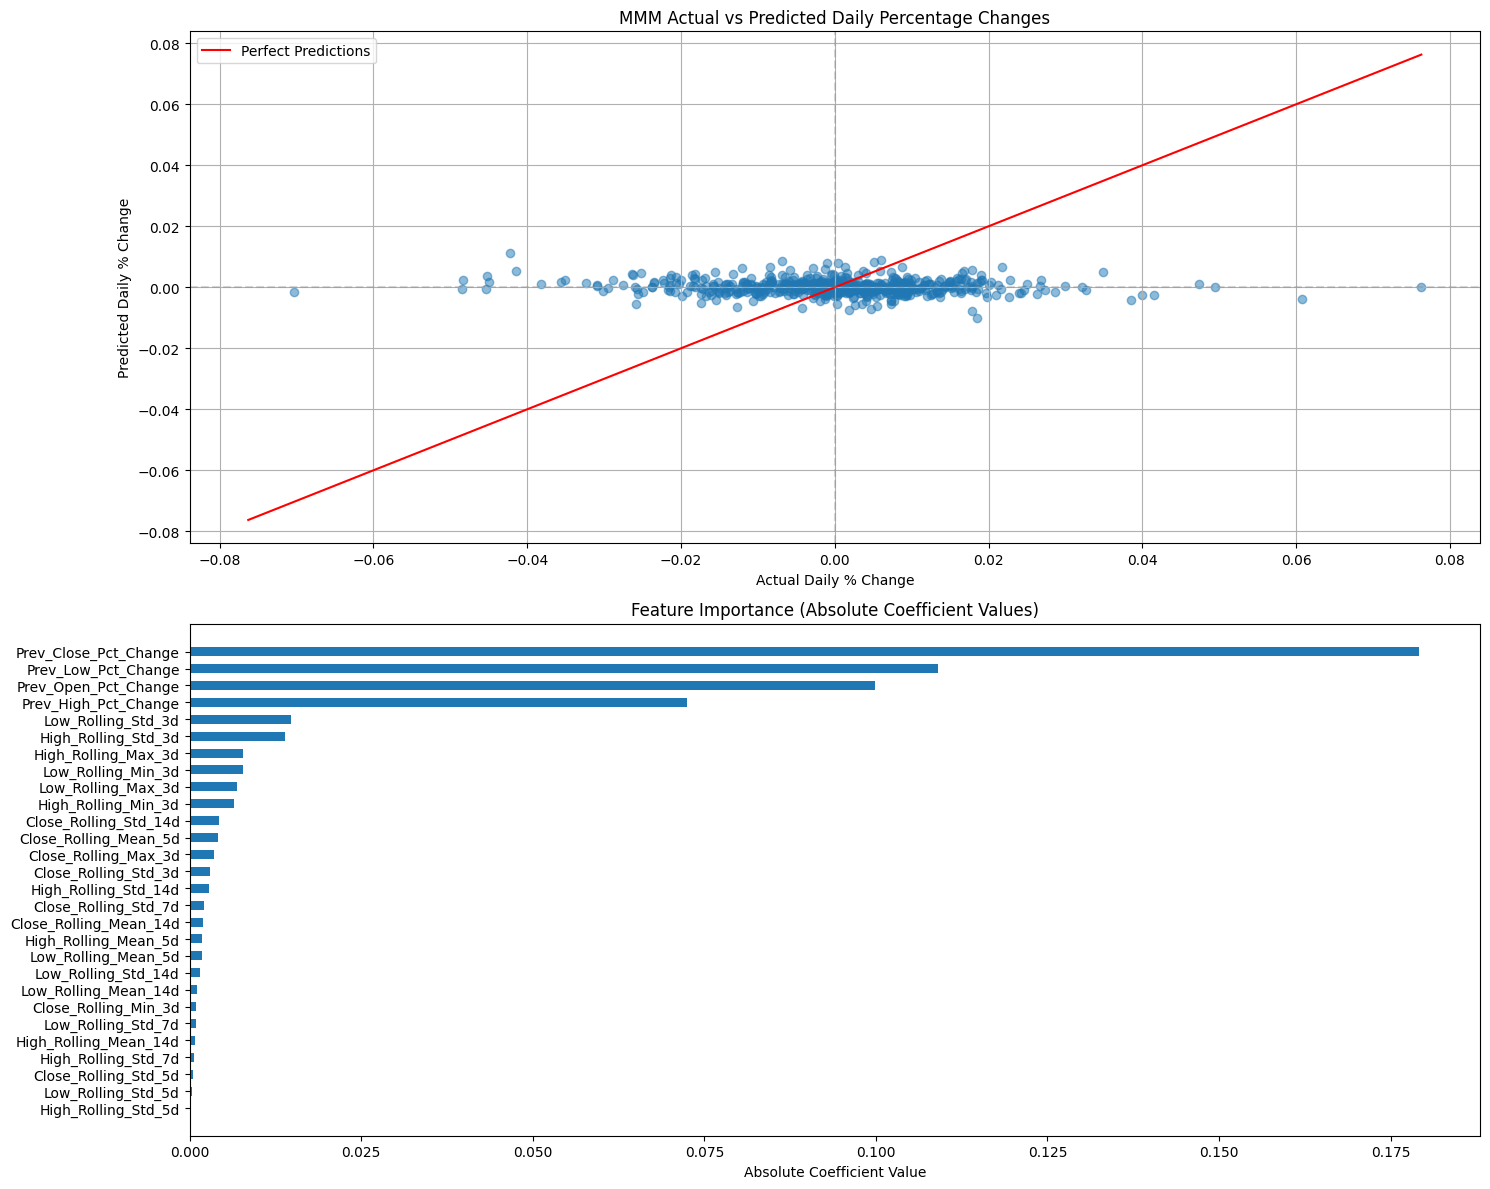


Feature Importance Values (sorted):
High_Rolling_Std_5d: 0.000261
Low_Rolling_Std_5d: 0.000327
Close_Rolling_Std_5d: 0.000531
High_Rolling_Std_7d: 0.000666
High_Rolling_Mean_14d: 0.000845
Low_Rolling_Std_7d: 0.000946
Close_Rolling_Min_3d: 0.001005
Low_Rolling_Mean_14d: 0.001030
Low_Rolling_Std_14d: 0.001514
Low_Rolling_Mean_5d: 0.001797
High_Rolling_Mean_5d: 0.001878
Close_Rolling_Mean_14d: 0.002008
Close_Rolling_Std_7d: 0.002125
High_Rolling_Std_14d: 0.002757
Close_Rolling_Std_3d: 0.003045
Close_Rolling_Max_3d: 0.003556
Close_Rolling_Mean_5d: 0.004128
Close_Rolling_Std_14d: 0.004287
High_Rolling_Min_3d: 0.006406
Low_Rolling_Max_3d: 0.006857
Low_Rolling_Min_3d: 0.007719
High_Rolling_Max_3d: 0.007783
High_Rolling_Std_3d: 0.013946
Low_Rolling_Std_3d: 0.014768
Prev_High_Pct_Change: 0.072484
Prev_Open_Pct_Change: 0.099835
Prev_Low_Pct_Change: 0.109066
Prev_Close_Pct_Change: 0.179069


In [17]:
# Get stock data and create features
symbol = 'MMM'
symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
symbol_df.set_index('Date', inplace=True)

# Engineer features
feature_df = engineer_features(symbol_df)

# Get feature matrix and target
X, y = prepare_model_data(feature_df)

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
    feature_df,
    X.columns
)

# Train and evaluate model
lr, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_val,
    y_val,
    X.columns,
    symbol
)

# Plot validation analysis
plt.figure(figsize=(15, 12))

# Scatter plot
plt.subplot(2, 1, 1)
plt.scatter(validation_df['Actual_Pct_Change'],
            validation_df['Predicted_Pct_Change'],
            alpha=0.5)

max_val = max(
    abs(validation_df['Actual_Pct_Change'].max()),
    abs(validation_df['Actual_Pct_Change'].min()),
    abs(validation_df['Predicted_Pct_Change'].max()),
    abs(validation_df['Predicted_Pct_Change'].min())
)

plt.plot([-max_val, max_val], [-max_val, max_val],
         color='red', label='Perfect Predictions')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.xlabel('Actual Daily % Change')
plt.ylabel('Predicted Daily % Change')
plt.title(f'{symbol} Actual vs Predicted Daily Percentage Changes')
plt.legend()
plt.grid(True)

# Feature importance plot
plt.subplot(2, 1, 2)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(lr.coef_)
}).sort_values('Importance', ascending=True)

y_pos = np.arange(len(importance_df)) * 1.5
plt.barh(y_pos, importance_df['Importance'], height=0.8)
plt.yticks(y_pos, importance_df['Feature'], fontsize=10)
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.tight_layout()
plt.show()

# Print feature importance values
print("\nFeature Importance Values (sorted):")
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.6f}")

# SWITCH TO XGBoost VERSION 1 USING VERSION 6 FEATURES

Initial DataFrame shape: (3718, 7)

DataFrame shape after adding features: (3718, 35)

Final DataFrame shape after dropping NaNs: (3704, 36)

Feature matrix shape: (3704, 28)
Target vector shape: (3704,)
Training set: 2592 samples (2010-01-22 00:00:00 to 2020-05-08 00:00:00)
Validation set: 556 samples (2020-05-11 00:00:00 to 2022-07-25 00:00:00)
Test set: 556 samples (2022-07-26 00:00:00 to 2024-10-09 00:00:00)

Directional Prediction Analysis:
Directional Accuracy: 51.08%

Directional Prediction Confusion Matrix:
Predicted_Direction  Down   Up  All
Actual_Direction                   
Down                  121  145  266
Up                    127  163  290
All                   248  308  556

Validation Metrics (for percent changes):
MSE: 0.0002 (mean squared error in percentage points)
R²: -0.0700
MAE: 0.0109 (mean absolute error in percentage points)


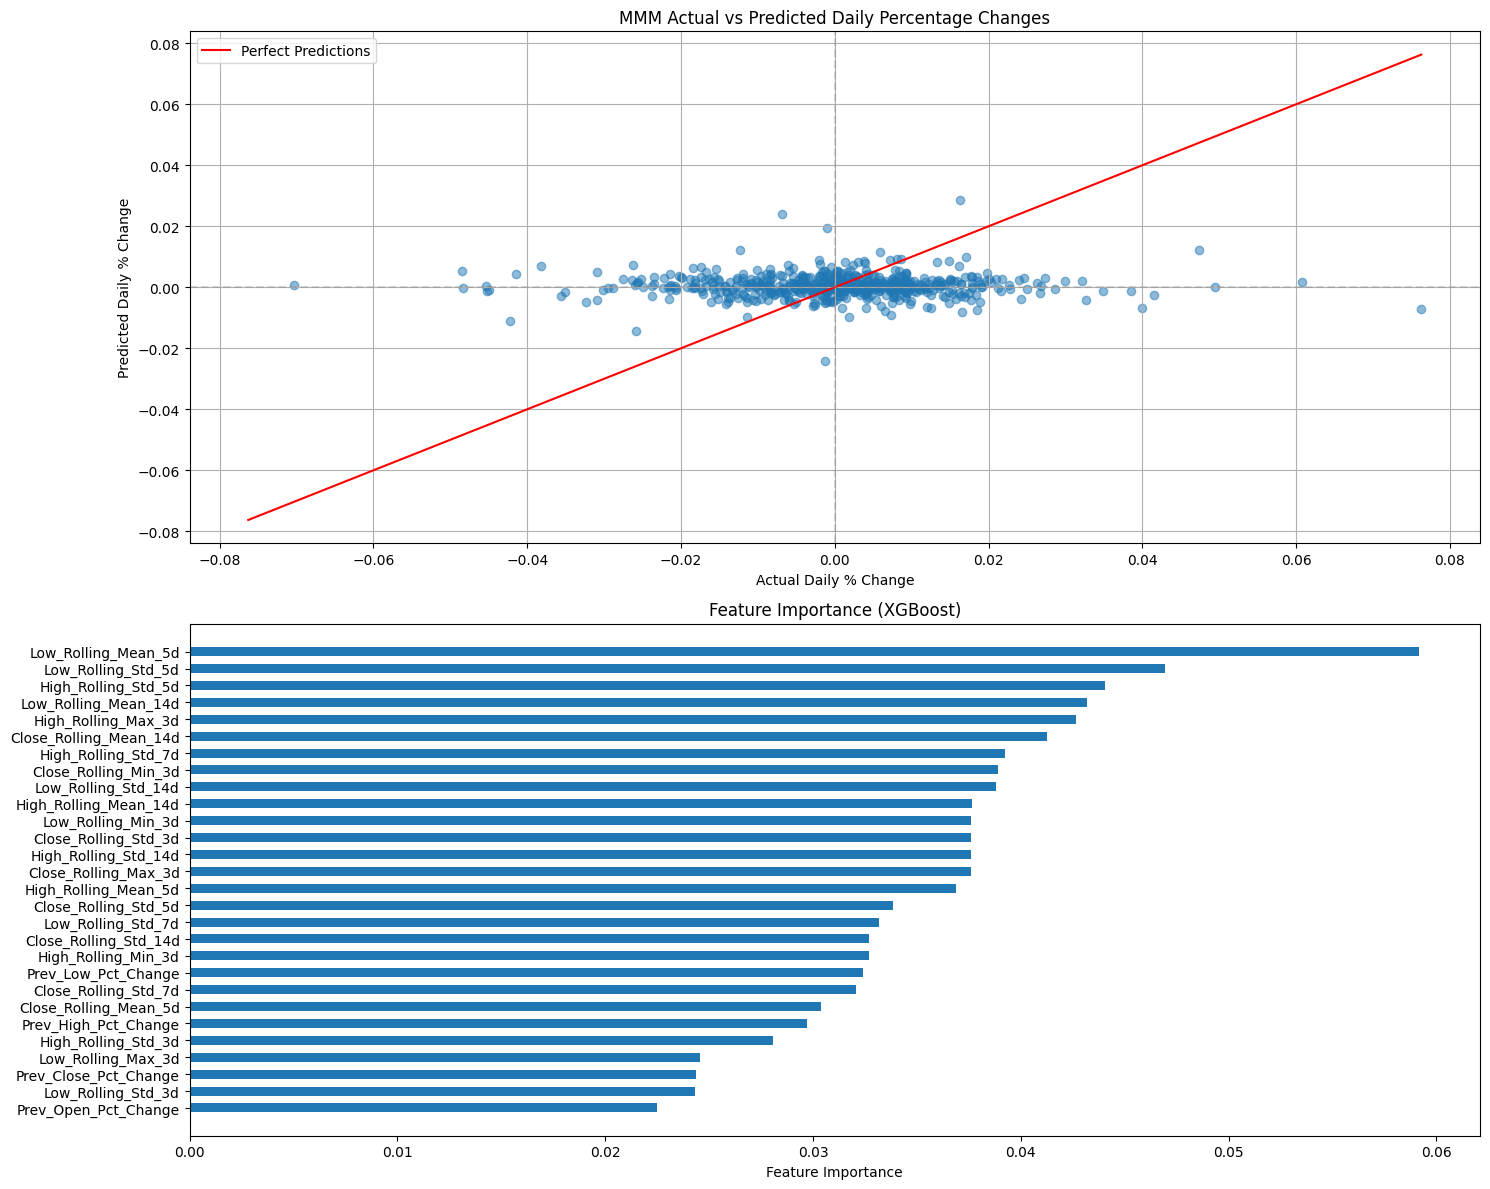


Feature Importance Values (sorted):
Prev_Open_Pct_Change: 0.022500
Low_Rolling_Std_3d: 0.024343
Prev_Close_Pct_Change: 0.024374
Low_Rolling_Max_3d: 0.024551
High_Rolling_Std_3d: 0.028054
Prev_High_Pct_Change: 0.029729
Close_Rolling_Mean_5d: 0.030408
Close_Rolling_Std_7d: 0.032069
Prev_Low_Pct_Change: 0.032384
High_Rolling_Min_3d: 0.032675
Close_Rolling_Std_14d: 0.032706
Low_Rolling_Std_7d: 0.033173
Close_Rolling_Std_5d: 0.033854
High_Rolling_Mean_5d: 0.036877
Close_Rolling_Max_3d: 0.037594
High_Rolling_Std_14d: 0.037615
Close_Rolling_Std_3d: 0.037624
Low_Rolling_Min_3d: 0.037626
High_Rolling_Mean_14d: 0.037650
Low_Rolling_Std_14d: 0.038820
Close_Rolling_Min_3d: 0.038926
High_Rolling_Std_7d: 0.039217
Close_Rolling_Mean_14d: 0.041256
High_Rolling_Max_3d: 0.042658
Low_Rolling_Mean_14d: 0.043194
High_Rolling_Std_5d: 0.044033
Low_Rolling_Std_5d: 0.046947
Low_Rolling_Mean_5d: 0.059141


In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def split_time_series_data(df, feature_columns, target_column='Next_Close_Pct_Change',
                          train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets chronologically"""
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def train_and_evaluate_model(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train XGBoost model and evaluate performance"""
    # Initialize XGBoost model with parameters
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    # Train model
    xgb.fit(X_train, y_train)

    # Make predictions
    validation_preds = xgb.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df['Actual_Direction'] = np.where(validation_df['Actual_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Predicted_Direction'] = np.where(validation_df['Predicted_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    print("\nDirectional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    confusion = pd.crosstab(validation_df['Actual_Direction'],
                           validation_df['Predicted_Direction'],
                           margins=True)
    print("\nDirectional Prediction Confusion Matrix:")
    print(confusion)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    return xgb, validation_df, metrics

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, model, symbol):
    """Create validation analysis plots"""
    plt.figure(figsize=(15, 12))

    # Scatter plot
    plt.subplot(2, 1, 1)
    plt.scatter(validation_df['Actual_Pct_Change'],
                validation_df['Predicted_Pct_Change'],
                alpha=0.5)

    max_val = max(
        abs(validation_df['Actual_Pct_Change'].max()),
        abs(validation_df['Actual_Pct_Change'].min()),
        abs(validation_df['Predicted_Pct_Change'].max()),
        abs(validation_df['Predicted_Pct_Change'].min())
    )

    plt.plot([-max_val, max_val], [-max_val, max_val],
             color='red', label='Perfect Predictions')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.xlabel('Actual Daily % Change')
    plt.ylabel('Predicted Daily % Change')
    plt.title(f'{symbol} Actual vs Predicted Daily Percentage Changes')
    plt.legend()
    plt.grid(True)

    # Feature importance plot
    plt.subplot(2, 1, 2)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=True)

    y_pos = np.arange(len(importance_df)) * 1.5
    plt.barh(y_pos, importance_df['Importance'], height=0.8)
    plt.yticks(y_pos, importance_df['Feature'], fontsize=10)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (XGBoost)')
    plt.tight_layout()
    plt.show()

    # Print feature importance values
    print("\nFeature Importance Values (sorted):")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.6f}")

# Run the model
symbol = 'MMM'
symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
symbol_df.set_index('Date', inplace=True)

# Engineer features
feature_df = engineer_features(symbol_df)

# Get feature matrix and target
X, y = prepare_model_data(feature_df)

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
    feature_df,
    X.columns
)

# Train and evaluate model
xgb_model, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_val,
    y_val,
    X.columns,
    symbol
)

# Plot validation analysis
plot_validation_analysis(
    validation_df,
    y_val,
    validation_df['Predicted_Pct_Change'],
    X.columns,
    xgb_model,
    symbol
)

# Random Forest V1

Initial DataFrame shape: (3718, 7)

DataFrame shape after adding features: (3718, 35)

Final DataFrame shape after dropping NaNs: (3704, 36)

Feature matrix shape: (3704, 28)
Target vector shape: (3704,)
Training set: 2592 samples (2010-01-22 00:00:00 to 2020-05-08 00:00:00)
Validation set: 556 samples (2020-05-11 00:00:00 to 2022-07-25 00:00:00)
Test set: 556 samples (2022-07-26 00:00:00 to 2024-10-09 00:00:00)

Directional Prediction Analysis:
Directional Accuracy: 51.08%

Prediction Magnitude Analysis:
Actual range: [-0.0703, 0.0763]
Predicted range: [-0.0228, 0.0109]

Directional Prediction Confusion Matrix:
Predicted_Direction  Down   Up  All
Actual_Direction                   
Down                   70  196  266
Up                     76  214  290
All                   146  410  556

Validation Metrics (for percent changes):
MSE: 0.0002 (mean squared error in percentage points)
R²: -0.0184
MAE: 0.0106 (mean absolute error in percentage points)

Standard Deviation Analysis:
Actual

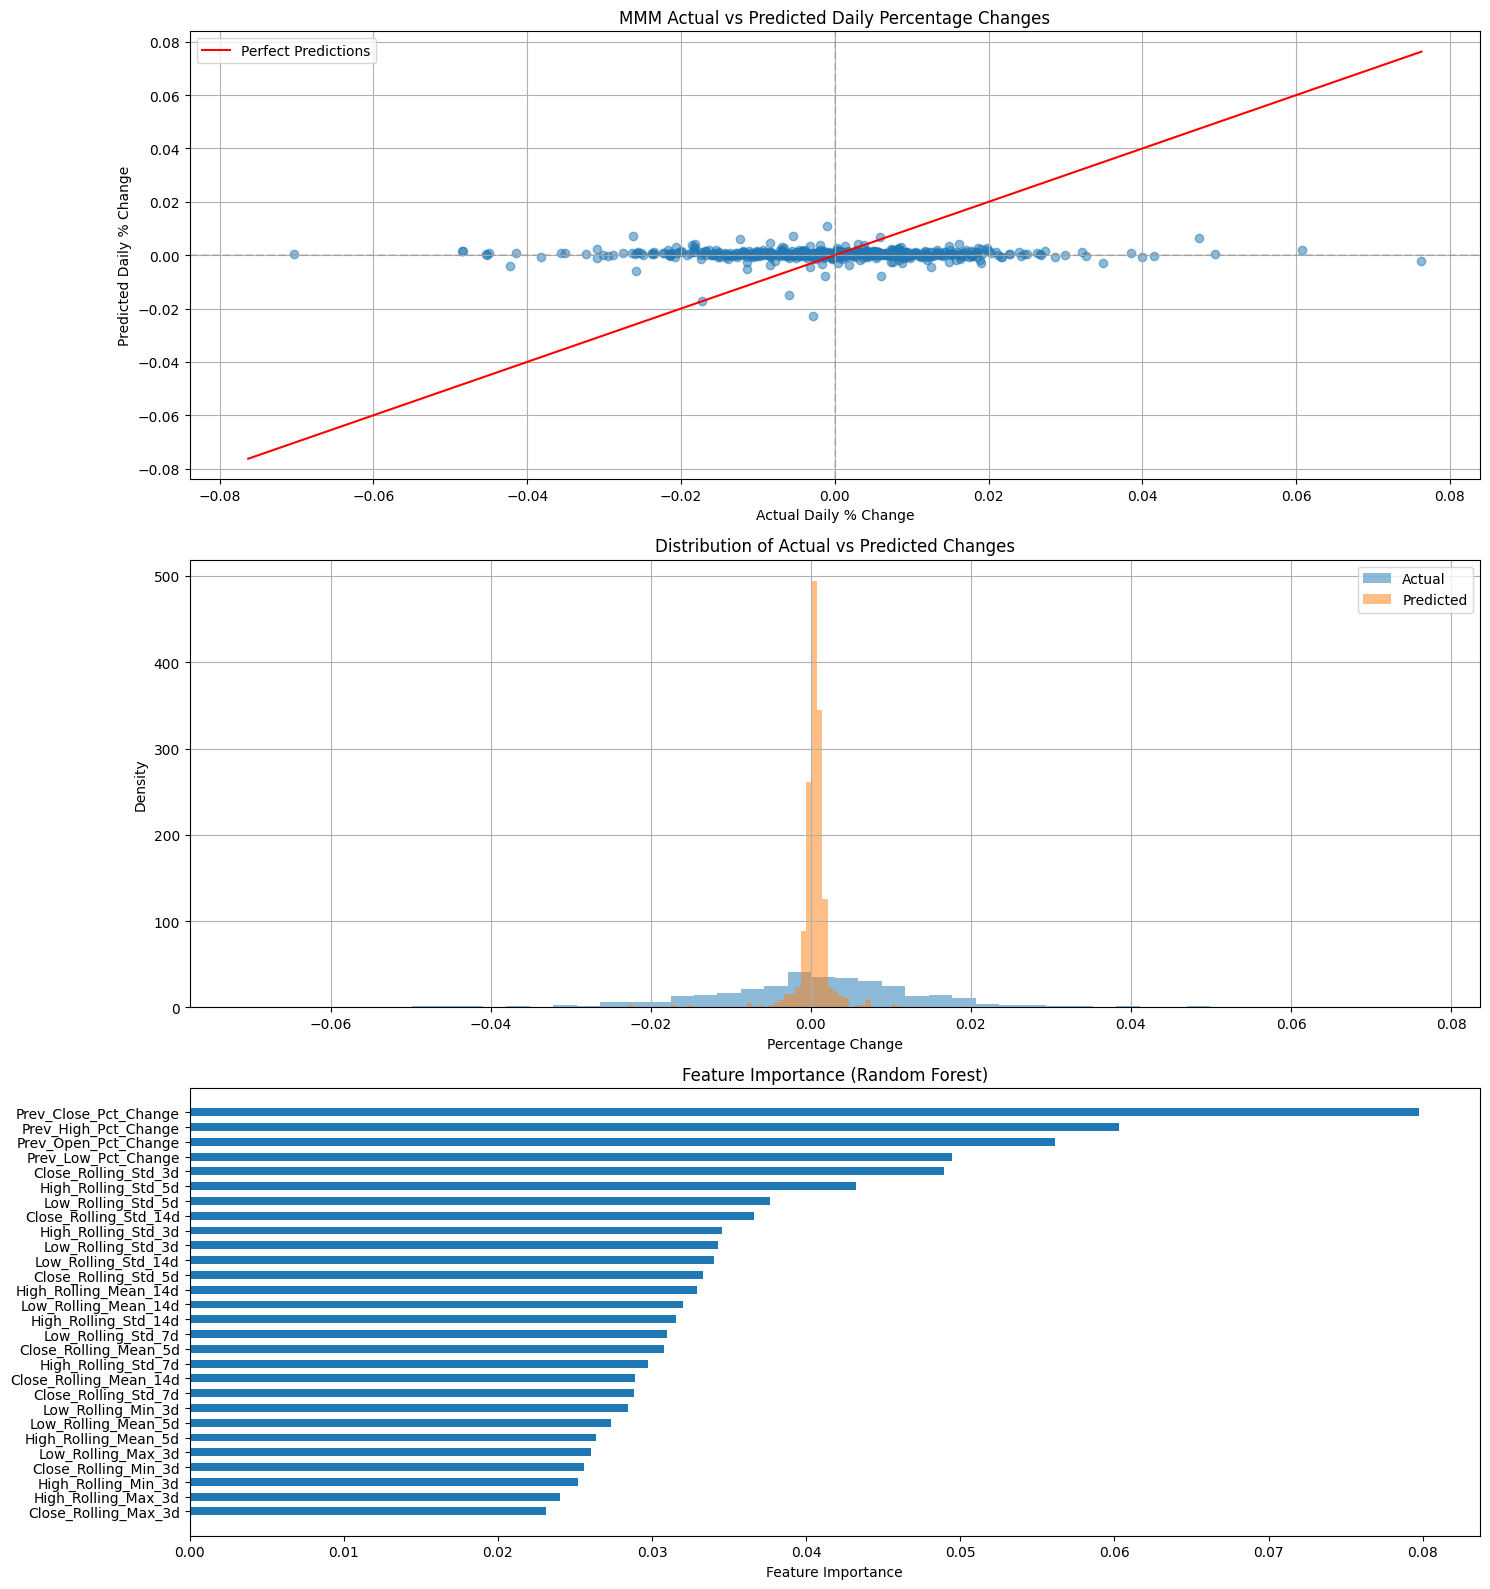


Feature Importance Values (sorted):
Close_Rolling_Max_3d: 0.023140
High_Rolling_Max_3d: 0.024020
High_Rolling_Min_3d: 0.025211
Close_Rolling_Min_3d: 0.025587
Low_Rolling_Max_3d: 0.026051
High_Rolling_Mean_5d: 0.026349
Low_Rolling_Mean_5d: 0.027345
Low_Rolling_Min_3d: 0.028440
Close_Rolling_Std_7d: 0.028821
Close_Rolling_Mean_14d: 0.028877
High_Rolling_Std_7d: 0.029722
Close_Rolling_Mean_5d: 0.030809
Low_Rolling_Std_7d: 0.030978
High_Rolling_Std_14d: 0.031527
Low_Rolling_Mean_14d: 0.031994
High_Rolling_Mean_14d: 0.032907
Close_Rolling_Std_5d: 0.033285
Low_Rolling_Std_14d: 0.034028
Low_Rolling_Std_3d: 0.034262
High_Rolling_Std_3d: 0.034527
Close_Rolling_Std_14d: 0.036628
Low_Rolling_Std_5d: 0.037636
High_Rolling_Std_5d: 0.043265
Close_Rolling_Std_3d: 0.048955
Prev_Low_Pct_Change: 0.049466
Prev_Open_Pct_Change: 0.056170
Prev_High_Pct_Change: 0.060266
Prev_Close_Pct_Change: 0.079730


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def train_and_evaluate_model(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train Random Forest model with modified parameters for more varied predictions"""
    # Initialize Random Forest model with adjusted parameters
    rf = RandomForestRegressor(
        n_estimators=200,          # More trees
        max_depth=15,              # Deeper trees
        min_samples_split=2,       # More aggressive splitting
        min_samples_leaf=1,        # Allow smaller leaf nodes
        max_features='sqrt',       # Traditional RF feature selection
        bootstrap=True,            # Enable bootstrapping
        random_state=42,
        n_jobs=-1                  # Use all CPU cores
    )

    # Calculate sample weights to emphasize larger price movements
    train_weights = 1 + 2 * np.abs(y_train)  # Weight increases with magnitude of price change

    # Train model with sample weights
    rf.fit(X_train, y_train, sample_weight=train_weights)

    # Make predictions
    validation_preds = rf.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df['Actual_Direction'] = np.where(validation_df['Actual_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Predicted_Direction'] = np.where(validation_df['Predicted_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    print("\nDirectional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    # Add magnitude analysis
    print("\nPrediction Magnitude Analysis:")
    print(f"Actual range: [{y_val.min():.4f}, {y_val.max():.4f}]")
    print(f"Predicted range: [{validation_preds.min():.4f}, {validation_preds.max():.4f}]")

    confusion = pd.crosstab(validation_df['Actual_Direction'],
                           validation_df['Predicted_Direction'],
                           margins=True)
    print("\nDirectional Prediction Confusion Matrix:")
    print(confusion)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    # Additional analysis of prediction distribution
    actual_std = y_val.std()
    pred_std = validation_preds.std()
    print(f"\nStandard Deviation Analysis:")
    print(f"Actual price changes std: {actual_std:.4f}")
    print(f"Predicted changes std: {pred_std:.4f}")
    print(f"Std ratio (pred/actual): {pred_std/actual_std:.4f}")

    return rf, validation_df, metrics

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, model, symbol):
    """Enhanced validation analysis plots"""
    plt.figure(figsize=(15, 16))

    # Scatter plot
    plt.subplot(3, 1, 1)
    plt.scatter(validation_df['Actual_Pct_Change'],
                validation_df['Predicted_Pct_Change'],
                alpha=0.5)

    max_val = max(
        abs(validation_df['Actual_Pct_Change'].max()),
        abs(validation_df['Actual_Pct_Change'].min()),
        abs(validation_df['Predicted_Pct_Change'].max()),
        abs(validation_df['Predicted_Pct_Change'].min())
    )

    plt.plot([-max_val, max_val], [-max_val, max_val],
             color='red', label='Perfect Predictions')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.xlabel('Actual Daily % Change')
    plt.ylabel('Predicted Daily % Change')
    plt.title(f'{symbol} Actual vs Predicted Daily Percentage Changes')
    plt.legend()
    plt.grid(True)

    # Distribution comparison plot
    plt.subplot(3, 1, 2)
    plt.hist(validation_df['Actual_Pct_Change'], bins=50, alpha=0.5, label='Actual', density=True)
    plt.hist(validation_df['Predicted_Pct_Change'], bins=50, alpha=0.5, label='Predicted', density=True)
    plt.xlabel('Percentage Change')
    plt.ylabel('Density')
    plt.title('Distribution of Actual vs Predicted Changes')
    plt.legend()
    plt.grid(True)

    # Feature importance plot
    plt.subplot(3, 1, 3)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=True)

    y_pos = np.arange(len(importance_df)) * 1.5
    plt.barh(y_pos, importance_df['Importance'], height=0.8)
    plt.yticks(y_pos, importance_df['Feature'], fontsize=10)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

    # Print feature importance values
    print("\nFeature Importance Values (sorted):")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.6f}")

# Run the model with existing data
symbol = 'MMM'
symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
symbol_df.set_index('Date', inplace=True)

# Engineer features
feature_df = engineer_features(symbol_df)

# Get feature matrix and target
X, y = prepare_model_data(feature_df)

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
    feature_df,
    X.columns
)

# Train and evaluate model
rf_model, validation_df, metrics = train_and_evaluate_model(
    X_train,
    y_train,
    X_val,
    y_val,
    X.columns,
    symbol
)

# Plot validation analysis
plot_validation_analysis(
    validation_df,
    y_val,
    validation_df['Predicted_Pct_Change'],
    X.columns,
    rf_model,
    symbol
)

# Version 10

Initial DataFrame shape: (3718, 7)

Final DataFrame shape after dropping NaNs: (3710, 36)

Feature matrix shape: (3710, 28)
Target vector shape: (3710,)
Training set: 2597 samples (2010-01-13 00:00:00 to 2020-05-07 00:00:00)
Validation set: 556 samples (2020-05-08 00:00:00 to 2022-07-22 00:00:00)
Test set: 557 samples (2022-07-25 00:00:00 to 2024-10-09 00:00:00)

XGBoost Directional Prediction Analysis:
Directional Accuracy: 49.10%

Directional Prediction Confusion Matrix:
Predicted_Direction  Down   Up  All
Actual_Direction                   
Down                  116  151  267
Up                    132  157  289
All                   248  308  556

Validation Metrics (for percent changes):
MSE: 0.0002 (mean squared error in percentage points)
R²: -0.0672
MAE: 0.0108 (mean absolute error in percentage points)


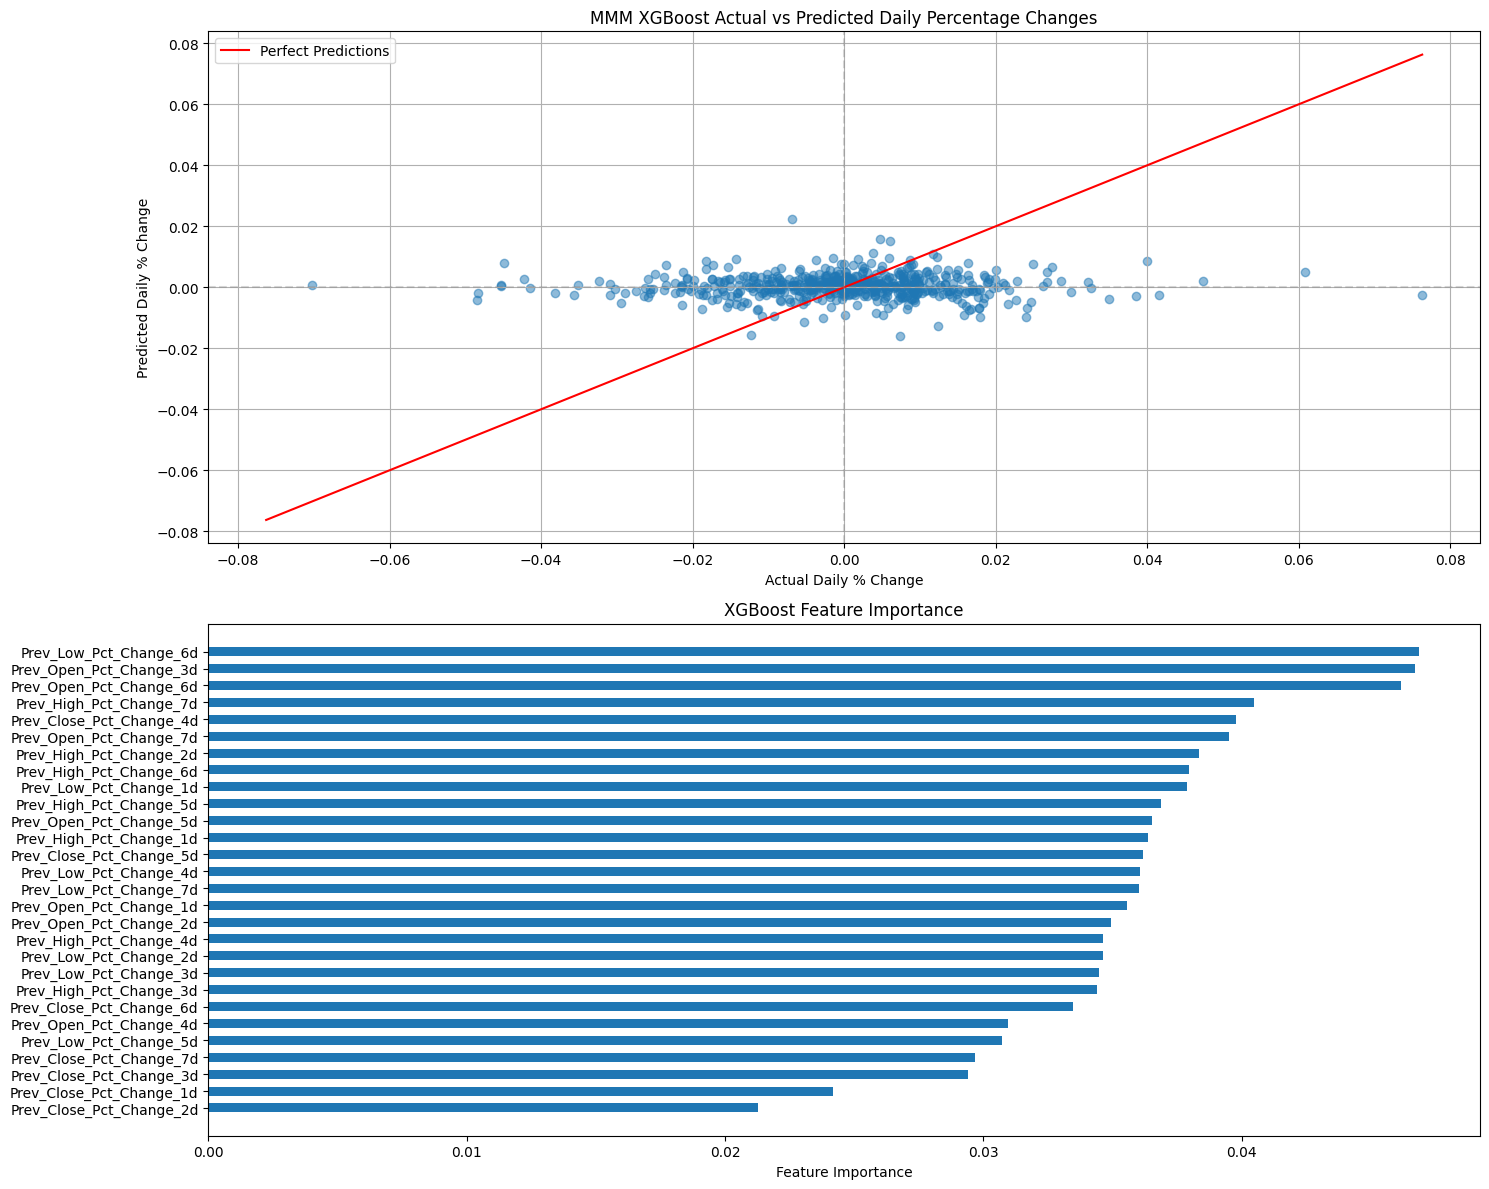


XGBoost Feature Importance Values (sorted):
Prev_Close_Pct_Change_2d: 0.021258
Prev_Close_Pct_Change_1d: 0.024179
Prev_Close_Pct_Change_3d: 0.029405
Prev_Close_Pct_Change_7d: 0.029682
Prev_Low_Pct_Change_5d: 0.030729
Prev_Open_Pct_Change_4d: 0.030957
Prev_Close_Pct_Change_6d: 0.033478
Prev_High_Pct_Change_3d: 0.034384
Prev_Low_Pct_Change_3d: 0.034474
Prev_Low_Pct_Change_2d: 0.034644
Prev_High_Pct_Change_4d: 0.034645
Prev_Open_Pct_Change_2d: 0.034934
Prev_Open_Pct_Change_1d: 0.035539
Prev_Low_Pct_Change_7d: 0.036017
Prev_Low_Pct_Change_4d: 0.036062
Prev_Close_Pct_Change_5d: 0.036190
Prev_High_Pct_Change_1d: 0.036361
Prev_Open_Pct_Change_5d: 0.036535
Prev_High_Pct_Change_5d: 0.036863
Prev_Low_Pct_Change_1d: 0.037868
Prev_High_Pct_Change_6d: 0.037969
Prev_High_Pct_Change_2d: 0.038350
Prev_Open_Pct_Change_7d: 0.039521
Prev_Close_Pct_Change_4d: 0.039760
Prev_High_Pct_Change_7d: 0.040465
Prev_Open_Pct_Change_6d: 0.046144
Prev_Open_Pct_Change_3d: 0.046709
Prev_Low_Pct_Change_6d: 0.046876
Ini

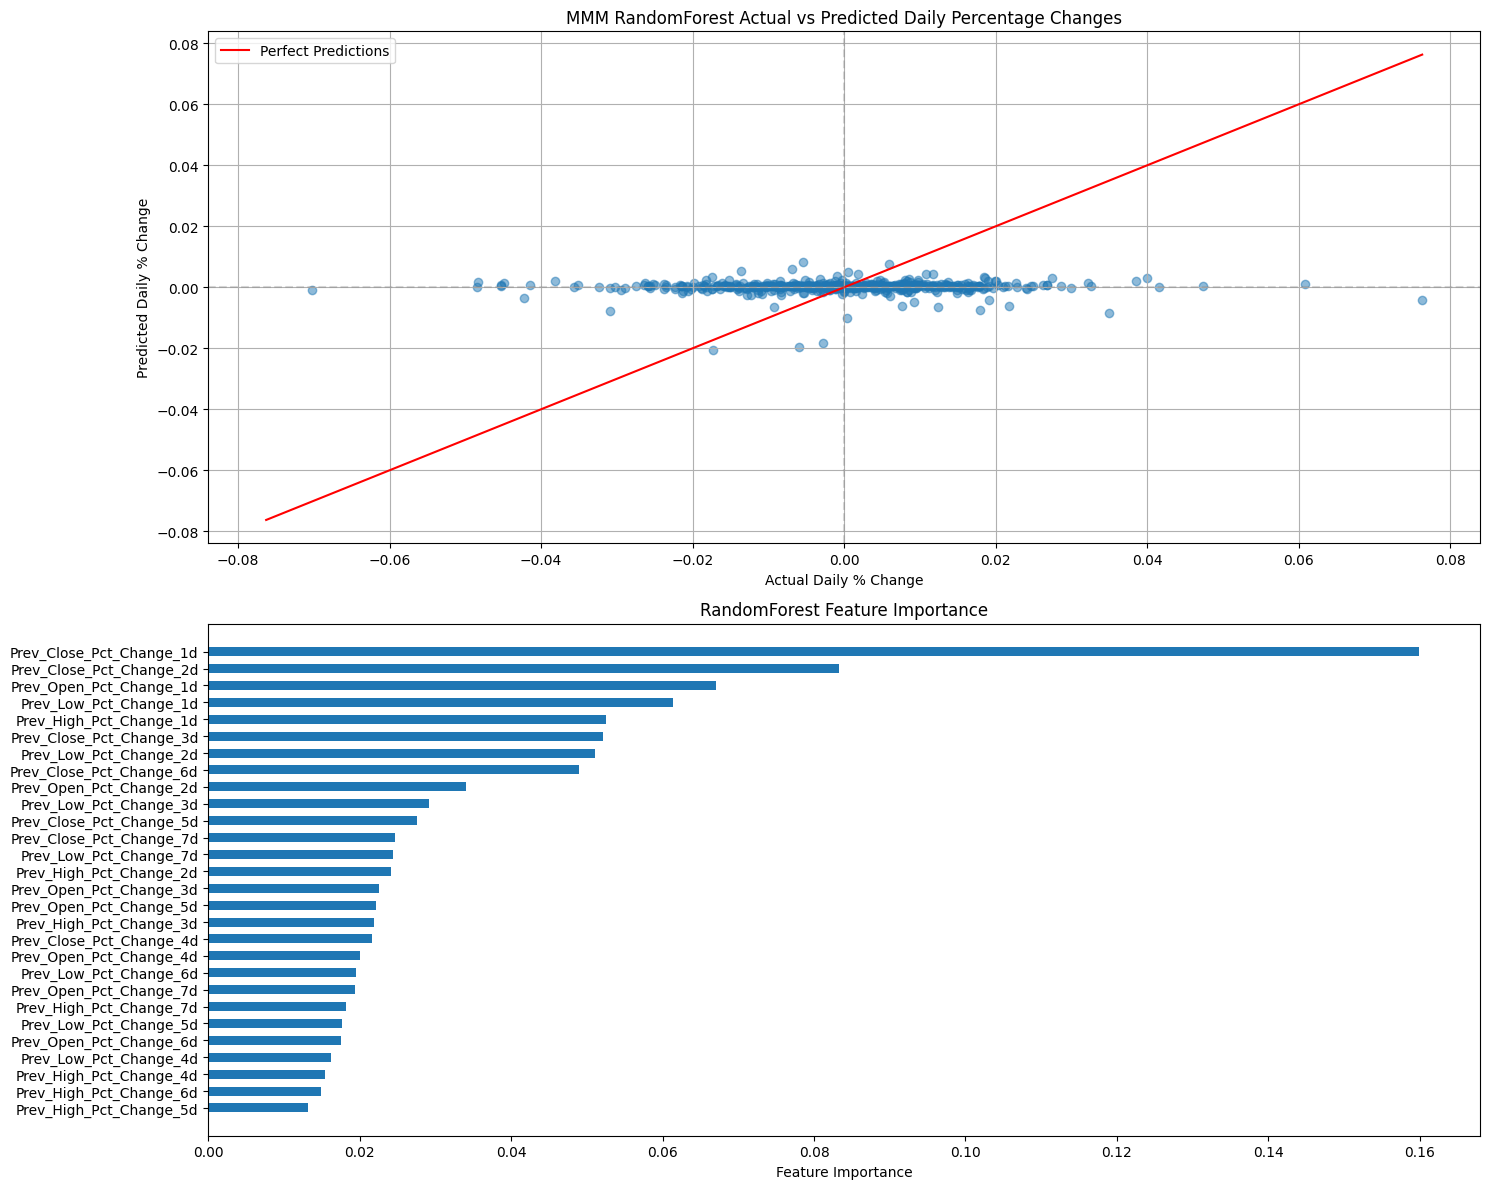


RandomForest Feature Importance Values (sorted):
Prev_High_Pct_Change_5d: 0.013109
Prev_High_Pct_Change_6d: 0.014867
Prev_High_Pct_Change_4d: 0.015402
Prev_Low_Pct_Change_4d: 0.016137
Prev_Open_Pct_Change_6d: 0.017568
Prev_Low_Pct_Change_5d: 0.017649
Prev_High_Pct_Change_7d: 0.018191
Prev_Open_Pct_Change_7d: 0.019371
Prev_Low_Pct_Change_6d: 0.019463
Prev_Open_Pct_Change_4d: 0.020059
Prev_Close_Pct_Change_4d: 0.021680
Prev_High_Pct_Change_3d: 0.021831
Prev_Open_Pct_Change_5d: 0.022141
Prev_Open_Pct_Change_3d: 0.022497
Prev_High_Pct_Change_2d: 0.024119
Prev_Low_Pct_Change_7d: 0.024417
Prev_Close_Pct_Change_7d: 0.024684
Prev_Close_Pct_Change_5d: 0.027583
Prev_Low_Pct_Change_3d: 0.029099
Prev_Open_Pct_Change_2d: 0.033966
Prev_Close_Pct_Change_6d: 0.048923
Prev_Low_Pct_Change_2d: 0.051019
Prev_Close_Pct_Change_3d: 0.052100
Prev_High_Pct_Change_1d: 0.052532
Prev_Low_Pct_Change_1d: 0.061314
Prev_Open_Pct_Change_1d: 0.067040
Prev_Close_Pct_Change_2d: 0.083274
Prev_Close_Pct_Change_1d: 0.15996

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create features using previous 7 days of percentage changes"""
    print(f"Initial DataFrame shape: {df.shape}")

    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for price columns
    price_columns = ['Close', 'Open', 'High', 'Low']

    # Add percentage changes for the last 7 days
    for column in price_columns:
        # Calculate percentage changes from 1 to 7 days ago
        for days in range(1, 8):
            result[f'Prev_{column}_Pct_Change_{days}d'] = df[column].pct_change(periods=days)

    # Calculate target (next day's closing price percentage change)
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)

    # Drop rows with NaN values
    result_cleaned = result.dropna()
    print(f"\nFinal DataFrame shape after dropping NaNs: {result_cleaned.shape}")

    if len(result_cleaned) == 0:
        raise ValueError("All rows were dropped due to NaN values.")

    return result_cleaned

def prepare_model_data(df: pd.DataFrame) -> tuple:
    """Prepare feature matrix X and target vector y for modeling"""
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Symbol',
        'Close',
        'Date',
        'Volume',
        'Open',
        'High',
        'Low',
        'Adj Close'
    ]

    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']

    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")

    return X, y

def split_time_series_data(df, feature_columns, target_column='Next_Close_Pct_Change',
                          train_size=0.7, val_size=0.15):
    """Split data into train, validation, and test sets chronologically"""
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def train_and_evaluate_xgboost(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train XGBoost model and evaluate performance"""
    # Initialize XGBoost model with parameters
    xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    # Train model
    xgb.fit(X_train, y_train)

    # Make predictions
    validation_preds = xgb.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df['Actual_Direction'] = np.where(validation_df['Actual_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Predicted_Direction'] = np.where(validation_df['Predicted_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    print("\nXGBoost Directional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    confusion = pd.crosstab(validation_df['Actual_Direction'],
                           validation_df['Predicted_Direction'],
                           margins=True)
    print("\nDirectional Prediction Confusion Matrix:")
    print(confusion)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    return xgb, validation_df, metrics

def train_and_evaluate_randomforest(X_train, y_train, X_val, y_val, feature_names, symbol):
    """Train Random Forest model and evaluate performance"""
    # Initialize Random Forest model
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    # Train model
    rf.fit(X_train, y_train)

    # Make predictions
    validation_preds = rf.predict(X_val)

    # Create validation DataFrame
    validation_df = pd.DataFrame(index=X_val.index)
    validation_df['Actual_Pct_Change'] = y_val
    validation_df['Predicted_Pct_Change'] = validation_preds

    # Add prediction analysis
    validation_df['Actual_Direction'] = np.where(validation_df['Actual_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Predicted_Direction'] = np.where(validation_df['Predicted_Pct_Change'] > 0, 'Up', 'Down')
    validation_df['Direction_Match'] = validation_df['Actual_Direction'] == validation_df['Predicted_Direction']
    directional_accuracy = validation_df['Direction_Match'].mean() * 100

    print("\nRandom Forest Directional Prediction Analysis:")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    confusion = pd.crosstab(validation_df['Actual_Direction'],
                           validation_df['Predicted_Direction'],
                           margins=True)
    print("\nDirectional Prediction Confusion Matrix:")
    print(confusion)

    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_val, validation_preds),
        'R2': r2_score(y_val, validation_preds),
        'MAE': mean_absolute_error(y_val, validation_preds)
    }

    print(f'\nValidation Metrics (for percent changes):')
    print(f'MSE: {metrics["MSE"]:.4f} (mean squared error in percentage points)')
    print(f'R²: {metrics["R2"]:.4f}')
    print(f'MAE: {metrics["MAE"]:.4f} (mean absolute error in percentage points)')

    return rf, validation_df, metrics

def plot_validation_analysis(validation_df, y_val, validation_preds, feature_names, model, symbol, model_type):
    """Create validation analysis plots"""
    plt.figure(figsize=(15, 12))

    # Scatter plot
    plt.subplot(2, 1, 1)
    plt.scatter(validation_df['Actual_Pct_Change'],
                validation_df['Predicted_Pct_Change'],
                alpha=0.5)

    max_val = max(
        abs(validation_df['Actual_Pct_Change'].max()),
        abs(validation_df['Actual_Pct_Change'].min()),
        abs(validation_df['Predicted_Pct_Change'].max()),
        abs(validation_df['Predicted_Pct_Change'].min())
    )

    plt.plot([-max_val, max_val], [-max_val, max_val],
             color='red', label='Perfect Predictions')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.xlabel('Actual Daily % Change')
    plt.ylabel('Predicted Daily % Change')
    plt.title(f'{symbol} {model_type} Actual vs Predicted Daily Percentage Changes')
    plt.legend()
    plt.grid(True)

    # Feature importance plot
    plt.subplot(2, 1, 2)

    # Determine feature importance based on model type
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
    else:
        raise ValueError(f"Unsupported model type: {type(model)}")

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=True)

    # Create bar plot with more space between bars
    y_pos = np.arange(len(importance_df)) * 1.5
    plt.barh(y_pos, importance_df['Importance'], height=0.8)

    # Add feature names with improved spacing
    plt.yticks(y_pos, importance_df['Feature'], fontsize=10)

    plt.xlabel('Feature Importance')
    plt.title(f'{model_type} Feature Importance')

    # Adjust layout to prevent text cutoff
    plt.tight_layout()
    plt.show()

    # Print feature importance values
    print(f"\n{model_type} Feature Importance Values (sorted):")
    for idx, row in importance_df.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.6f}")

# Example Usage
def run_stock_prediction(stocks_df, symbol, model_type='XGBoost'):
    # Get stock data
    symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    # Engineer features
    feature_df = engineer_features(symbol_df)

    # Get feature matrix and target
    X, y = prepare_model_data(feature_df)

    # Split data
    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
        feature_df,
        X.columns
    )

    # Train and evaluate model based on type
    if model_type == 'XGBoost':
        model, validation_df, metrics = train_and_evaluate_xgboost(
            X_train, y_train, X_val, y_val, X.columns, symbol
        )
    elif model_type == 'RandomForest':
        model, validation_df, metrics = train_and_evaluate_randomforest(
            X_train, y_train, X_val, y_val, X.columns, symbol
        )
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Plot validation analysis
    plot_validation_analysis(
        validation_df,
        y_val,
        validation_df['Predicted_Pct_Change'],
        X.columns,
        model,
        symbol,
        model_type
    )

    return model, validation_df, metrics

# XGBoost model
xgb_model, xgb_validation_df, xgb_metrics = run_stock_prediction(stocks_df, 'MMM', 'XGBoost')

# Random Forest model
rf_model, rf_validation_df, rf_metrics = run_stock_prediction(stocks_df, 'MMM', 'RandomForest')

# Only predict next day version (more realistic)

## Next Steps

Drop features that are not doing anything

Make sure everything is working as its supposed to

In [21]:
import pandas as pd
import numpy as np
from typing import List, Dict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import contextlib
import io

def train_xgboost_incremental(xgb_model, X_train, y_train):
    """Train XGBoost incrementally without full retraining."""
    dtrain = xgb.DMatrix(X_train, label=y_train)

    if xgb_model is None:
        xgb_params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': 42,
            'verbosity': 0
        }
        xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    else:
        xgb_model.update(dtrain, iteration=1)  # Perform an incremental update, added iteration parameter

    return xgb_model


def predict_next_day(df, model_func, feature_columns, target_type='Close', train_window=252):
    """Predict next day using walk-forward validation with optimized incremental learning."""
    df = df.sort_index()
    predictions, actual_values = [], []
    train_df = df.iloc[:train_window]
    model = None

    for i in range(train_window, len(df) - 1):
        X_train, y_train = train_df[feature_columns], train_df[f'Next_{target_type}_Pct_Change']
        next_day_features = df.iloc[i][feature_columns].to_frame().T
        next_day_features = next_day_features.apply(pd.to_numeric, errors='coerce')

        # Train incrementally
        model = model_func(model, X_train, y_train)

        # Convert test data to DMatrix
        dtest = xgb.DMatrix(next_day_features)
        prediction = model.predict(dtest)[0]

        # Store predictions
        predictions.append(prediction)
        actual_values.append(df.iloc[i][f'Next_{target_type}_Pct_Change'])

        # Efficiently update train_df by removing oldest row
        train_df = pd.concat([train_df.iloc[1:], df.iloc[[i]]])

    return {
        'Predictions': predictions,
        'Actual_Values': actual_values,
        'MSE': mean_squared_error(actual_values, predictions),
        'MAE': mean_absolute_error(actual_values, predictions),
        'Directional_Accuracy': np.mean(np.sign(predictions) == np.sign(actual_values)) * 100,
        'R2': r2_score(actual_values, predictions) if len(actual_values) > 1 else None
    }


# Usage example:
# results = run_multi_target_prediction(stocks_df, 'MMM', 'XGBoost')


def calculate_rsi(data: pd.Series, periods: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data: pd.Series) -> dict:
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = data.ewm(span=12, adjust=False).mean()
    ema_slow = data.ewm(span=26, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return {
        'MACD': macd_line,
        'MACD_Signal': signal_line,
        'MACD_Hist': macd_hist
    }

def calculate_bollinger_bands(data: pd.Series) -> dict:
    """Calculate Bollinger Bands"""
    middle_band = data.rolling(window=20).mean()
    std = data.rolling(window=20).std()
    upper_band = middle_band + (std * 2)
    lower_band = middle_band - (std * 2)
    return {
        'BB_Middle': middle_band,
        'BB_Upper': upper_band,
        'BB_Lower': lower_band
    }

def calculate_momentum(data: pd.Series, periods: List[int]) -> dict:
    """Calculate momentum indicators for multiple periods"""
    features = {}
    for period in periods:
        features[f'Momentum_{period}d'] = data.pct_change(periods=period)
        features[f'ROC_{period}d'] = (data - data.shift(period)) / data.shift(period) * 100
    return features

def calculate_rolling_stats(data: pd.Series, periods: List[int], name: str) -> dict:
    """Calculate rolling statistics for multiple periods"""
    features = {}
    for period in periods:
        if period > 1:  # Only calculate std for periods > 1
            features[f'{name}_Rolling_Mean_{period}d'] = data.rolling(window=period).mean()
            features[f'{name}_Rolling_Std_{period}d'] = data.rolling(window=period).std()
        features[f'{name}_Rolling_Min_{period}d'] = data.rolling(window=period).min()
        features[f'{name}_Rolling_Max_{period}d'] = data.rolling(window=period).max()
        features[f'{name}_Rolling_Median_{period}d'] = data.rolling(window=period).median()
    return features


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create features for predicting Low, High, Close, and Direction"""

    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for price columns
    price_columns = ['Close', 'Open', 'High', 'Low']
    for column in price_columns:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Calculate targets for next day
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)
    result['Next_Low_Pct_Change'] = result['Low'].pct_change().shift(-1)
    result['Next_High_Pct_Change'] = result['High'].pct_change().shift(-1)
    result['Next_Open_Pct_Change'] = result['Open'].pct_change().shift(-1)

    # Calculate direction (multi-class classification)
    result['Next_Direction'] = np.select(
        [result['Next_Close_Pct_Change'] > 0.01,
         result['Next_Close_Pct_Change'] < -0.01,
         (result['Next_Close_Pct_Change'] >= -0.01) & (result['Next_Close_Pct_Change'] <= 0.01)],
        ['Strong Up', 'Strong Down', 'Neutral']
    )

    # Calculate technical indicators
    result['RSI'] = calculate_rsi(df['Close'])
    macd_features = calculate_macd(df['Close'])
    result['MACD'] = macd_features['MACD']
    result['MACD_Signal'] = macd_features['MACD_Signal']
    result['MACD_Hist'] = macd_features['MACD_Hist']
    bb_features = calculate_bollinger_bands(df['Close'])
    result['BB_Middle'] = bb_features['BB_Middle']
    result['BB_Upper'] = bb_features['BB_Upper']
    result['BB_Lower'] = bb_features['BB_Lower']

    # Define periods for rolling stats and momentum
    periods = [1, 3, 5, 7, 14]

    # Calculate rolling statistics for price columns
    for column in price_columns:
        rolling_features = calculate_rolling_stats(df[column], periods, column)
        for key, value in rolling_features.items():
            result[key] = value

    # Calculate momentum for closing price
    momentum_features = calculate_momentum(df['Close'], periods)
    for key, value in momentum_features.items():
        result[key] = value

    # Drop rows with NaN values
    result_cleaned = result.dropna()

    # Verify no NaN values remain
    assert result_cleaned.isna().sum().sum() == 0, "NaN values found after feature engineering"

    return result_cleaned

def prepare_model_data(df: pd.DataFrame, target_type='Close'):
    """Prepare feature matrix X and target vector y for modeling"""
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Next_Low_Pct_Change',
        'Next_High_Pct_Change',
        'Next_Open_Pct_Change',
        'Next_Direction',
        'Symbol',
        'Close',
        'Date',
        'Volume',
        'Open',
        'High',
        'Low',
        'Adj Close'
    ]

    # Select features
    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]

    # Convert all feature columns to numeric
    X = X.apply(pd.to_numeric, errors='coerce')

    # Select target based on type
    if target_type == 'Close':
        y = df['Next_Close_Pct_Change']
        target_name = 'Percentage Change'
    elif target_type == 'Low':
        y = df['Next_Low_Pct_Change']
        target_name = 'Low Price Percentage Change'
    elif target_type == 'High':
        y = df['Next_High_Pct_Change']
        target_name = 'High Price Percentage Change'
    elif target_type == 'Direction':
        y = df['Next_Direction']
        target_name = 'Price Direction'
    else:
        raise ValueError(f"Unsupported target type: {target_type}")

    return X, y

def train_and_evaluate_xgboost(X_train, y_train, X_val=None, y_val=None, feature_names=None, symbol=None):
    """Train XGBoost model and return the trained model."""
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'verbosity': 0
    }

    xgb_dtrain = xgb.DMatrix(X_train, label=y_train)
    xgb_model = xgb.train(xgb_params, xgb_dtrain)
    return xgb_model

def train_and_evaluate_randomforest(X_train, y_train, X_val=None, y_val=None, feature_names=None, symbol=None):
    """Train Random Forest model and return the trained model"""
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

def run_multi_target_prediction(stocks_df, symbol, model_type='XGBoost'):
    # Get stock data
    symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    # Engineer features
    feature_df = engineer_features(symbol_df)

    # Get feature matrix and target
    X, _ = prepare_model_data(feature_df, 'Close')

    # Choose model function based on type
    if model_type == 'XGBoost':
        model_func = train_xgboost_incremental
    elif model_type == 'RandomForest':
        model_func = train_and_evaluate_randomforest # Note that RandomForest does not support incremental learning, this will train a new forest at each step
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Predict different targets
    results = {}
    targets = ['Close', 'Open', 'Low', 'High', 'Direction']

    for target in targets:
        print(f"\n--- Predicting {target} ---")
        results[target] = predict_next_day(
            feature_df,
            model_func,
            X.columns,
            target
        )

    return results

# Run predictions
# results = run_multi_target_prediction(stocks_df, 'MMM', 'XGBoost')

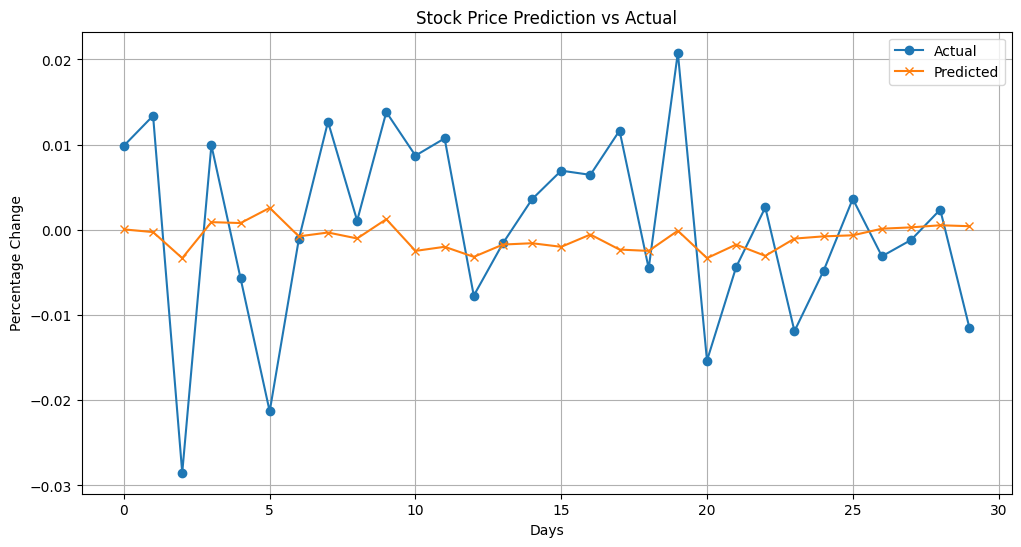

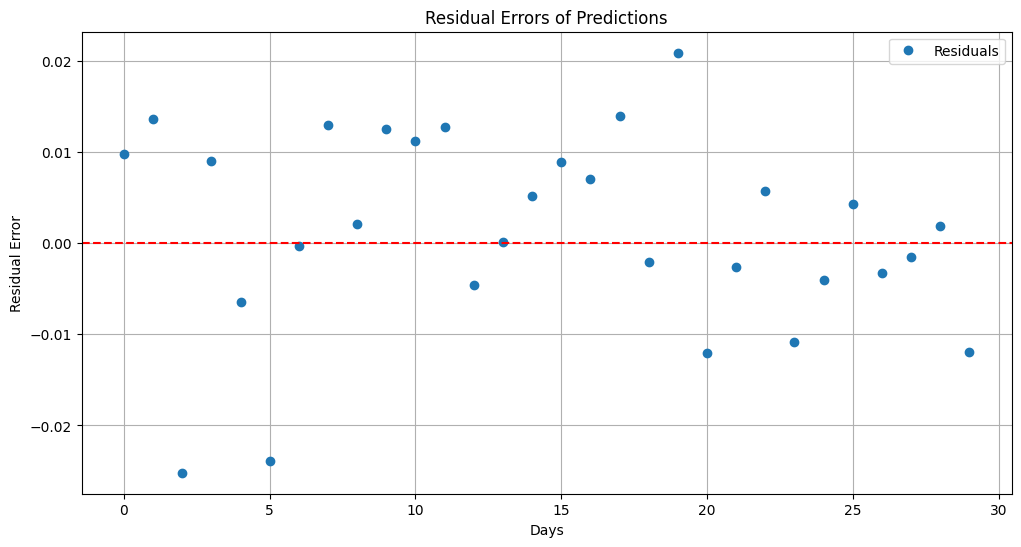

Performance Metrics:
MSE: 0.0001
MAE: 0.0087
RMSE: 0.0109
R2: 0.0046
Directional_Accuracy: 43.3333


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import contextlib
import io
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def train_xgboost(x_train, y_train):
    """Train an XGBoost model."""
    dtrain = xgb.DMatrix(x_train, label=y_train)
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'verbosity': 0
    }
    model = xgb.train(xgb_params, dtrain)
    return model

def predict_next_30_days(df, model_func, feature_columns, target_type='Close', train_window=30):
    """Predict the next 30 days after training on all prior data."""
    df = df.sort_index()
    train_df = df.iloc[:-train_window]
    test_df = df.iloc[-train_window:]

    X_train, y_train = train_df[feature_columns], train_df[f'Next_{target_type}_Pct_Change']
    X_test = test_df[feature_columns]

    model = model_func(X_train, y_train)
    dtest = xgb.DMatrix(X_test)
    predictions = model.predict(dtest)

    actual_values = test_df[f'Next_{target_type}_Pct_Change'].values

    results = {
        'Predictions': predictions.tolist(),
        'Actual_Values': actual_values.tolist(),
        'MSE': mean_squared_error(actual_values, predictions),
        'MAE': mean_absolute_error(actual_values, predictions),
        'RMSE': np.sqrt(mean_squared_error(actual_values, predictions)),
        'R2': r2_score(actual_values, predictions) if len(actual_values) > 1 else None,
        'Directional_Accuracy': np.mean(np.sign(predictions) == np.sign(actual_values)) * 100
    }

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actual_values)), actual_values, label='Actual', marker='o')
    plt.plot(range(len(predictions)), predictions, label='Predicted', marker='x')
    plt.xlabel('Days')
    plt.ylabel('Percentage Change')
    plt.title('Stock Price Prediction vs Actual')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot residual errors
    residuals = actual_values - predictions
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(residuals)), residuals, marker='o', linestyle='', label='Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Days')
    plt.ylabel('Residual Error')
    plt.title('Residual Errors of Predictions')
    plt.legend()
    plt.grid()
    plt.show()

    return results

def run_monthly_prediction(stocks_df, symbol, model_type='XGBoost'):
    """Train on all but the last 30 days, then predict 30 days ahead."""
    symbol_df = stocks_df[stocks_df['Symbol'] == symbol].copy()
    symbol_df.set_index('Date', inplace=True)

    feature_df = engineer_features(symbol_df)
    X, _ = prepare_model_data(feature_df, 'Close')

    model_func = train_xgboost if model_type == 'XGBoost' else train_and_evaluate_randomforest

    results = predict_next_30_days(feature_df, model_func, X.columns, 'Close', 30)
    return results

# Run predictions
results = run_monthly_prediction(stocks_df, 'MMM', 'XGBoost')

# Print performance metrics
print("Performance Metrics:")
for key, value in results.items():
    if isinstance(value, list):
        continue  # Skip printing lists (Predictions & Actual Values)
    print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


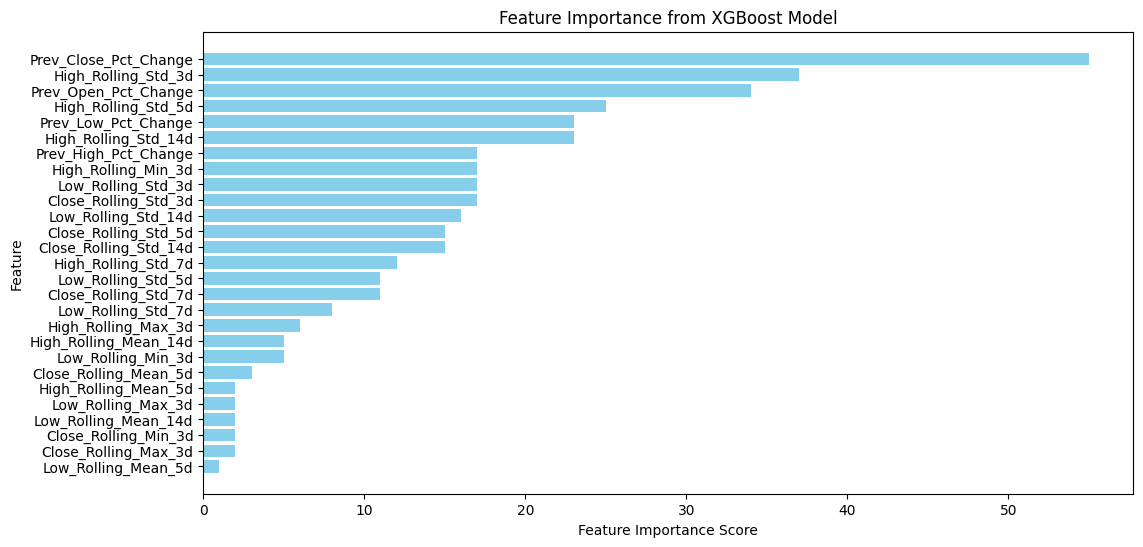

In [23]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_columns):
    """Plot the feature importances of an XGBoost model."""
    importance = model.get_score(importance_type='weight')

    # Convert importance dict to a sorted list
    importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and scores
    features, scores = zip(*importance) if importance else ([], [])

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(features, scores, color='skyblue')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance from XGBoost Model')
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.show()

# Example usage after training the model
xgb_model = train_xgboost(X, y)
plot_feature_importance(xgb_model, X.columns)


# VERSION 12


Starting sector-based prediction for MMM
Original stocks_df shape: (1768528, 8)
Target stock MMM is in sector: Industrials
Found 69 companies in the Industrials sector
Final dataframe shape after adding sector features: (3718, 52)
NaN values found in columns:
Sector_Close_mean_Pct_Change       1
Sector_Close_median_Pct_Change     1
Sector_Open_mean_Pct_Change        1
Sector_Open_median_Pct_Change      1
Sector_High_mean_Pct_Change        1
Sector_High_median_Pct_Change      1
Sector_Low_mean_Pct_Change         1
Sector_Low_median_Pct_Change       1
Sector_RSI                        13
Sector_BB_Middle                  19
Sector_BB_Upper                   19
Sector_BB_Lower                   19
Sector_Momentum_1d                 1
Sector_ROC_1d                      1
Sector_Momentum_3d                 3
Sector_ROC_3d                      3
Sector_Momentum_5d                 5
Sector_ROC_5d                      5
Sector_Momentum_7d                 7
Sector_ROC_7d                      7

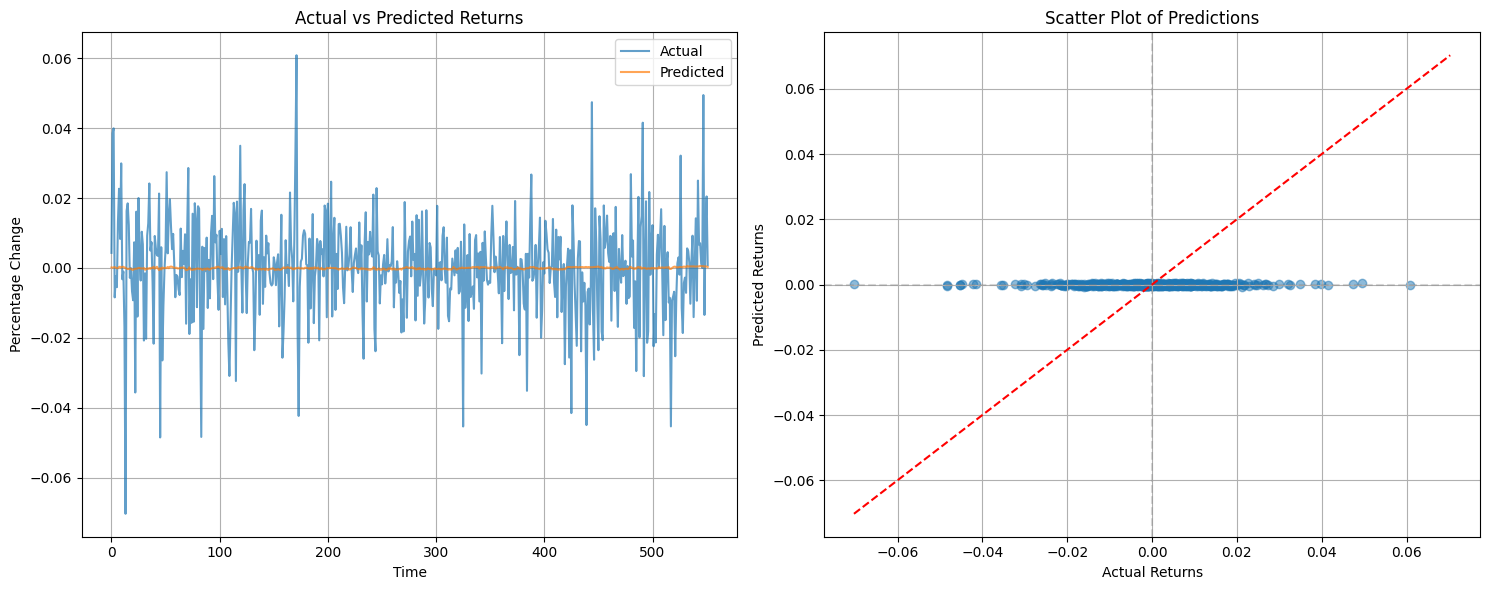

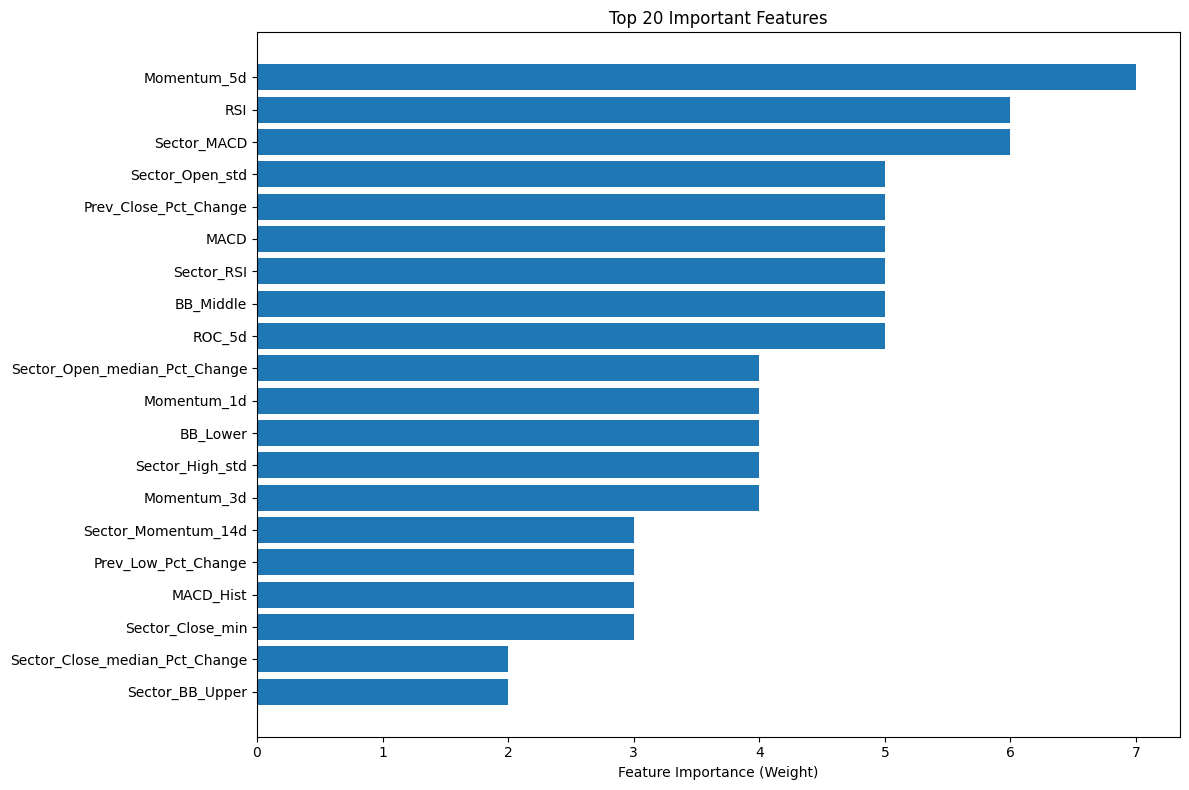


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: 0.0000
Direction_Accuracy: 47.2826


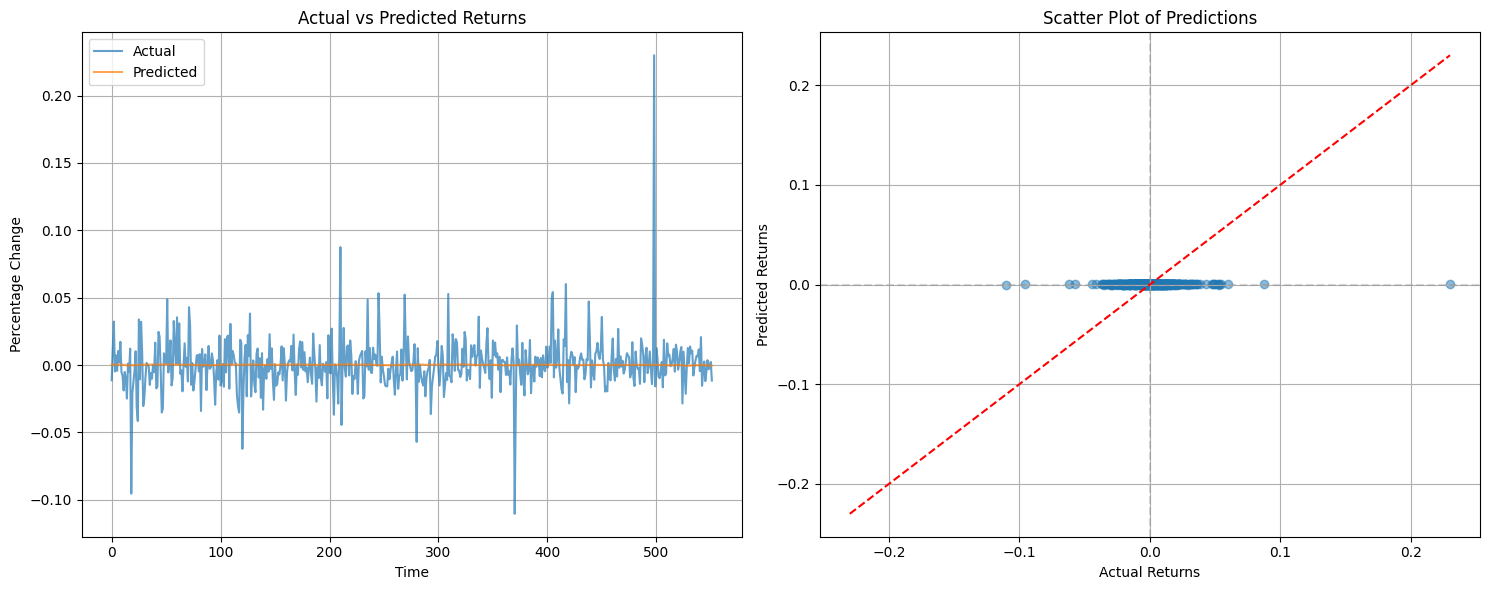


Sector features total importance: 34.00
Individual features total importance: 51.00
Ratio of sector to individual importance: 0.67


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

def add_sector_features(stocks_df: pd.DataFrame,
                        companies_df: pd.DataFrame,
                        target_symbol: str) -> pd.DataFrame:
    """
    Add sector-based features to the dataframe for the target stock.

    Args:
        stocks_df: DataFrame with daily stock data (OHLCV)
        companies_df: DataFrame with company metadata including sectors
        target_symbol: Symbol of the stock we want to predict

    Returns:
        DataFrame with added sector features
    """
    print(f"Original stocks_df shape: {stocks_df.shape}")

    # Step 1: Get the sector of our target stock
    if 'Sector' not in companies_df.columns:
        raise ValueError("Companies dataframe must contain a 'Sector' column")

    target_sector = companies_df.loc[companies_df['Symbol'] == target_symbol, 'Sector'].values[0]
    print(f"Target stock {target_symbol} is in sector: {target_sector}")

    # Step 2: Get all stocks in the same sector
    sector_companies = companies_df[companies_df['Sector'] == target_sector]
    sector_symbols = sector_companies['Symbol'].tolist()
    print(f"Found {len(sector_symbols)} companies in the {target_sector} sector")

    # Step 3: Filter stocks_df to only include sector stocks
    sector_stocks = stocks_df[stocks_df['Symbol'].isin(sector_symbols)]

    # Step 4: Prepare the result dataframe starting with target stock data
    target_stock_data = stocks_df[stocks_df['Symbol'] == target_symbol].copy()

    # Step 5: Set index to Date for easier time-based operations
    if not isinstance(target_stock_data.index, pd.DatetimeIndex):
        # If Date is a column, set it as index
        if 'Date' in target_stock_data.columns:
            target_stock_data = target_stock_data.set_index('Date')
            sector_stocks = sector_stocks.set_index('Date')
        else:
            # If Date is already the index but not datetime type
            target_stock_data.index = pd.to_datetime(target_stock_data.index)
            sector_stocks.index = pd.to_datetime(sector_stocks.index)

    # Step 6: Calculate daily percentage changes for all stocks in the sector
    for column in ['Close', 'Open', 'High', 'Low']:
        # Group by date and calculate sector-wide stats
        sector_daily = sector_stocks.groupby(sector_stocks.index)[column].agg(['mean', 'std', 'min', 'max', 'median'])

        # Calculate percentage changes for these aggregated values
        for stat in ['mean', 'median']:  # We only need pct_change for certain metrics
            stat_values = sector_daily[stat]
            target_stock_data[f'Sector_{column}_{stat}'] = stat_values
            target_stock_data[f'Sector_{column}_{stat}_Pct_Change'] = stat_values.pct_change()

        # Add the other statistics directly (standard deviation, min, max)
        target_stock_data[f'Sector_{column}_std'] = sector_daily['std']
        target_stock_data[f'Sector_{column}_min'] = sector_daily['min']
        target_stock_data[f'Sector_{column}_max'] = sector_daily['max']

    # Step 7: Calculate sector-wide technical indicators
    # RSI for sector mean close
    target_stock_data['Sector_RSI'] = calculate_rsi(target_stock_data['Sector_Close_mean'])

    # MACD for sector mean close
    macd_features = calculate_macd(target_stock_data['Sector_Close_mean'])
    target_stock_data['Sector_MACD'] = macd_features['MACD']
    target_stock_data['Sector_MACD_Signal'] = macd_features['MACD_Signal']
    target_stock_data['Sector_MACD_Hist'] = macd_features['MACD_Hist']

    # Bollinger Bands for sector mean close
    bb_features = calculate_bollinger_bands(target_stock_data['Sector_Close_mean'])
    target_stock_data['Sector_BB_Middle'] = bb_features['BB_Middle']
    target_stock_data['Sector_BB_Upper'] = bb_features['BB_Upper']
    target_stock_data['Sector_BB_Lower'] = bb_features['BB_Lower']

    # Step 8: Calculate sector momentum over multiple periods
    periods = [1, 3, 5, 7, 14]
    momentum_features = calculate_momentum(target_stock_data['Sector_Close_mean'], periods)
    for key, value in momentum_features.items():
        target_stock_data[f'Sector_{key}'] = value

    # Step 9: Check for NaN values and clean up
    print(f"Final dataframe shape after adding sector features: {target_stock_data.shape}")
    na_counts = target_stock_data.isna().sum()
    if na_counts.sum() > 0:
        print("NaN values found in columns:")
        print(na_counts[na_counts > 0])
        # Drop rows with NaN values
        target_stock_data = target_stock_data.dropna()
        print(f"Shape after removing NaN values: {target_stock_data.shape}")

    return target_stock_data

def calculate_rsi(data: pd.Series, periods: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data: pd.Series) -> dict:
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = data.ewm(span=12, adjust=False).mean()
    ema_slow = data.ewm(span=26, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return {
        'MACD': macd_line,
        'MACD_Signal': signal_line,
        'MACD_Hist': macd_hist
    }

def calculate_bollinger_bands(data: pd.Series) -> dict:
    """Calculate Bollinger Bands"""
    middle_band = data.rolling(window=20).mean()
    std = data.rolling(window=20).std()
    upper_band = middle_band + (std * 2)
    lower_band = middle_band - (std * 2)
    return {
        'BB_Middle': middle_band,
        'BB_Upper': upper_band,
        'BB_Lower': lower_band
    }

def calculate_momentum(data: pd.Series, periods: List[int]) -> dict:
    """Calculate momentum indicators for multiple periods"""
    features = {}
    for period in periods:
        features[f'Momentum_{period}d'] = data.pct_change(periods=period)
        features[f'ROC_{period}d'] = (data - data.shift(period)) / data.shift(period) * 100
    return features

def engineer_both_stock_and_sector_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create both individual stock features and keep sector features.

    This combines the individual stock feature engineering with the
    sector features already added to the dataframe.
    """
    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for stock price columns
    price_columns = ['Close', 'Open', 'High', 'Low']
    for column in price_columns:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Calculate targets for next day
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)
    result['Next_Direction'] = np.where(result['Next_Close_Pct_Change'] > 0, 'Up', 'Down')

    # Calculate standard technical indicators for individual stock
    result['RSI'] = calculate_rsi(df['Close'])

    macd_features = calculate_macd(df['Close'])
    result['MACD'] = macd_features['MACD']
    result['MACD_Signal'] = macd_features['MACD_Signal']
    result['MACD_Hist'] = macd_features['MACD_Hist']

    bb_features = calculate_bollinger_bands(df['Close'])
    result['BB_Middle'] = bb_features['BB_Middle']
    result['BB_Upper'] = bb_features['BB_Upper']
    result['BB_Lower'] = bb_features['BB_Lower']

    # Define periods for rolling stats and momentum
    periods = [1, 3, 5, 7, 14]

    # Calculate momentum for closing price
    momentum_features = calculate_momentum(df['Close'], periods)
    for key, value in momentum_features.items():
        result[key] = value

    # Drop rows with NaN values
    result_cleaned = result.dropna()

    return result_cleaned

def prepare_model_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepare feature matrix X and target vector y for modeling
    """
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Next_Direction',
        'Symbol',
        'Close',
        'Open',
        'High',
        'Low',
        'Volume',
        'Adj Close'
    ]

    # Select features (excluding target and excluded columns)
    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']  # Target is next day's close price percentage change

    return X, y

def split_time_series_data(df: pd.DataFrame, feature_columns: List[str],
                          target_column: str = 'Next_Close_Pct_Change',
                          train_size: float = 0.7, val_size: float = 0.15) -> Tuple:
    """
    Split data into train, validation, and test sets chronologically
    """
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    X_train = train_df[feature_columns]
    y_train = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0]} to {X_val.index[-1]})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0]} to {X_test.index[-1]})")

    return X_train, y_train, X_val, y_val, X_test, y_test

def train_xgboost_model(X_train: pd.DataFrame, y_train: pd.Series) -> xgb.Booster:
    """
    Train an XGBoost model for stock prediction
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 5,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'alpha': 1,
        'lambda': 1,
        'seed': 42
    }

    num_rounds = 100
    model = xgb.train(params, dtrain, num_rounds)

    return model

def predict_and_evaluate(model: xgb.Booster, X_val: pd.DataFrame, y_val: pd.Series) -> Dict:
    """
    Make predictions and evaluate model performance
    """
    dval = xgb.DMatrix(X_val)
    predictions = model.predict(dval)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    # Calculate directional accuracy (up/down)
    actual_direction = np.where(y_val > 0, 1, -1)
    predicted_direction = np.where(predictions > 0, 1, -1)
    direction_accuracy = np.mean(actual_direction == predicted_direction) * 100

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Direction_Accuracy': direction_accuracy
    }

    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return {
        'Predictions': predictions,
        'Actual_Values': y_val.values,
        'Metrics': metrics
    }

def plot_results(predictions: np.ndarray, actual_values: np.ndarray, title: str = 'Model Performance'):
    """
    Plot actual vs predicted values and feature importance
    """
    plt.figure(figsize=(15, 6))

    # Time series plot
    plt.subplot(1, 2, 1)
    plt.plot(actual_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Returns')
    plt.xlabel('Time')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.grid(True)

    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(actual_values, predictions, alpha=0.5)

    # Add perfect prediction line
    max_val = max(np.max(np.abs(actual_values)), np.max(np.abs(predictions)))
    plt.plot([-max_val, max_val], [-max_val, max_val], 'r--')

    # Add quadrant lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title('Scatter Plot of Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model: xgb.Booster, feature_names: List[str], top_n: int = 20):
    """
    Plot feature importance from XGBoost model
    """
    importance = model.get_score(importance_type='weight')

    # Convert to DataFrame for easier manipulation
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values('Importance', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1])
    plt.xlabel('Feature Importance (Weight)')
    plt.title(f'Top {top_n} Important Features')
    plt.tight_layout()
    plt.show()

    return importance_df

def run_sector_based_prediction(stocks_df: pd.DataFrame, companies_df: pd.DataFrame, target_symbol: str):
    """
    Run the complete sector-based stock prediction workflow
    """
    print(f"\n{'='*50}")
    print(f"Starting sector-based prediction for {target_symbol}")
    print(f"{'='*50}")

    # Step 1: Add sector features to the target stock data
    stock_with_sector = add_sector_features(stocks_df, companies_df, target_symbol)

    # Step 2: Engineer individual stock features while keeping sector features
    feature_df = engineer_both_stock_and_sector_features(stock_with_sector)

    # Step 3: Prepare data for modeling
    X, y = prepare_model_data(feature_df)

    # Step 4: Split data into train, validation, and test sets
    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
        feature_df, X.columns
    )

    # Step 5: Train XGBoost model
    print("\nTraining XGBoost model...")
    model = train_xgboost_model(X_train, y_train)

    # Step 6: Evaluate on validation set
    print("\nEvaluating on validation set...")
    val_results = predict_and_evaluate(model, X_val, y_val)

    # Step 7: Plot results
    plot_results(val_results['Predictions'], val_results['Actual_Values'],
                title=f'{target_symbol} Validation Results')

    # Step 8: Plot feature importance
    importance_df = plot_feature_importance(model, X.columns)

    # Step 9: Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = predict_and_evaluate(model, X_test, y_test)

    # Step 10: Plot test results
    plot_results(test_results['Predictions'], test_results['Actual_Values'],
                title=f'{target_symbol} Test Results')

    # Print sector vs. individual feature importance summary
    sector_features = [col for col in importance_df['Feature'] if col.startswith('Sector_')]
    individual_features = [col for col in importance_df['Feature'] if not col.startswith('Sector_')]

    sector_importance = importance_df[importance_df['Feature'].isin(sector_features)]['Importance'].sum()
    individual_importance = importance_df[importance_df['Feature'].isin(individual_features)]['Importance'].sum()

    print(f"\nSector features total importance: {sector_importance:.2f}")
    print(f"Individual features total importance: {individual_importance:.2f}")
    print(f"Ratio of sector to individual importance: {sector_importance/individual_importance:.2f}")

    return {
        'model': model,
        'validation_results': val_results,
        'test_results': test_results,
        'feature_importance': importance_df
    }

# Example usage:
results = run_sector_based_prediction(stocks_df, companies_df, 'MMM')

# Version 1000

balance out data

most data has a 0 return -> bias to 0

bucket returns 0-0.01


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

def add_sector_features(stocks_df: pd.DataFrame,
                        companies_df: pd.DataFrame,
                        target_symbol: str) -> pd.DataFrame:
    print(f"Original stocks_df shape: {stocks_df.shape}")

    # Get the sector of our target stock
    target_sector = companies_df.loc[companies_df['Symbol'] == target_symbol, 'Sector'].values[0]
    print(f"Target stock {target_symbol} is in sector: {target_sector}")

    # Get all stocks in the same sector
    sector_companies = companies_df[companies_df['Sector'] == target_sector]
    sector_symbols = sector_companies['Symbol'].tolist()
    print(f"Found {len(sector_symbols)} companies in the {target_sector} sector")

    # Filter stocks_df to only include sector stocks
    sector_stocks = stocks_df[stocks_df['Symbol'].isin(sector_symbols)]
    print(f"Sector stocks data shape: {sector_stocks.shape}")

    # Get only the target stock data
    target_stock_data = stocks_df[stocks_df['Symbol'] == target_symbol].copy()
    print(f"Target stock data shape: {target_stock_data.shape}")

    # Ensure dates are datetime format
    if not pd.api.types.is_datetime64_any_dtype(sector_stocks['Date']):
        sector_stocks['Date'] = pd.to_datetime(sector_stocks['Date'])
        target_stock_data['Date'] = pd.to_datetime(target_stock_data['Date'])

    # Group by date to calculate sector-wide statistics
    sector_daily = sector_stocks.groupby('Date').agg({
        'Close': ['mean', 'std', 'min', 'max', 'median'],
        'Open': ['mean', 'std', 'min', 'max', 'median'],
        'High': ['mean', 'std', 'min', 'max', 'median'],
        'Low': ['mean', 'std', 'min', 'max', 'median']
    })

    # Flatten the column multi-index
    sector_daily.columns = [f'Sector_{col[0]}_{col[1]}' for col in sector_daily.columns]
    print(f"Sector daily aggregates shape: {sector_daily.shape}")

    # Merge sector stats with target stock data
    result = pd.merge(
        target_stock_data,
        sector_daily,
        left_on='Date',
        right_index=True,
        how='left'
    )

    print(f"After merging sector data shape: {result.shape}")

    # Now set Date as index for subsequent operations
    result = result.set_index('Date')

    # Calculate percentage changes for sector aggregates
    for column in ['Sector_Close_mean', 'Sector_Open_mean', 'Sector_High_mean', 'Sector_Low_mean',
                   'Sector_Close_median', 'Sector_Open_median', 'Sector_High_median', 'Sector_Low_median']:
        if column in result.columns:
            result[f'{column}_Pct_Change'] = result[column].pct_change()

    # Step 7: Calculate sector-wide technical indicators
    # RSI for sector mean close
    result['Sector_RSI'] = calculate_rsi(result['Sector_Close_mean'])

    # MACD for sector mean close
    macd_features = calculate_macd(result['Sector_Close_mean'])
    result['Sector_MACD'] = macd_features['MACD']
    result['Sector_MACD_Signal'] = macd_features['MACD_Signal']
    result['Sector_MACD_Hist'] = macd_features['MACD_Hist']

    # Bollinger Bands for sector mean close
    bb_features = calculate_bollinger_bands(result['Sector_Close_mean'])
    result['Sector_BB_Middle'] = bb_features['BB_Middle']
    result['Sector_BB_Upper'] = bb_features['BB_Upper']
    result['Sector_BB_Lower'] = bb_features['BB_Lower']

    # Step 8: Calculate sector momentum over multiple periods
    periods = [1, 3, 5, 7, 14]
    momentum_features = calculate_momentum(result['Sector_Close_mean'], periods)
    for key, value in momentum_features.items():
        result[f'Sector_{key}'] = value

    # Step 9: Check for NaN values and clean up
    print(f"Final dataframe shape after adding sector features: {result.shape}")
    na_counts = result.isna().sum()
    if na_counts.sum() > 0:
        print("NaN values found in columns:")
        print(na_counts[na_counts > 0])
        # Drop rows with NaN values
        result = result.dropna()
        print(f"Shape after removing NaN values: {result.shape}")

    return result


def calculate_rsi(data: pd.Series, periods: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data: pd.Series) -> dict:
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = data.ewm(span=12, adjust=False).mean()
    ema_slow = data.ewm(span=26, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return {
        'MACD': macd_line,
        'MACD_Signal': signal_line,
        'MACD_Hist': macd_hist
    }

def calculate_bollinger_bands(data: pd.Series) -> dict:
    """Calculate Bollinger Bands"""
    middle_band = data.rolling(window=20).mean()
    std = data.rolling(window=20).std()
    upper_band = middle_band + (std * 2)
    lower_band = middle_band - (std * 2)
    return {
        'BB_Middle': middle_band,
        'BB_Upper': upper_band,
        'BB_Lower': lower_band
    }

def calculate_momentum(data: pd.Series, periods: List[int]) -> dict:
    """Calculate momentum indicators for multiple periods"""
    features = {}
    for period in periods:
        features[f'Momentum_{period}d'] = data.pct_change(periods=period)
        features[f'ROC_{period}d'] = (data - data.shift(period)) / data.shift(period) * 100
    return features

def engineer_both_stock_and_sector_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create both individual stock features and keep sector features.

    This combines the individual stock feature engineering with the
    sector features already added to the dataframe.
    """
    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for stock price columns
    price_columns = ['Close', 'Open', 'High', 'Low']
    for column in price_columns:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Calculate targets for next day
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)
    result['Next_Direction'] = np.where(result['Next_Close_Pct_Change'] > 0, 'Up', 'Down')

    # Calculate standard technical indicators for individual stock
    result['RSI'] = calculate_rsi(df['Close'])

    macd_features = calculate_macd(df['Close'])
    result['MACD'] = macd_features['MACD']
    result['MACD_Signal'] = macd_features['MACD_Signal']
    result['MACD_Hist'] = macd_features['MACD_Hist']

    bb_features = calculate_bollinger_bands(df['Close'])
    result['BB_Middle'] = bb_features['BB_Middle']
    result['BB_Upper'] = bb_features['BB_Upper']
    result['BB_Lower'] = bb_features['BB_Lower']

    # Define periods for rolling stats and momentum
    periods = [1, 3, 5, 7, 14]

    # Calculate momentum for closing price
    momentum_features = calculate_momentum(df['Close'], periods)
    for key, value in momentum_features.items():
        result[key] = value

    # Drop rows with NaN values
    result_cleaned = result.dropna()

    return result_cleaned

def prepare_model_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepare feature matrix X and target vector y for modeling
    """
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Next_Direction',
        'Symbol',
        'Close',
        'Open',
        'High',
        'Low',
        'Volume',
        'Adj Close'
    ]

    # Select features (excluding target and excluded columns)
    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']  # Target is next day's close price percentage change

    return X, y

def create_balanced_bins(y: pd.Series, n_bins: int = 5, samples_per_bin: int = 100) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Create balanced bins for the target variable to address class imbalance.

    Args:
        y: Target series with percentage changes
        n_bins: Number of bins to create
        samples_per_bin: Number of samples to take from each bin

    Returns:
        Tuple of (X_balanced, y_balanced)
    """
    # Get the index of y to maintain alignment with X
    idx = y.index

    # Create a new DataFrame with index and target
    df_target = pd.DataFrame({'target': y}, index=idx)

    # Define bins based on percentiles to get roughly equal sized bins
    if n_bins > 2:
        percentiles = np.linspace(0, 100, n_bins + 1)
        bin_edges = np.percentile(y, percentiles)

        # Ensure unique edges
        bin_edges = np.unique(bin_edges)

        # If we lost some bins due to duplicate edges, adjust n_bins
        n_bins = len(bin_edges) - 1
    else:
        # For binary classification (up/down), just split at 0
        bin_edges = [-np.inf, 0, np.inf]
        n_bins = 2

    # Create bin labels
    bin_labels = [f'bin_{i}' for i in range(n_bins)]

    # Assign bins to each row
    df_target['bin'] = pd.cut(df_target['target'], bins=bin_edges, labels=bin_labels)

    # Sample from each bin
    sampled_indices = []

    for bin_label in bin_labels:
        bin_indices = df_target[df_target['bin'] == bin_label].index

        # Ensure we don't try to sample more than available
        bin_sample_count = min(samples_per_bin, len(bin_indices))

        if bin_sample_count > 0:
            bin_sampled = np.random.choice(bin_indices, size=bin_sample_count, replace=False)
            sampled_indices.extend(bin_sampled)

    # Return the sampled indices
    return sampled_indices

def split_time_series_data(df: pd.DataFrame, feature_columns: List[str],
                          target_column: str = 'Next_Close_Pct_Change',
                          train_size: float = 0.7, val_size: float = 0.15,
                          use_balanced_bins: bool = False,
                          n_bins: int = 5,
                          samples_per_bin: int = 100) -> Tuple:
    """
    Split data into train, validation, and test sets chronologically,
    with optional balanced sampling for training data
    """
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # Get features and target
    X_train_full = train_df[feature_columns]
    y_train_full = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    # Apply balanced sampling if requested
    if use_balanced_bins:
        print("\nApplying balanced bin sampling to training data...")
        sampled_indices = create_balanced_bins(y_train_full, n_bins, samples_per_bin)

        X_train = X_train_full.loc[sampled_indices]
        y_train = y_train_full.loc[sampled_indices]

        # Print distribution info before and after sampling
        print(f"Original training set distribution:")
        print(pd.cut(y_train_full, bins=5).value_counts())

        print(f"\nBalanced training set distribution:")
        print(pd.cut(y_train, bins=5).value_counts())

        print(f"\nSampled {len(X_train)} examples from original {len(X_train_full)} training examples")
    else:
        X_train = X_train_full
        y_train = y_train_full

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0] if len(X_val) > 0 else 'N/A'} to {X_val.index[-1] if len(X_val) > 0 else 'N/A'})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0] if len(X_test) > 0 else 'N/A'} to {X_test.index[-1] if len(X_test) > 0 else 'N/A'})")

    # Optionally visualize balanced sampling
    if use_balanced_bins:
        try:
            visualize_balanced_sampling(y_train_full, y_train)
        except Exception as e:
            print(f"Visualization error (non-critical): {e}")

    return X_train, y_train, X_val, y_val, X_test, y_test

def tune_xgboost_hyperparameters(X_train: pd.DataFrame, y_train: pd.Series,
                               X_val: pd.DataFrame, y_val: pd.Series,
                               param_grid: Optional[Dict] = None) -> Dict:
    """
    Tune XGBoost hyperparameters using a coarse-to-fine approach.

    Args:
        X_train: Training features
        y_train: Training target
        X_val: Validation features
        y_val: Validation target
        param_grid: Optional custom parameter grid, otherwise uses default

    Returns:
        Dict with best parameters
    """
    print("\nTuning XGBoost hyperparameters...")

    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Initial wide search for max_depth and learning_rate
    if param_grid is None:
        # First round: Coarse search for max_depth
        param_grid = {
            'max_depth': [3, 5, 7, 10, 15, 20],
            'eta': [0.1],  # Fixed learning rate
            'objective': ['reg:squarederror'],
            'eval_metric': ['rmse'],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'alpha': [1],
            'lambda': [1]
        }

    results = {}
    best_params = {}

    # Run the grid search
    for max_depth in param_grid['max_depth']:
        params = {
            'max_depth': max_depth,
            'eta': param_grid['eta'][0],
            'objective': param_grid['objective'][0],
            'eval_metric': param_grid['eval_metric'][0],
            'subsample': param_grid['subsample'][0],
            'colsample_bytree': param_grid['colsample_bytree'][0],
            'alpha': param_grid['alpha'][0],
            'lambda': param_grid['lambda'][0]
        }

        # Train the model
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        num_rounds = 100

        # Use early stopping to prevent overfitting
        model = xgb.train(params, dtrain, num_rounds, evallist,
                         early_stopping_rounds=10, verbose_eval=False)

        # Get best score
        best_score = model.best_score
        results[max_depth] = best_score

        print(f"max_depth={max_depth}, Best RMSE: {best_score:.4f}")

    # Find best max_depth
    best_max_depth = min(results, key=results.get)
    best_params['max_depth'] = best_max_depth

    print(f"\nBest max_depth: {best_max_depth}")

    # Visualize max_depth tuning results
    try:
        visualize_hyperparameter_tuning(list(results.keys()), list(results.values()), "max_depth")
    except Exception as e:
        print(f"Visualization error (non-critical): {e}")

    # Second round: Fine-tune around the best max_depth
    nearby_depths = [max(1, best_max_depth - 2),
                    max(1, best_max_depth - 1),
                    best_max_depth,
                    best_max_depth + 1,
                    best_max_depth + 2]

    # Remove duplicates and keep only valid values
    nearby_depths = sorted(list(set([d for d in nearby_depths if d > 0])))

    if len(nearby_depths) > 1:  # Only search if we have multiple values
        print("\nFine-tuning max_depth...")

        fine_results = {}

        for max_depth in nearby_depths:
            params = {
                'max_depth': max_depth,
                'eta': param_grid['eta'][0],
                'objective': param_grid['objective'][0],
                'eval_metric': param_grid['eval_metric'][0],
                'subsample': param_grid['subsample'][0],
                'colsample_bytree': param_grid['colsample_bytree'][0],
                'alpha': param_grid['alpha'][0],
                'lambda': param_grid['lambda'][0]
            }

            # Train the model
            evallist = [(dtrain, 'train'), (dval, 'eval')]
            model = xgb.train(params, dtrain, num_rounds, evallist,
                             early_stopping_rounds=10, verbose_eval=False)

            # Get best score
            best_score = model.best_score
            fine_results[max_depth] = best_score

            print(f"max_depth={max_depth}, Best RMSE: {best_score:.4f}")

        # Find best fine-tuned max_depth
        best_max_depth = min(fine_results, key=fine_results.get)
        best_params['max_depth'] = best_max_depth

        print(f"\nFine-tuned best max_depth: {best_max_depth}")

    # Third round: Search for best learning rate (eta)
    print("\nTuning learning rate (eta)...")

    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
    eta_results = {}

    for eta in learning_rates:
        params = {
            'max_depth': best_params['max_depth'],
            'eta': eta,
            'objective': param_grid['objective'][0],
            'eval_metric': param_grid['eval_metric'][0],
            'subsample': param_grid['subsample'][0],
            'colsample_bytree': param_grid['colsample_bytree'][0],
            'alpha': param_grid['alpha'][0],
            'lambda': param_grid['lambda'][0]
        }

        # Train the model
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(params, dtrain, num_rounds, evallist,
                         early_stopping_rounds=10, verbose_eval=False)

        # Get best score
        best_score = model.best_score
        eta_results[eta] = best_score

        print(f"eta={eta}, Best RMSE: {best_score:.4f}")

    # Find best learning rate
    best_eta = min(eta_results, key=eta_results.get)
    best_params['eta'] = best_eta

    print(f"\nBest learning rate (eta): {best_eta}")

    # Visualize eta tuning results
    visualize_hyperparameter_tuning(
        list(eta_results.keys()),
        list(eta_results.values()),
        param_name="learning_rate"
    )

    # Fourth round: Tune subsample and colsample_bytree
    print("\nTuning subsample and colsample_bytree...")

    sample_params = [0.6, 0.7, 0.8, 0.9, 1.0]
    best_score = float('inf')
    best_subsample = 0.8
    best_colsample = 0.8

    for subsample in sample_params:
        for colsample in sample_params:
            params = {
                'max_depth': best_params['max_depth'],
                'eta': best_params['eta'],
                'objective': param_grid['objective'][0],
                'eval_metric': param_grid['eval_metric'][0],
                'subsample': subsample,
                'colsample_bytree': colsample,
                'alpha': param_grid['alpha'][0],
                'lambda': param_grid['lambda'][0]
            }

            # Train the model
            evallist = [(dtrain, 'train'), (dval, 'eval')]
            model = xgb.train(params, dtrain, num_rounds, evallist,
                             early_stopping_rounds=10, verbose_eval=False)

            # Get best score
            score = model.best_score

            if score < best_score:
                best_score = score
                best_subsample = subsample
                best_colsample = colsample

    best_params['subsample'] = best_subsample
    best_params['colsample_bytree'] = best_colsample

    print(f"Best subsample: {best_subsample}, Best colsample_bytree: {best_colsample}")

    # Final best parameters
    final_params = {
        'max_depth': best_params['max_depth'],
        'eta': best_params['eta'],
        'objective': param_grid['objective'][0],
        'eval_metric': param_grid['eval_metric'][0],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'alpha': param_grid['alpha'][0],
        'lambda': param_grid['lambda'][0]
    }

    print("\nFinal best parameters:")
    for param, value in final_params.items():
        print(f"{param}: {value}")

    return final_params

def train_xgboost_model(X_train: pd.DataFrame, y_train: pd.Series,
                       X_val: pd.DataFrame = None, y_val: pd.Series = None,
                       params: Dict = None) -> xgb.Booster:
    """
    Train an XGBoost model for stock prediction
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)

    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 5,
            'eta': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'alpha': 1,
            'lambda': 1,
            'seed': 42
        }

    num_rounds = 100

    if X_val is not None and y_val is not None:
        dval = xgb.DMatrix(X_val, label=y_val)
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(params, dtrain, num_rounds, evallist,
                         early_stopping_rounds=10, verbose_eval=False)
    else:
        model = xgb.train(params, dtrain, num_rounds)

    return model

def predict_and_evaluate(model: xgb.Booster, X_val: pd.DataFrame, y_val: pd.Series) -> Dict:
    """
    Make predictions and evaluate model performance
    """
    dval = xgb.DMatrix(X_val)
    predictions = model.predict(dval)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    # Calculate directional accuracy (up/down)
    actual_direction = np.where(y_val > 0, 1, -1)
    predicted_direction = np.where(predictions > 0, 1, -1)
    direction_accuracy = np.mean(actual_direction == predicted_direction) * 100

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Direction_Accuracy': direction_accuracy
    }

    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return {
        'Predictions': predictions,
        'Actual_Values': y_val.values,
        'Metrics': metrics
    }

def plot_results(predictions: np.ndarray, actual_values: np.ndarray, title: str = 'Model Performance'):
    """
    Plot actual vs predicted values with improved axis scaling
    """
    plt.figure(figsize=(15, 10))

    # Time series plot
    plt.subplot(2, 2, 1)
    plt.plot(actual_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Returns')
    plt.xlabel('Time')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.grid(True)

    # Scatter plot with improved scaling
    plt.subplot(2, 2, 2)
    plt.scatter(actual_values, predictions, alpha=0.5)

    # Calculate reasonable axis limits based on data
    # Find the 99th percentile to exclude extreme outliers
    x_99 = np.percentile(np.abs(actual_values), 99)
    y_99 = np.percentile(np.abs(predictions), 99)

    # Use the larger of the two for symmetrical axes
    limit = max(x_99, y_99) * 1.1  # Add 10% padding

    # Set axis limits
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    # Add perfect prediction line
    plt.plot([-limit, limit], [-limit, limit], 'r--')

    # Add quadrant lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title('Scatter Plot of Predictions')
    plt.grid(True)

    # Distribution of actual and predicted values
    plt.subplot(2, 2, 3)
    plt.hist(actual_values, bins=50, alpha=0.5, label='Actual')
    plt.hist(predictions, bins=50, alpha=0.5, label='Predicted')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)

    # Error distribution
    plt.subplot(2, 2, 4)
    errors = actual_values - predictions
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

def plot_feature_importance(model: xgb.Booster, feature_names: List[str], top_n: int = 20):
    """
    Plot feature importance from XGBoost model with improved error handling
    """
    try:
        # Get importance scores directly from model
        importance = model.get_score(importance_type='weight')

        # Check if we got any importance scores
        if not importance:
            print("Warning: No feature importance returned by the model.")
            return pd.DataFrame(columns=['Feature', 'Importance'])  # Return empty DataFrame with expected columns

        # Convert to DataFrame for easier manipulation
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=False)

        # Limit to top_n features
        if len(importance_df) > top_n:
            importance_df = importance_df.head(top_n)

        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1])
        plt.xlabel('Feature Importance (Weight)')
        plt.title(f'Top {len(importance_df)} Important Features')
        plt.tight_layout()
        plt.show()

        return importance_df
    except Exception as e:
        print(f"Error plotting feature importance: {e}")
        return pd.DataFrame(columns=['Feature', 'Importance'])  # Return empty DataFrame with expected columns

def run_sector_based_prediction_with_balanced_data(stocks_df: pd.DataFrame,
                                                 companies_df: pd.DataFrame,
                                                 target_symbol: str,
                                                 use_balanced_bins: bool = True,
                                                 n_bins: int = 5,
                                                 samples_per_bin: int = 100,
                                                 tune_hyperparameters: bool = True):
    """
    Run the complete sector-based stock prediction workflow with balanced data sampling
    and hyperparameter tuning.

    Args:
        stocks_df: DataFrame with stock data
        companies_df: DataFrame with company metadata
        target_symbol: Symbol of the stock to predict
        use_balanced_bins: Whether to use balanced bin sampling
        n_bins: Number of bins for balanced sampling
        samples_per_bin: Number of samples to take from each bin
        tune_hyperparameters: Whether to tune XGBoost hyperparameters

    Returns:
        Dict with results
    """
    print(f"\n{'='*50}")
    print(f"Starting sector-based prediction for {target_symbol}")
    print(f"{'='*50}")

    # Step 1: Add sector features to the target stock data
    stock_with_sector = add_sector_features(stocks_df, companies_df, target_symbol)

    # Step 2: Engineer individual stock features while keeping sector features
    feature_df = engineer_both_stock_and_sector_features(stock_with_sector)

    # Step 3: Prepare data for modeling
    X, y = prepare_model_data(feature_df)

    # Step 4: Split data into train, validation, and test sets with balanced sampling
    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
        feature_df, X.columns, use_balanced_bins=use_balanced_bins,
        n_bins=n_bins, samples_per_bin=samples_per_bin
    )

    # Step 5: Optionally tune hyperparameters
    if tune_hyperparameters:
        print("\nTuning XGBoost hyperparameters...")
        best_params = tune_xgboost_hyperparameters(X_train, y_train, X_val, y_val)
    else:
        best_params = None

    # Step 6: Train XGBoost model with best parameters
    print("\nTraining XGBoost model...")
    model = train_xgboost_model(X_train, y_train, X_val, y_val, params=best_params)

    # Step 7: Evaluate on validation set
    print("\nEvaluating on validation set...")
    val_results = predict_and_evaluate(model, X_val, y_val)

    # Step 8: Plot validation results
    plot_results(val_results['Predictions'], val_results['Actual_Values'],
                title=f'{target_symbol} Validation Results')

    # Step 9: Plot feature importance
    importance_df = plot_feature_importance(model, X.columns)

    # Step 10: Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = predict_and_evaluate(model, X_test, y_test)

    # Step 11: Plot test results
    plot_results(test_results['Predictions'], test_results['Actual_Values'],
                title=f'{target_symbol} Test Results')

    # Analyze sector vs. individual feature importance
    sector_features = [col for col in importance_df['Feature'] if col.startswith('Sector_')]
    individual_features = [col for col in importance_df['Feature'] if not col.startswith('Sector_')]

    if not sector_features or not individual_features:
        print("\nWarning: Could not separate sector and individual features in importance list.")
    else:
        sector_importance = importance_df[importance_df['Feature'].isin(sector_features)]['Importance'].sum()
        individual_importance = importance_df[importance_df['Feature'].isin(individual_features)]['Importance'].sum()

        print(f"\nSector features total importance: {sector_importance:.2f}")
        print(f"Individual features total importance: {individual_importance:.2f}")
        print(f"Ratio of sector to individual importance: {sector_importance/individual_importance:.2f}")

    # Compare balance approach with original approach if using balanced bins
    if use_balanced_bins:
        print("\n\nComparing balanced approach with original approach...")

        # Train model without balanced sampling
        X_train_orig, y_train_orig, X_val, y_val, X_test, y_test = split_time_series_data(
            feature_df, X.columns, use_balanced_bins=False
        )

        # Train original model (without balancing)
        print("\nTraining model without balanced sampling...")
        orig_model = train_xgboost_model(X_train_orig, y_train_orig, X_val, y_val, params=best_params)

        # Evaluate original model
        orig_results = predict_and_evaluate(orig_model, X_val, y_val)

        # Print comparison
        print("\nBalanced vs. Original Model Comparison:")
        print(f"{'Metric':<20} {'Balanced':<10} {'Original':<10} {'Difference':<10}")
        print("-" * 50)

        for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'Direction_Accuracy']:
            balanced_value = val_results['Metrics'][metric]
            orig_value = orig_results['Metrics'][metric]

            if metric in ['R2', 'Direction_Accuracy']:  # Higher is better
                diff = balanced_value - orig_value
                diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"
            else:  # Lower is better
                diff = orig_value - balanced_value
                diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"

            print(f"{metric:<20} {balanced_value:<10.4f} {orig_value:<10.4f} {diff_str:<10}")

    return {
        'model': model,
        'validation_results': val_results,
        'test_results': test_results,
        'feature_importance': importance_df,
        'best_params': best_params if tune_hyperparameters else None
    }

def visualize_balanced_sampling(y_train_full, y_train):
    """Simple histogram visualization of balanced sampling effect"""
    plt.figure(figsize=(12, 5))

    # Create subplot for original distribution
    plt.subplot(1, 2, 1)
    plt.hist(y_train_full, bins=30, alpha=0.7, color='blue')
    plt.title('Original Data Distribution')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)

    # Create subplot for balanced distribution
    plt.subplot(1, 2, 2)
    plt.hist(y_train, bins=30, alpha=0.7, color='green')
    plt.title('Balanced Data Distribution')
    plt.xlabel('Daily Returns')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_hyperparameter_tuning(param_values, scores, param_name="max_depth"):
    """Simple line plot for hyperparameter tuning results"""
    plt.figure(figsize=(10, 6))

    # Convert inputs to lists if they're dictionaries
    if isinstance(param_values, dict) and isinstance(scores, dict):
        x_values = list(param_values.keys())
        y_values = list(param_values.values())
    else:
        x_values = param_values
        y_values = scores

    # Create the plot
    plt.plot(x_values, y_values, 'o-', linewidth=2, markersize=10)

    # Mark the best value
    best_idx = np.argmin(y_values)
    best_x = x_values[best_idx]
    best_y = y_values[best_idx]

    plt.scatter([best_x], [best_y], s=200, c='red', marker='*')

    # Add labels and title
    plt.xlabel(f'{param_name} Value')
    plt.ylabel('Error (RMSE)')
    plt.title(f'Finding Optimal {param_name} Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_directional_accuracy_comparison(results_dict):
    """Create a bar chart comparing directional accuracy"""
    # Define models and their colors
    models = ['Random Guessing', 'Original + Tuned', 'Balanced + Untuned', 'Balanced + Tuned']
    colors = ['lightgray', 'skyblue', 'lightgreen', 'green']

    # Set accuracy values
    accuracy = [50.0]  # Random guessing baseline

    # Add actual values from results
    for model in models[1:]:
        accuracy.append(results_dict.get(model, np.nan))

    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracy, color=colors)

    # Add horizontal line for baseline
    plt.axhline(y=50, color='red', linestyle='--')

    # Customize chart
    plt.ylabel('Directional Accuracy (%)')
    plt.title('Model Performance Comparison')
    plt.grid(axis='y', alpha=0.3)

    # Set y-axis to better show small differences
    plt.ylim(49, 54)

    plt.tight_layout()
    plt.show()

Loading data...


========== EXPERIMENT 1: BALANCED BINS WITH HYPERPARAMETER TUNING ==========

Starting sector-based prediction for MMM
Original stocks_df shape: (1870154, 8)
Target stock MMM is in sector: Industrials
Found 69 companies in the Industrials sector
Sector stocks data shape: (256542, 8)
Target stock data shape: (3718, 8)
Sector daily aggregates shape: (3718, 20)
After merging sector data shape: (3718, 28)
Final dataframe shape after adding sector features: (3718, 52)
NaN values found in columns:
Sector_Close_mean_Pct_Change       1
Sector_Open_mean_Pct_Change        1
Sector_High_mean_Pct_Change        1
Sector_Low_mean_Pct_Change         1
Sector_Close_median_Pct_Change     1
Sector_Open_median_Pct_Change      1
Sector_High_median_Pct_Change      1
Sector_Low_median_Pct_Change       1
Sector_RSI                        13
Sector_BB_Middle                  19
Sector_BB_Upper                   19
Sector_BB_Lower                   19
Sector_Momentum_1d                 1
Sect

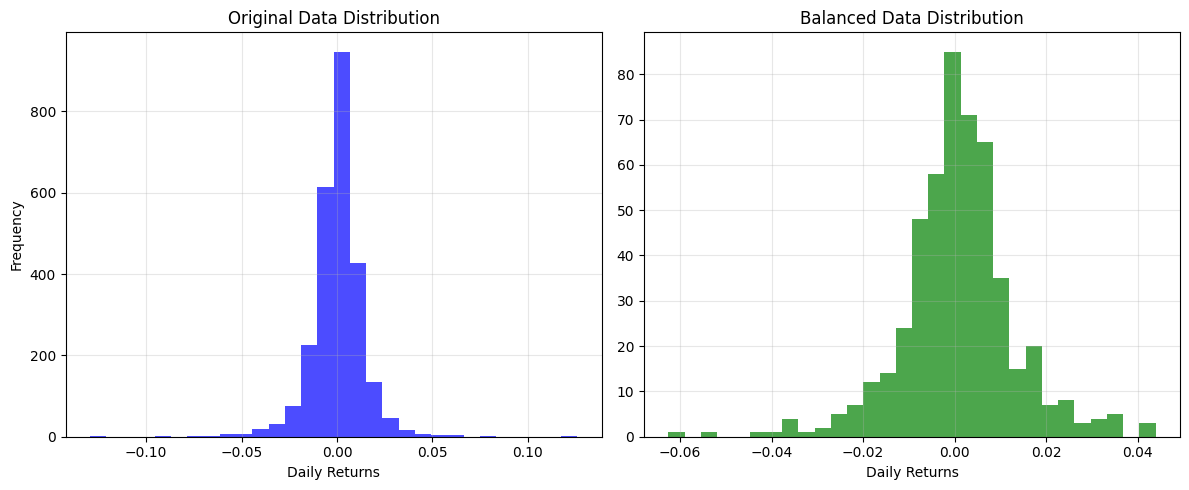


Tuning XGBoost hyperparameters...

Tuning XGBoost hyperparameters...
max_depth=3, Best RMSE: 0.0141
max_depth=5, Best RMSE: 0.0141
max_depth=7, Best RMSE: 0.0141
max_depth=10, Best RMSE: 0.0141
max_depth=15, Best RMSE: 0.0141
max_depth=20, Best RMSE: 0.0141

Best max_depth: 3


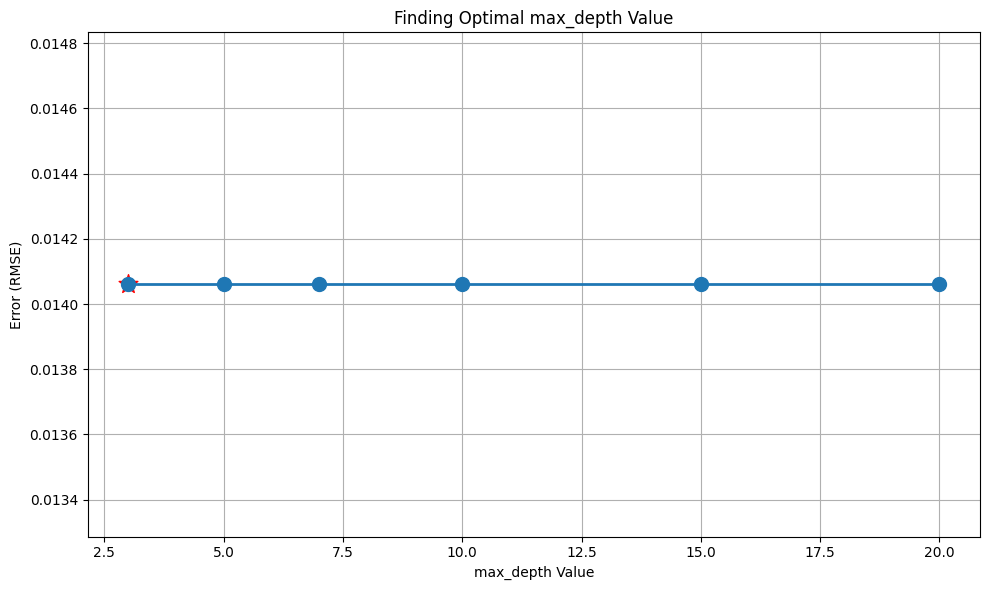


Fine-tuning max_depth...
max_depth=1, Best RMSE: 0.0141
max_depth=2, Best RMSE: 0.0141
max_depth=3, Best RMSE: 0.0141
max_depth=4, Best RMSE: 0.0141
max_depth=5, Best RMSE: 0.0141

Fine-tuned best max_depth: 1

Tuning learning rate (eta)...
eta=0.01, Best RMSE: 0.0141
eta=0.05, Best RMSE: 0.0141
eta=0.1, Best RMSE: 0.0141
eta=0.2, Best RMSE: 0.0141
eta=0.3, Best RMSE: 0.0141

Best learning rate (eta): 0.01


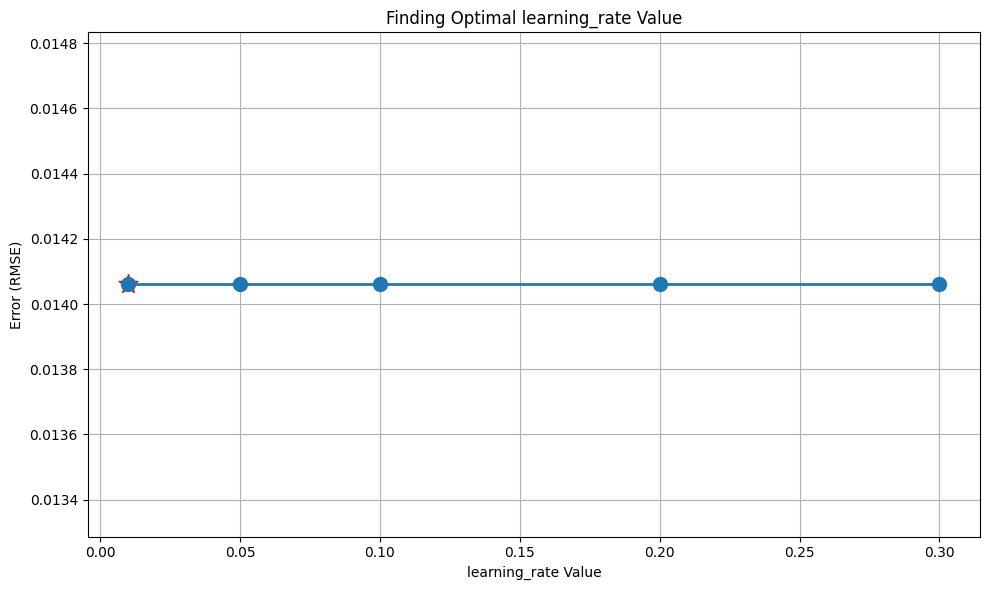


Tuning subsample and colsample_bytree...
Best subsample: 0.6, Best colsample_bytree: 0.6

Final best parameters:
max_depth: 1
eta: 0.01
objective: reg:squarederror
eval_metric: rmse
subsample: 0.6
colsample_bytree: 0.6
alpha: 1
lambda: 1

Training XGBoost model...

Evaluating on validation set...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0141
MAE: 0.0102
R2: -0.0022
Direction_Accuracy: 52.5362


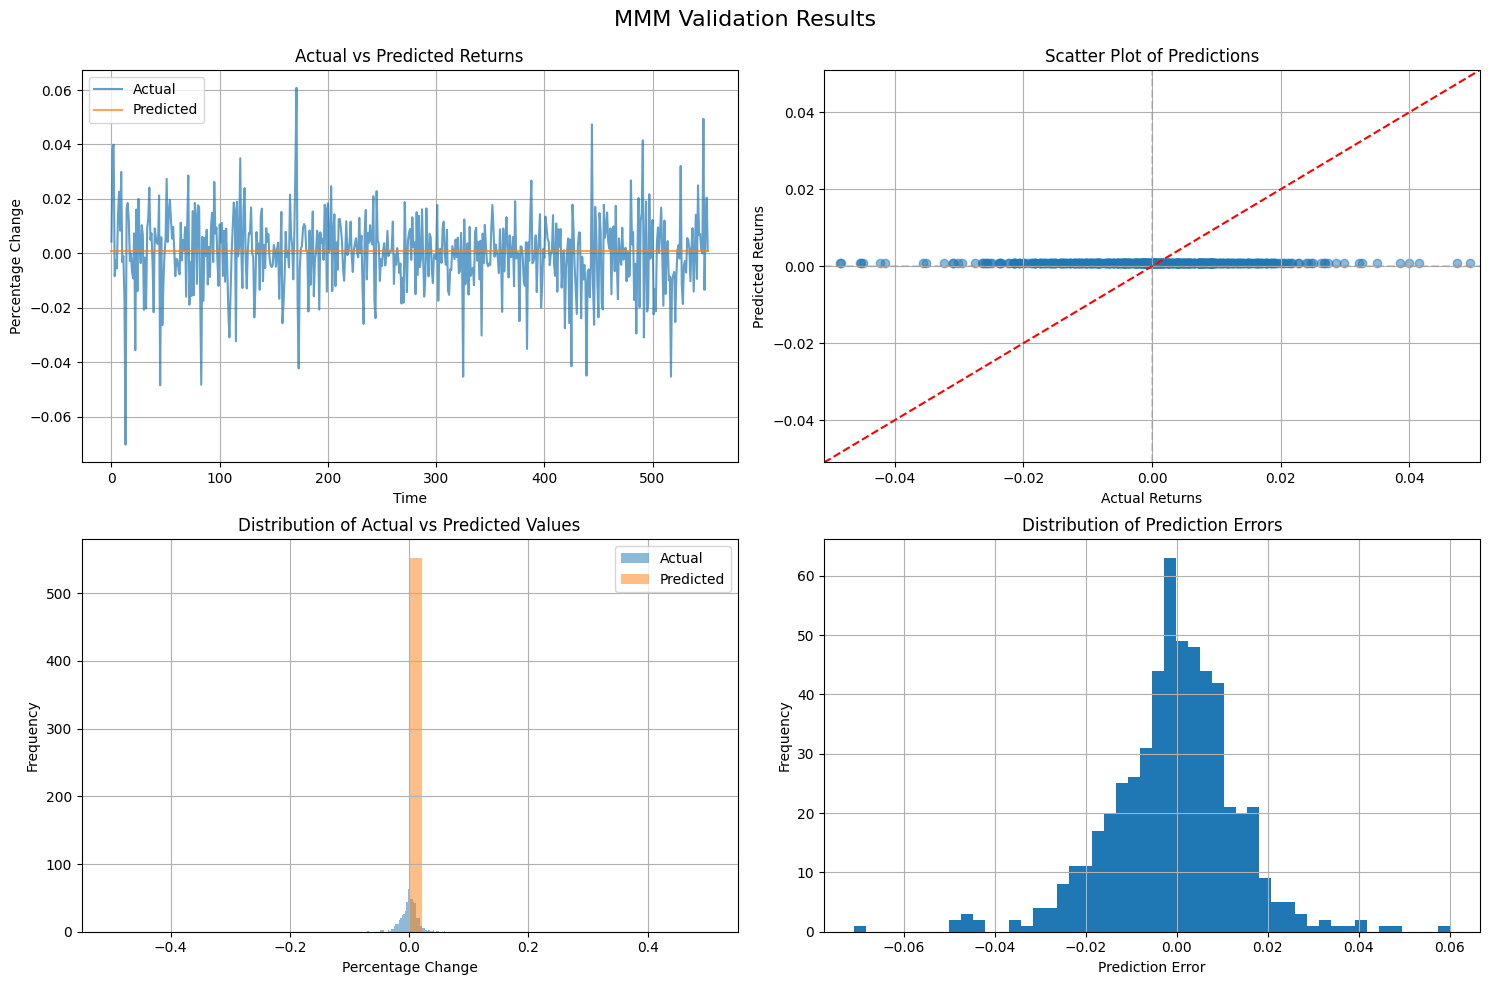


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: -0.0003
Direction_Accuracy: 48.1884


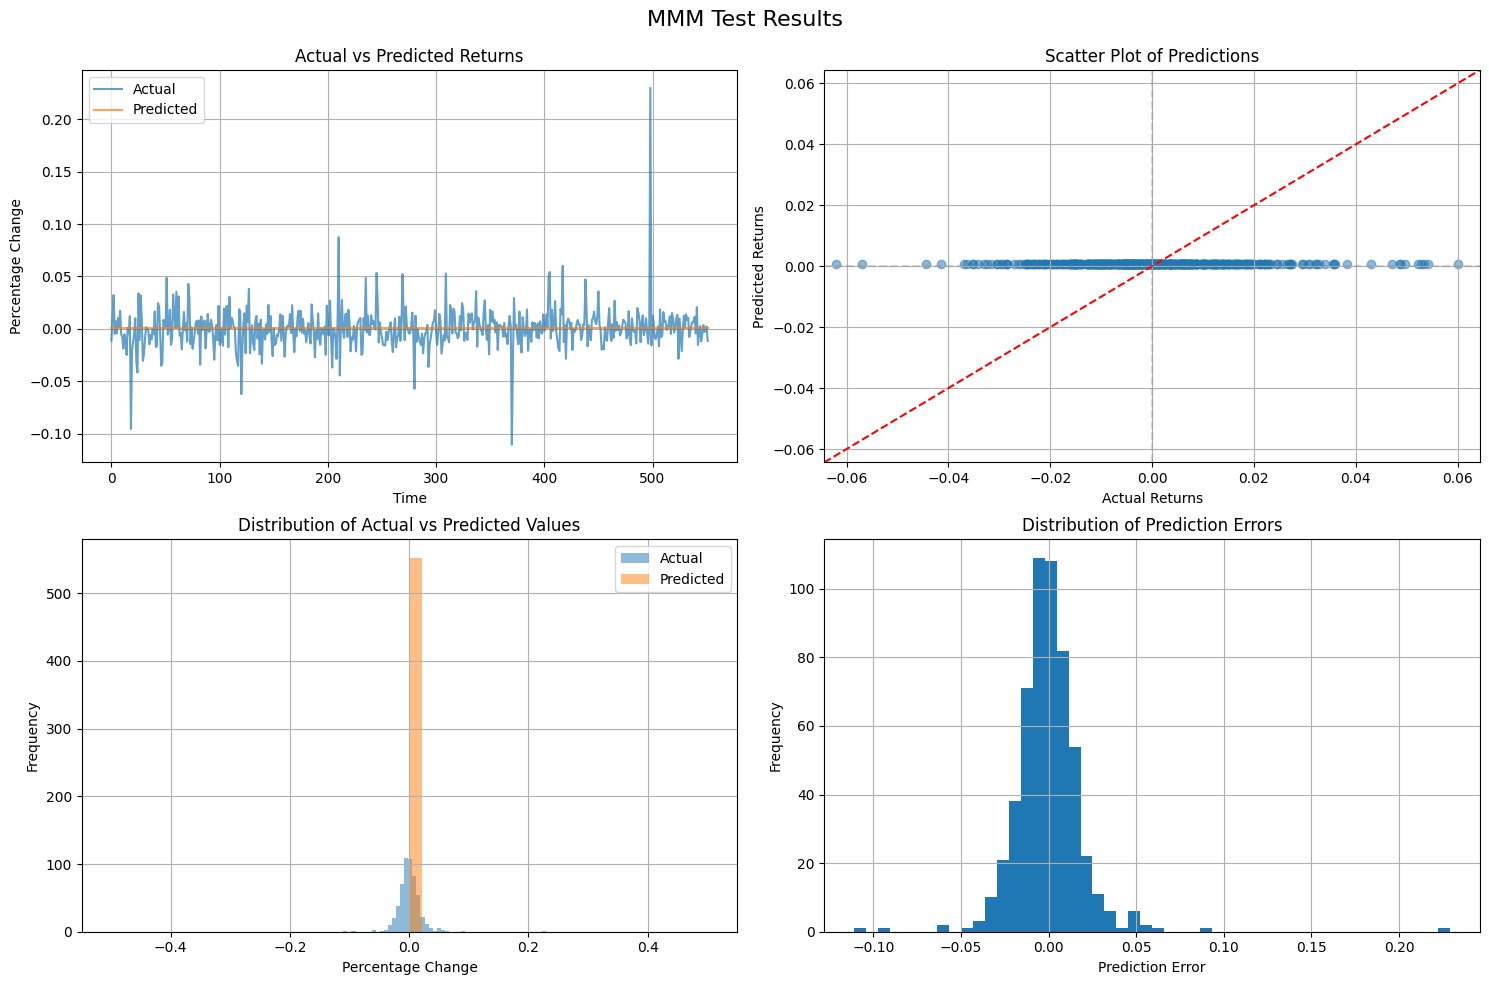




Comparing balanced approach with original approach...
Training set: 2575 samples (2010-03-01 00:00:00 to 2020-05-20 00:00:00)
Validation set: 552 samples (2020-05-21 00:00:00 to 2022-07-29 00:00:00)
Test set: 552 samples (2022-08-01 00:00:00 to 2024-10-09 00:00:00)

Training model without balanced sampling...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0102
R2: -0.0003
Direction_Accuracy: 52.5362

Balanced vs. Original Model Comparison:
Metric               Balanced   Original   Difference
--------------------------------------------------
MSE                  0.0002     0.0002     -0.0000   
RMSE                 0.0141     0.0140     -0.0000   
MAE                  0.0102     0.0102     +0.0000   
R2                   -0.0022    -0.0003    -0.0018   
Direction_Accuracy   52.5362    52.5362    0.0000    


========== EXPERIMENT 2: BALANCED BINS WITHOUT HYPERPARAMETER TUNING ==========

Starting sector-based prediction for MMM
Original stocks_df shape: (1870154, 8)
Ta

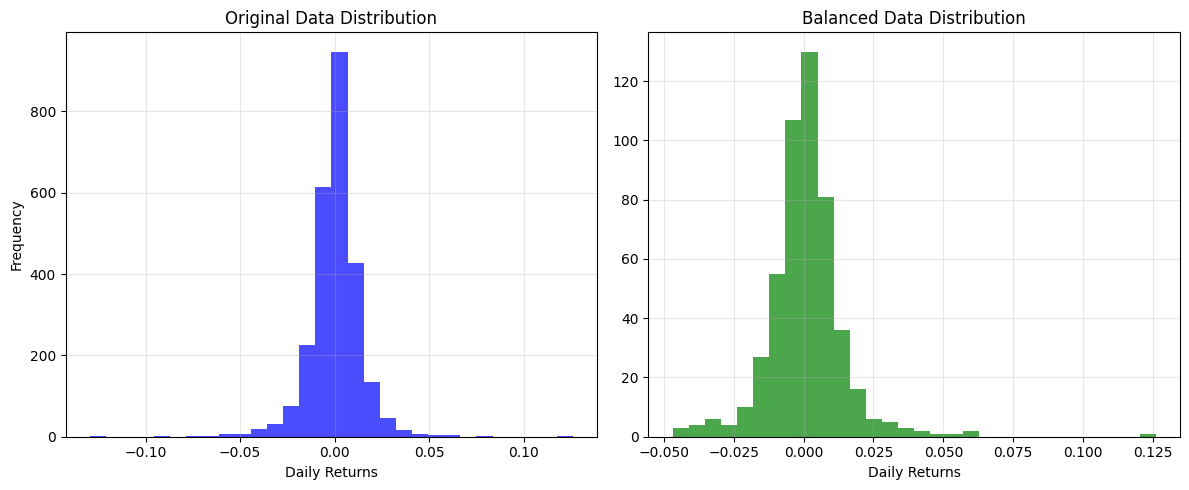


Training XGBoost model...

Evaluating on validation set...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0141
MAE: 0.0102
R2: -0.0029
Direction_Accuracy: 52.5362


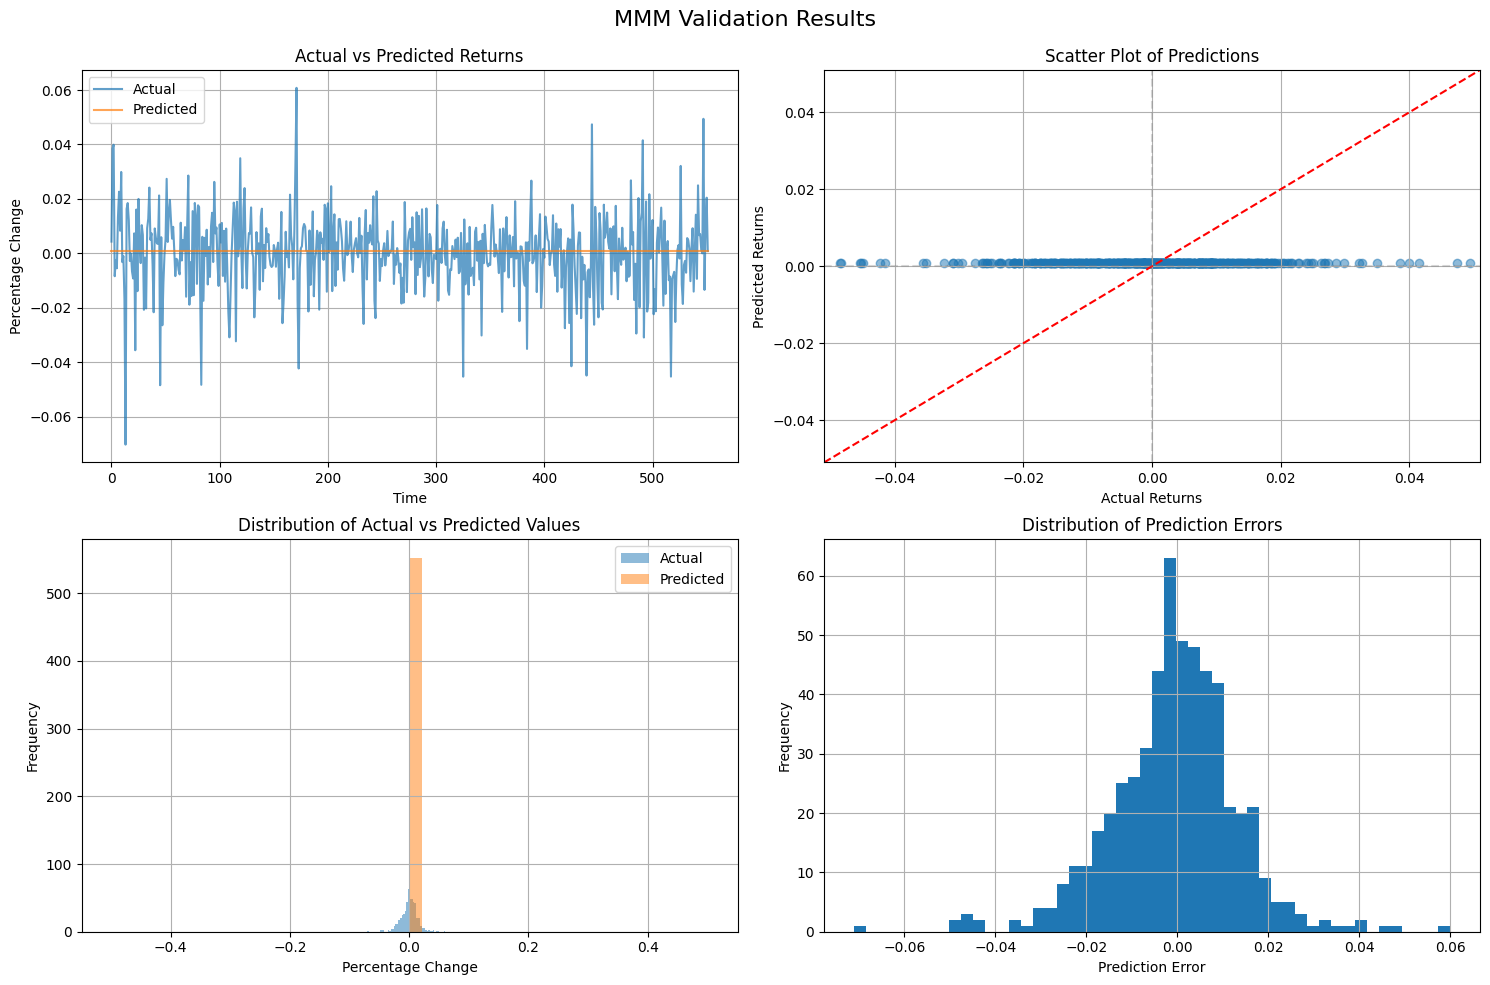


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: -0.0005
Direction_Accuracy: 48.1884


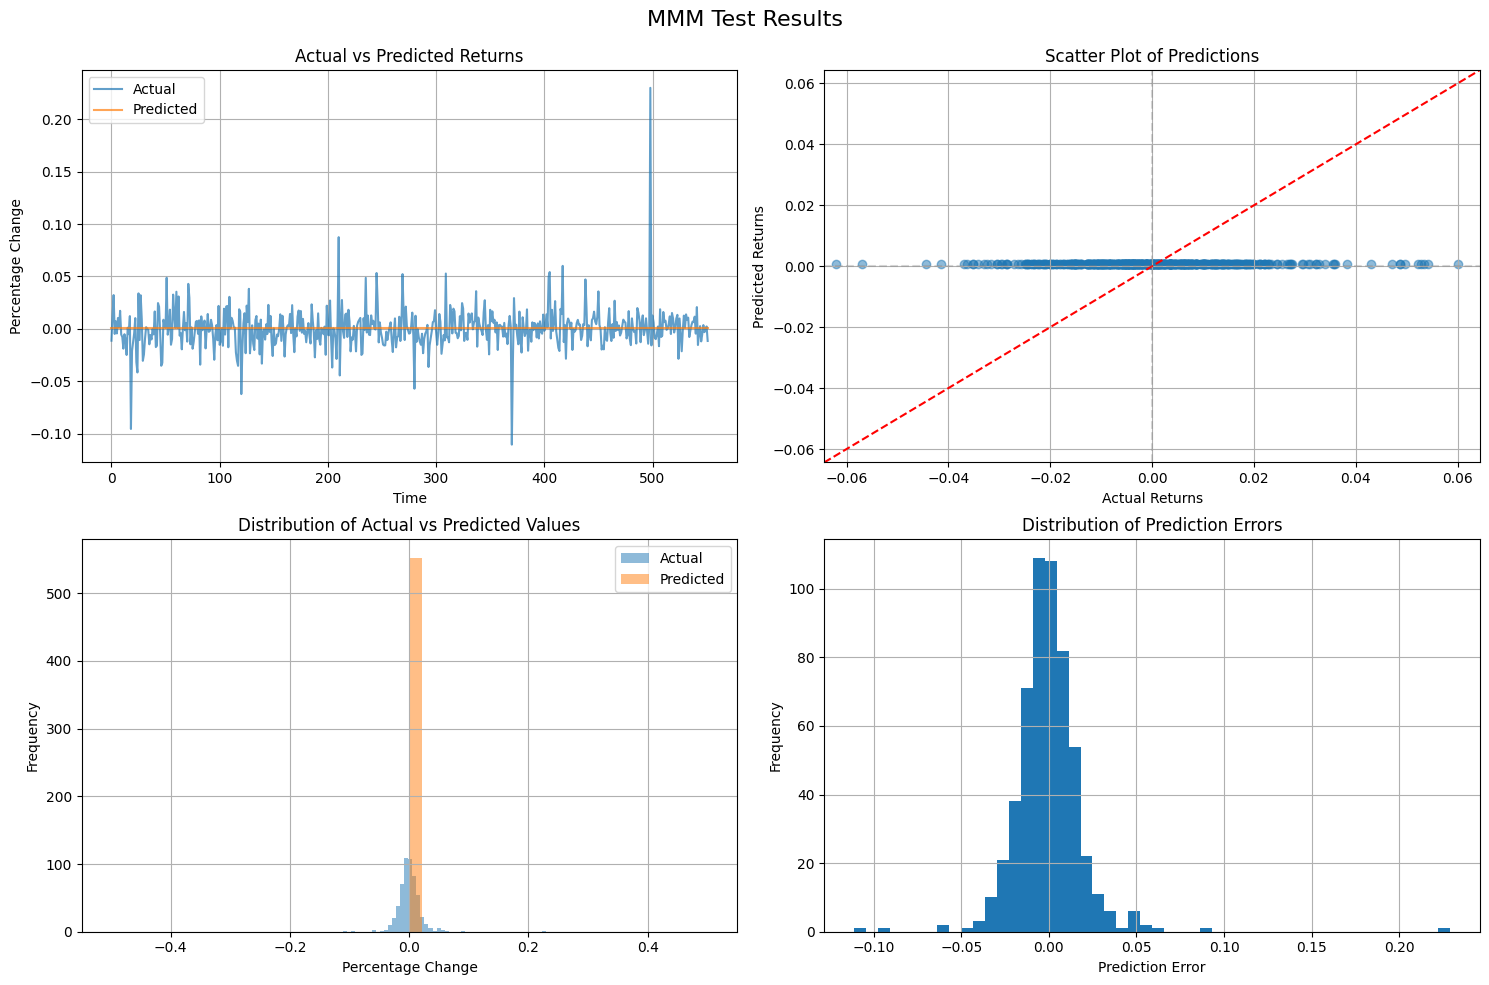




Comparing balanced approach with original approach...
Training set: 2575 samples (2010-03-01 00:00:00 to 2020-05-20 00:00:00)
Validation set: 552 samples (2020-05-21 00:00:00 to 2022-07-29 00:00:00)
Test set: 552 samples (2022-08-01 00:00:00 to 2024-10-09 00:00:00)

Training model without balanced sampling...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0102
R2: 0.0007
Direction_Accuracy: 52.5362

Balanced vs. Original Model Comparison:
Metric               Balanced   Original   Difference
--------------------------------------------------
MSE                  0.0002     0.0002     -0.0000   
RMSE                 0.0141     0.0140     -0.0000   
MAE                  0.0102     0.0102     -0.0000   
R2                   -0.0029    0.0007     -0.0037   
Direction_Accuracy   52.5362    52.5362    0.0000    


========== EXPERIMENT 3: ORIGINAL DISTRIBUTION WITH HYPERPARAMETER TUNING ==========

Starting sector-based prediction for MMM
Original stocks_df shape: (1870154, 8

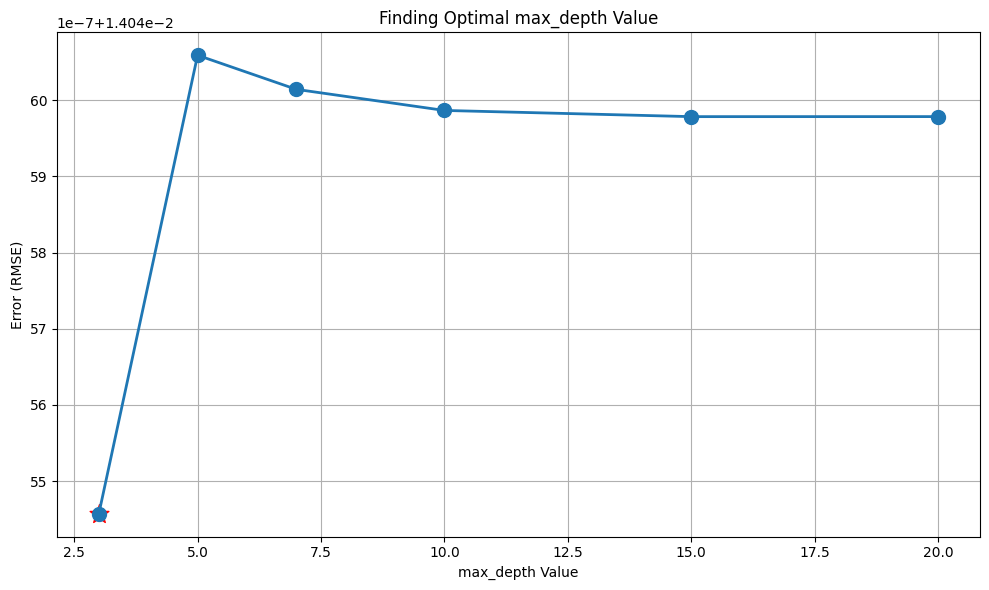


Fine-tuning max_depth...
max_depth=1, Best RMSE: 0.0140
max_depth=2, Best RMSE: 0.0140
max_depth=3, Best RMSE: 0.0140
max_depth=4, Best RMSE: 0.0140
max_depth=5, Best RMSE: 0.0140

Fine-tuned best max_depth: 3

Tuning learning rate (eta)...
eta=0.01, Best RMSE: 0.0140
eta=0.05, Best RMSE: 0.0140
eta=0.1, Best RMSE: 0.0140
eta=0.2, Best RMSE: 0.0140
eta=0.3, Best RMSE: 0.0140

Best learning rate (eta): 0.3


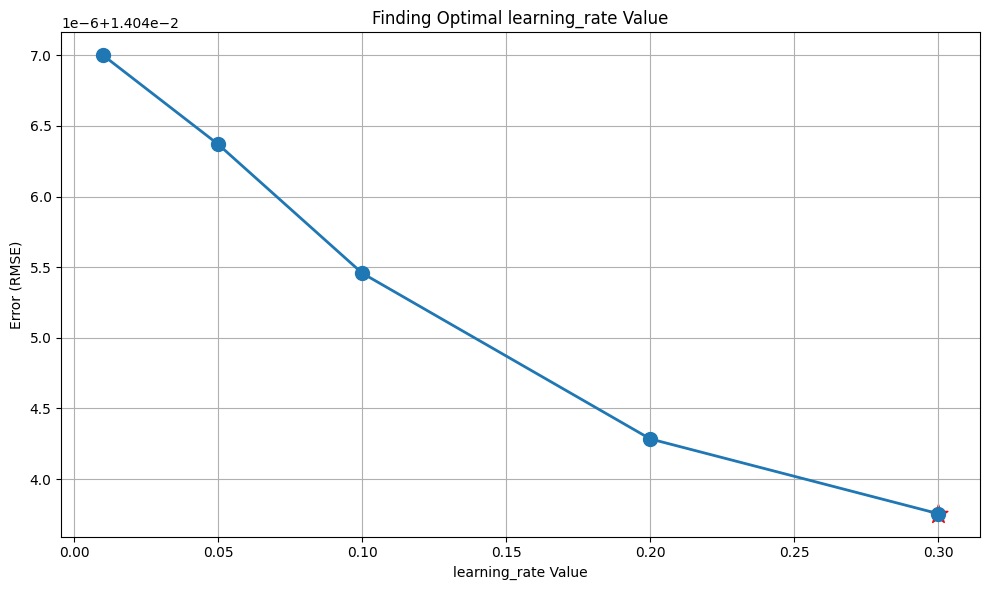


Tuning subsample and colsample_bytree...
Best subsample: 0.7, Best colsample_bytree: 0.9

Final best parameters:
max_depth: 3
eta: 0.3
objective: reg:squarederror
eval_metric: rmse
subsample: 0.7
colsample_bytree: 0.9
alpha: 1
lambda: 1

Training XGBoost model...

Evaluating on validation set...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0102
R2: 0.0009
Direction_Accuracy: 51.9928


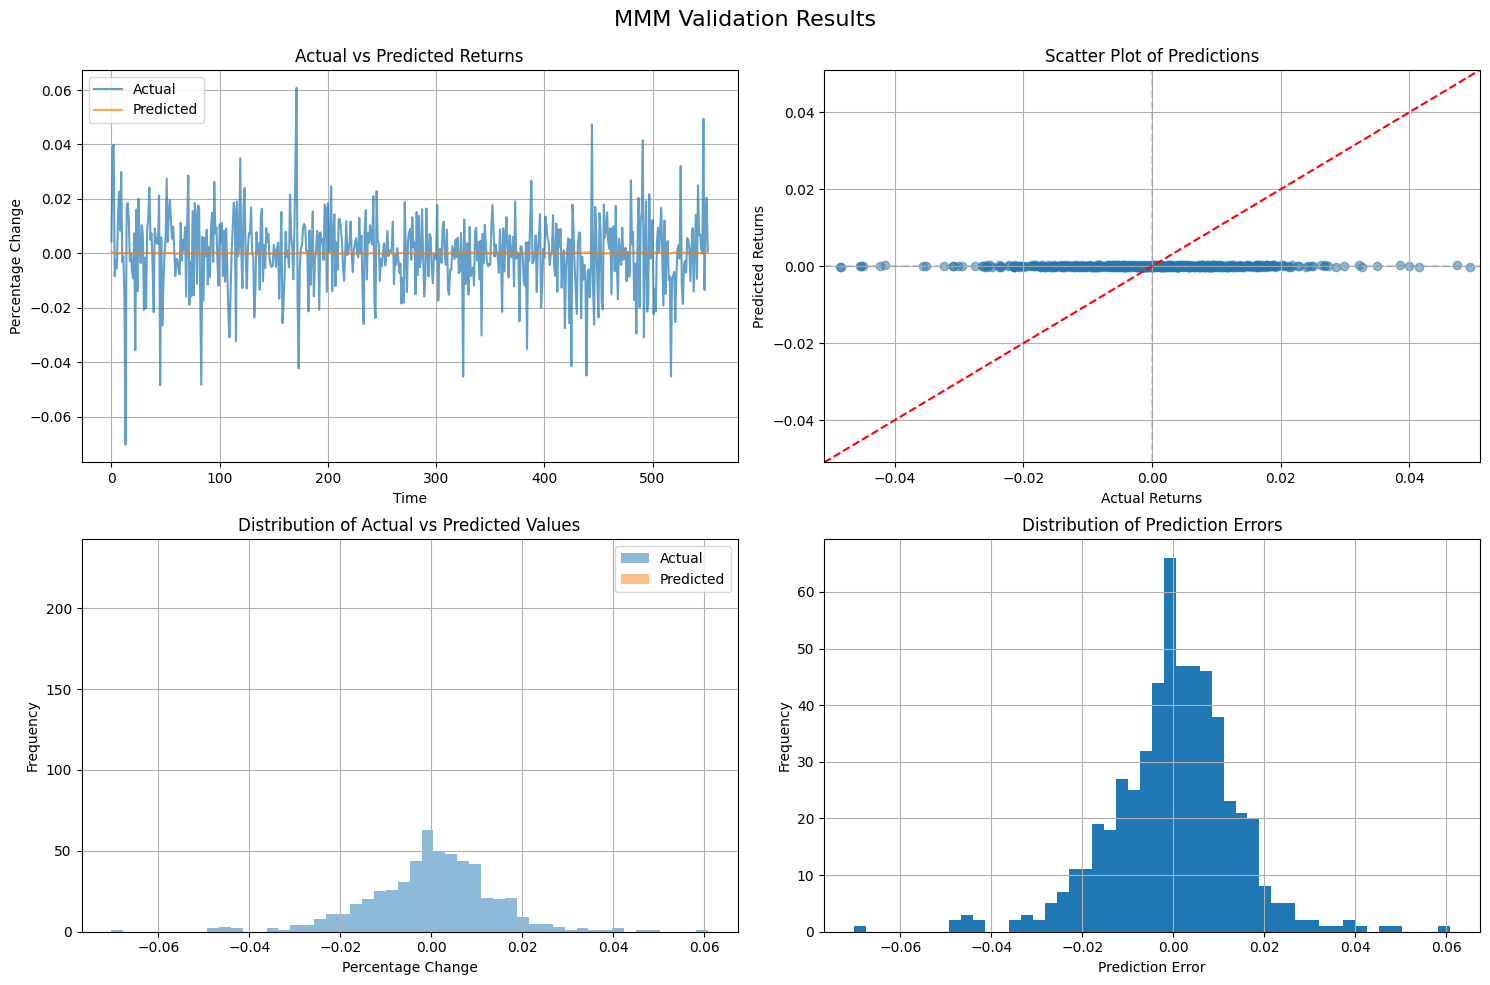

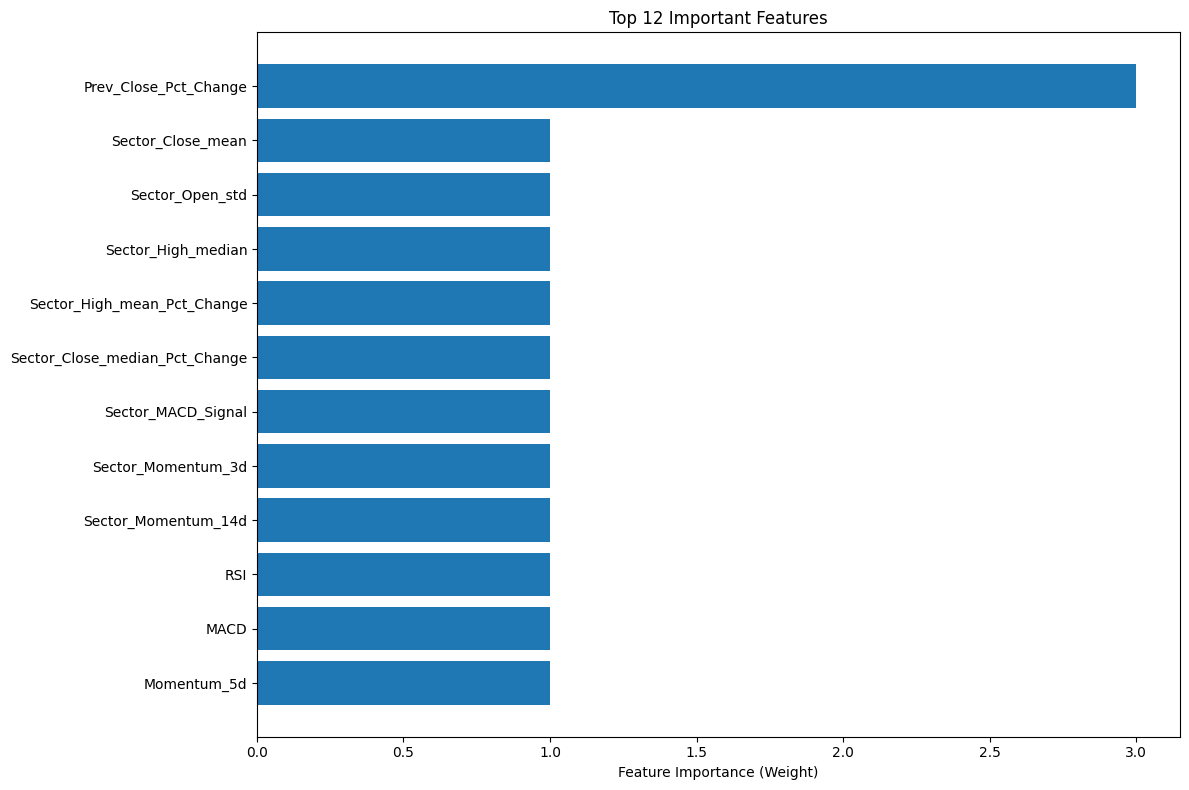


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: -0.0006
Direction_Accuracy: 50.9058


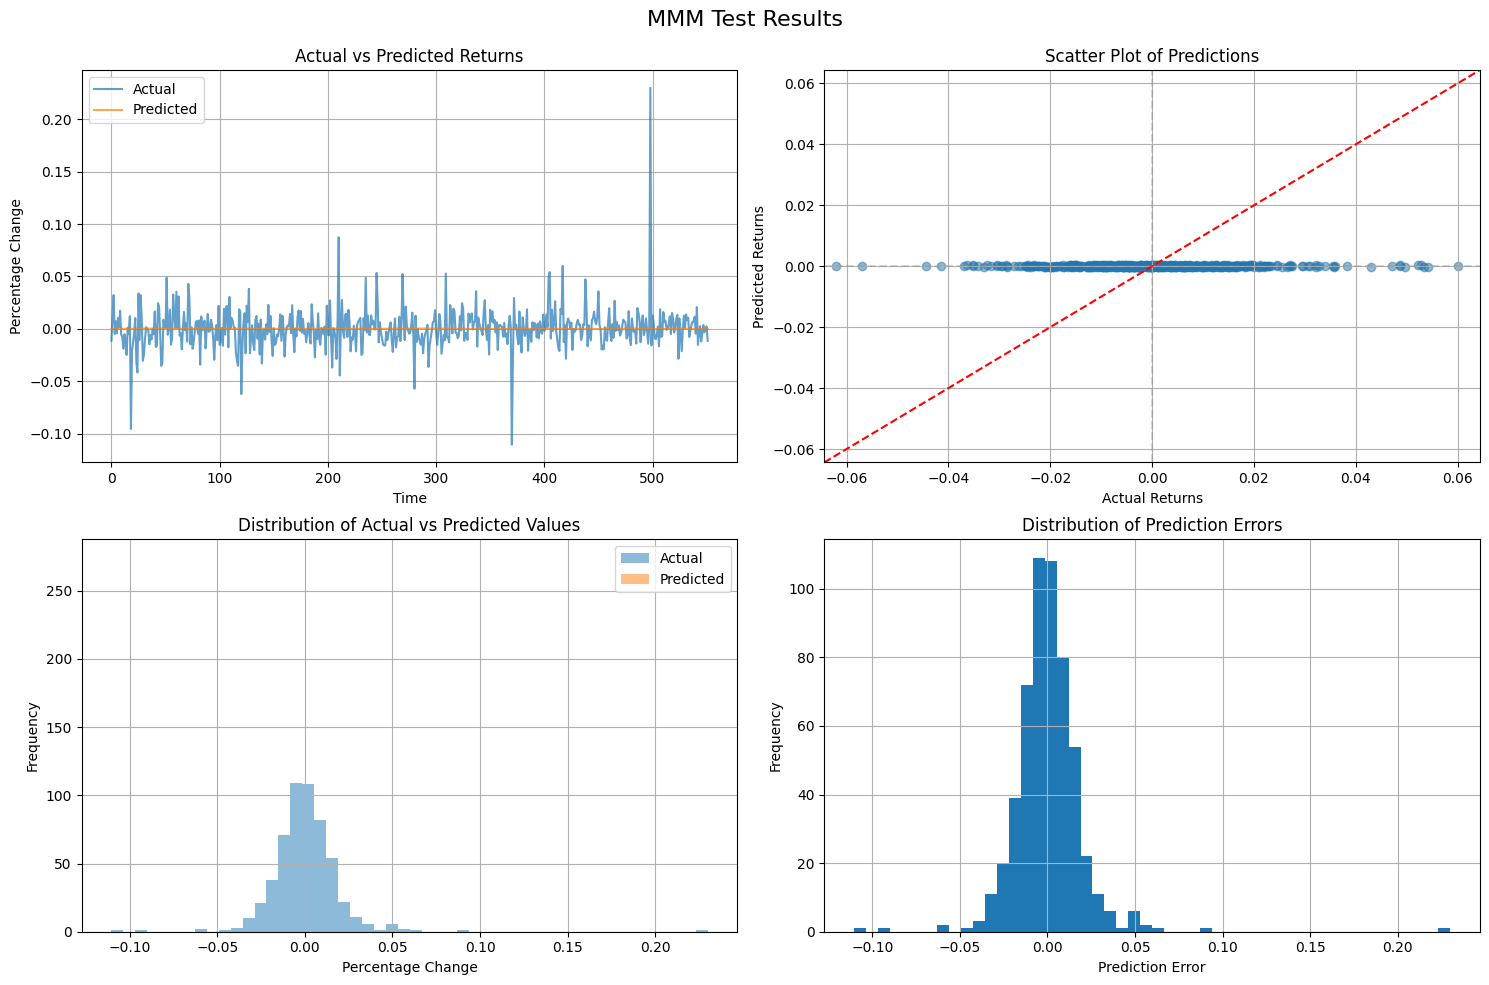


Sector features total importance: 8.00
Individual features total importance: 6.00
Ratio of sector to individual importance: 1.33


========== FINAL COMPARISON ==========
Metric               Balanced+Tuned  Balanced+Untuned Original+Tuned 
-----------------------------------------------------------------
Direction_Accuracy   52.5362         52.5362         51.9928        
RMSE                 0.0141          0.0141          0.0140         
MAE                  0.0102          0.0102          0.0102         
R2                   -0.0022         -0.0029         0.0009         


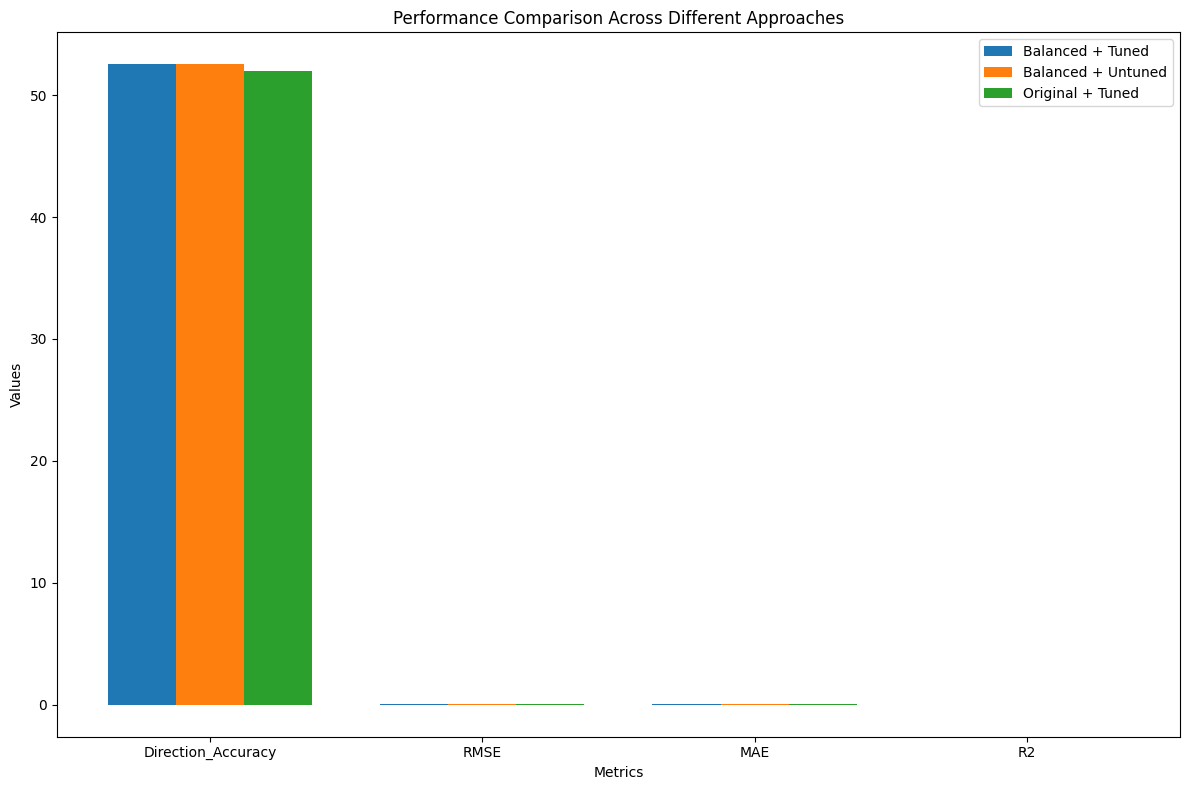

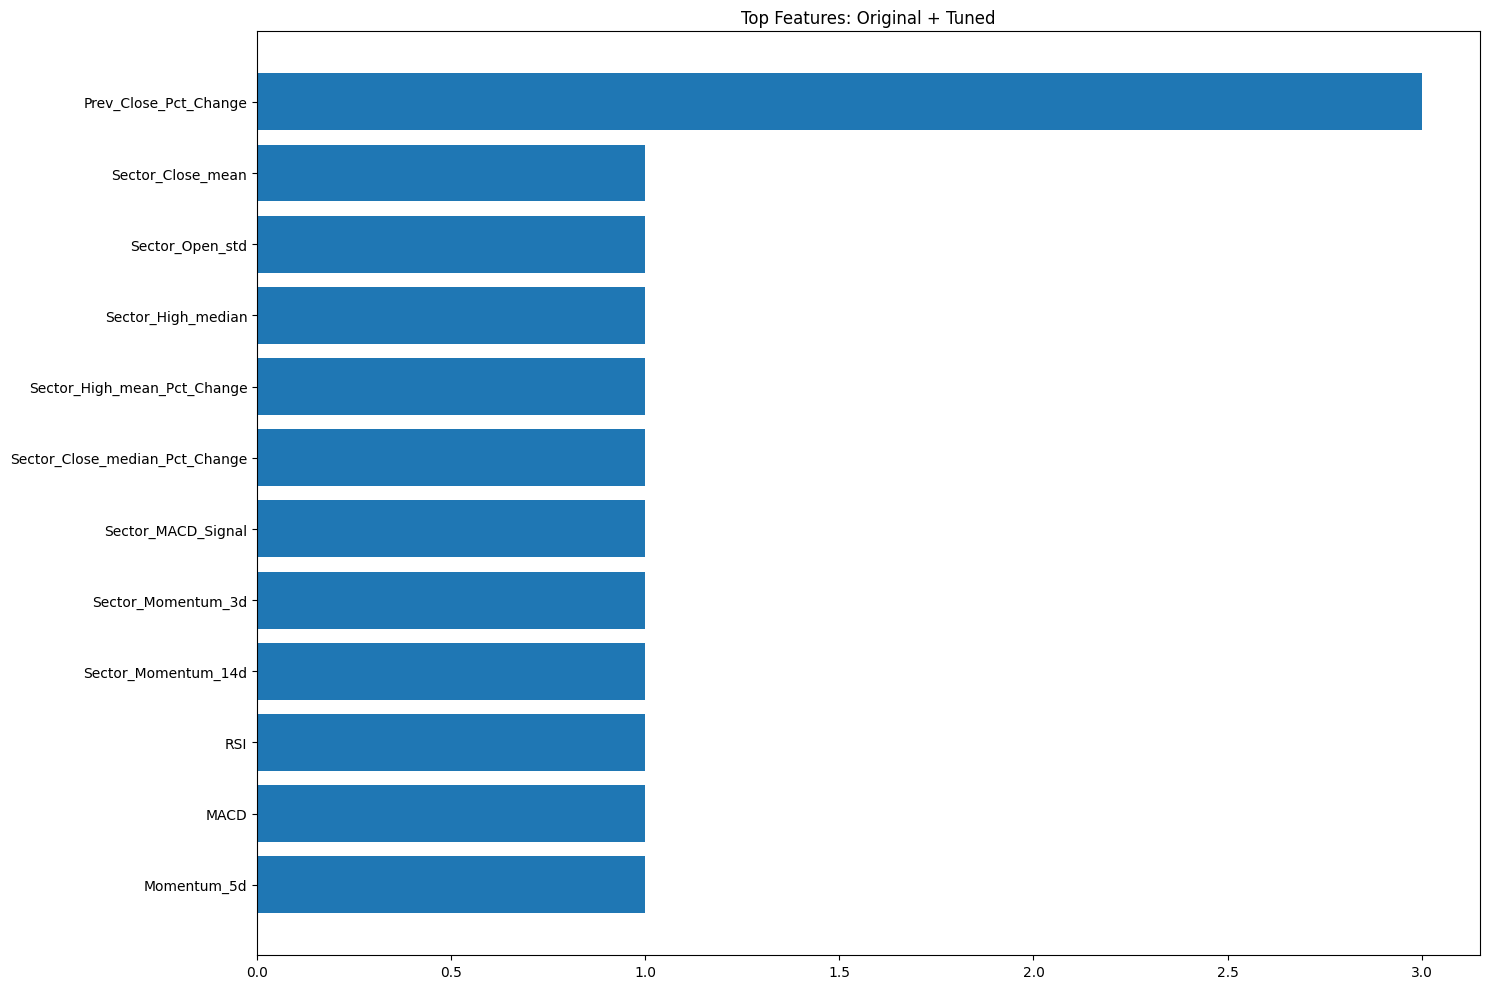


Best Parameters for Balanced + Tuned:
max_depth: 1
eta: 0.01
objective: reg:squarederror
eval_metric: rmse
subsample: 0.6
colsample_bytree: 0.6
alpha: 1
lambda: 1

Best Parameters for Original + Tuned:
max_depth: 3
eta: 0.3
objective: reg:squarederror
eval_metric: rmse
subsample: 0.7
colsample_bytree: 0.9
alpha: 1
lambda: 1


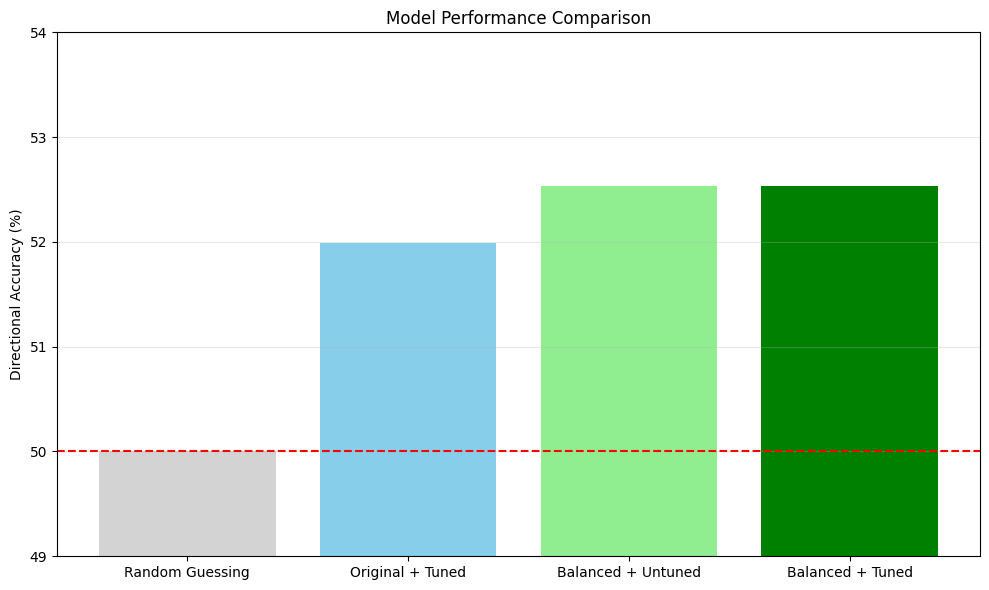

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def main():
    """
    Run the balanced sector-based stock prediction model for MMM
    """
    # Load datasets
    print("Loading data...")

    # Load stock data
    stocks_df = pd.read_csv('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_stocks.csv')

    # Convert Date column to datetime
    stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], errors='coerce')

    # Load companies data with sector information
    companies_df = pd.read_csv('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_companies.csv')

    # Make sure 'Symbol' columns are string type for merging
    stocks_df['Symbol'] = stocks_df['Symbol'].astype(str)
    companies_df['Symbol'] = companies_df['Symbol'].astype(str)

    # Run experiments with different approaches
    target_symbol = 'MMM'

    # Experiment 1: Balanced bins with hyperparameter tuning
    print("\n\n========== EXPERIMENT 1: BALANCED BINS WITH HYPERPARAMETER TUNING ==========")
    results_balanced_tuned = run_sector_based_prediction_with_balanced_data(
        stocks_df,
        companies_df,
        target_symbol,
        use_balanced_bins=True,
        n_bins=5,  # 5 bins for percentage change ranges
        samples_per_bin=100,  # 100 samples per bin
        tune_hyperparameters=True
    )

    # Experiment 2: Balanced bins without hyperparameter tuning
    print("\n\n========== EXPERIMENT 2: BALANCED BINS WITHOUT HYPERPARAMETER TUNING ==========")
    results_balanced_untuned = run_sector_based_prediction_with_balanced_data(
        stocks_df,
        companies_df,
        target_symbol,
        use_balanced_bins=True,
        n_bins=5,
        samples_per_bin=100,
        tune_hyperparameters=False  # Use default parameters
    )

    # Experiment 3: Original data distribution with hyperparameter tuning
    print("\n\n========== EXPERIMENT 3: ORIGINAL DISTRIBUTION WITH HYPERPARAMETER TUNING ==========")
    results_orig_tuned = run_sector_based_prediction_with_balanced_data(
        stocks_df,
        companies_df,
        target_symbol,
        use_balanced_bins=False,  # Use original data distribution
        tune_hyperparameters=True
    )

    # Compare all approaches
    print("\n\n========== FINAL COMPARISON ==========")
    comparison = {
        "Balanced + Tuned": results_balanced_tuned['validation_results']['Metrics'],
        "Balanced + Untuned": results_balanced_untuned['validation_results']['Metrics'],
        "Original + Tuned": results_orig_tuned['validation_results']['Metrics']
    }

    # Create a comparison table
    metrics_to_compare = ['Direction_Accuracy', 'RMSE', 'MAE', 'R2']

    print(f"{'Metric':<20} {'Balanced+Tuned':<15} {'Balanced+Untuned':<15} {'Original+Tuned':<15}")
    print("-" * 65)

    for metric in metrics_to_compare:
        balanced_tuned = comparison["Balanced + Tuned"][metric]
        balanced_untuned = comparison["Balanced + Untuned"][metric]
        orig_tuned = comparison["Original + Tuned"][metric]

        print(f"{metric:<20} {balanced_tuned:<15.4f} {balanced_untuned:<15.4f} {orig_tuned:<15.4f}")

    # Create visualization of performance comparison
    plt.figure(figsize=(12, 8))

    x = np.arange(len(metrics_to_compare))
    width = 0.25

    # Create bars
    plt.bar(x - width, [comparison["Balanced + Tuned"][m] for m in metrics_to_compare],
           width=width, label='Balanced + Tuned')
    plt.bar(x, [comparison["Balanced + Untuned"][m] for m in metrics_to_compare],
           width=width, label='Balanced + Untuned')
    plt.bar(x + width, [comparison["Original + Tuned"][m] for m in metrics_to_compare],
           width=width, label='Original + Tuned')

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance Comparison Across Different Approaches')
    plt.xticks(x, metrics_to_compare)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualize feature importance across methods
    plt.figure(figsize=(15, 10))

    # Check if feature importance dataframes exist and have content
    has_balanced_tuned = not results_balanced_tuned['feature_importance'].empty if 'feature_importance' in results_balanced_tuned else False
    has_balanced_untuned = not results_balanced_untuned['feature_importance'].empty if 'feature_importance' in results_balanced_untuned else False
    has_orig_tuned = not results_orig_tuned['feature_importance'].empty if 'feature_importance' in results_orig_tuned else False

    # Adjust number of subplots based on available data
    num_plots = sum([has_balanced_tuned, has_balanced_untuned, has_orig_tuned])
    if num_plots == 0:
        print("No feature importance data available to plot.")
    else:
        current_plot = 1

        # Plot feature importance comparison
        if has_balanced_tuned:
            plt.subplot(num_plots, 1, current_plot)
            plt.barh(results_balanced_tuned['feature_importance']['Feature'][::-1],
                   results_balanced_tuned['feature_importance']['Importance'][::-1])
            plt.title('Top Features: Balanced + Tuned')
            current_plot += 1

        if has_balanced_untuned:
            plt.subplot(num_plots, 1, current_plot)
            plt.barh(results_balanced_untuned['feature_importance']['Feature'][::-1],
                   results_balanced_untuned['feature_importance']['Importance'][::-1])
            plt.title('Top Features: Balanced + Untuned')
            current_plot += 1

        if has_orig_tuned:
            plt.subplot(num_plots, 1, current_plot)
            plt.barh(results_orig_tuned['feature_importance']['Feature'][::-1],
                   results_orig_tuned['feature_importance']['Importance'][::-1])
            plt.title('Top Features: Original + Tuned')

        plt.tight_layout()
        plt.show()

    # Show best parameters if tuning was performed
    if 'best_params' in results_balanced_tuned and results_balanced_tuned['best_params']:
        print("\nBest Parameters for Balanced + Tuned:")
        for param, value in results_balanced_tuned['best_params'].items():
            print(f"{param}: {value}")

    if 'best_params' in results_orig_tuned and results_orig_tuned['best_params']:
        print("\nBest Parameters for Original + Tuned:")
        for param, value in results_orig_tuned['best_params'].items():
            print(f"{param}: {value}")

# Create directional accuracy chart
    try:
        directional_accuracy = {
            "Original + Tuned": comparison["Original + Tuned"]["Direction_Accuracy"],
            "Balanced + Untuned": comparison["Balanced + Untuned"]["Direction_Accuracy"],
            "Balanced + Tuned": comparison["Balanced + Tuned"]["Direction_Accuracy"]
        }
        plot_directional_accuracy_comparison(directional_accuracy)
    except Exception as e:
        print(f"Visualization error (non-critical): {e}")

    return {
        "results_balanced_tuned": results_balanced_tuned,
        "results_balanced_untuned": results_balanced_untuned,
        "results_orig_tuned": results_orig_tuned
    }



if __name__ == "__main__":
    main()

In [27]:
stocks_df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')

In [28]:
companies_df.columns

Index(['Exchange', 'Symbol', 'Shortname', 'Longname', 'Sector', 'Industry',
       'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State',
       'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight'],
      dtype='object')

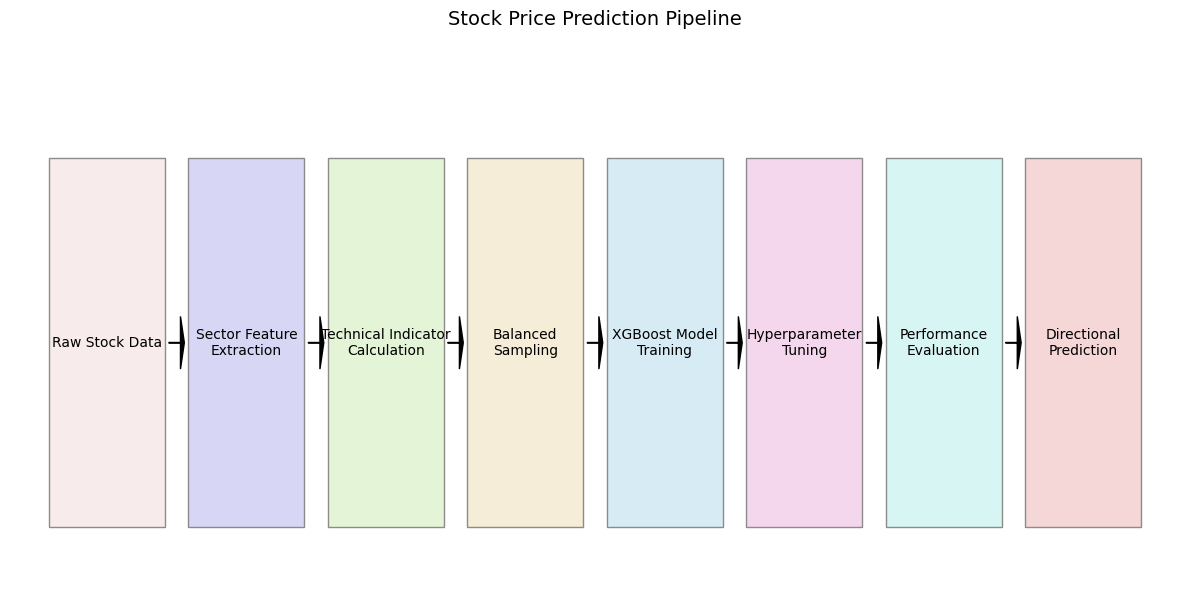

In [29]:
def create_process_flow_diagram():
    """Create a process flow diagram for the stock prediction pipeline"""

    # Import necessary libraries
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np

    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define the steps in the process
    steps = [
        "Raw Stock Data",
        "Sector Feature\nExtraction",
        "Technical Indicator\nCalculation",
        "Balanced\nSampling",
        "XGBoost Model\nTraining",
        "Hyperparameter\nTuning",
        "Performance\nEvaluation",
        "Directional\nPrediction"
    ]

    # Set up colors and positions
    colors = ['#f8e9e9', '#d3d3f4', '#e1f4d3', '#f4ecd3', '#d3e9f4', '#f4d3eb', '#d3f4f2', '#f4d3d3']
    width = 1.5
    height = 0.7
    x_positions = np.arange(len(steps)) * (width + 0.3)

    # Create boxes and arrows
    for i, (step, color) in enumerate(zip(steps, colors)):
        rect = patches.Rectangle((x_positions[i], 0), width, height,
                                linewidth=1, edgecolor='gray', facecolor=color, alpha=0.9)
        ax.add_patch(rect)
        ax.text(x_positions[i] + width/2, height/2, step, ha='center', va='center', fontsize=10)

        # Add arrows between boxes (except for the last one)
        if i < len(steps) - 1:
            ax.arrow(x_positions[i] + width + 0.05, height/2, 0.15, 0,
                    head_width=0.1, head_length=0.05, fc='black', ec='black')

    # Remove axes and set limits
    ax.axis('off')
    ax.set_xlim(-0.5, x_positions[-1] + width + 0.5)
    ax.set_ylim(-0.1, height + 0.2)

    # Add title
    plt.title('Stock Price Prediction Pipeline', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig('process_flow.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to create the diagram
create_process_flow_diagram()